## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [146]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [147]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9491k    0 9491k    0     0  10.9M      0 --:--:-- --:--:-- --:--:-- 26.7M


Version bdc9412b3e468c102d01b7cf6337be06ec6e9c9a enabled for the sky130 PDK.

In [148]:
import openlane

print(openlane.__version__)

2.1.11


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [149]:
%%writefile fc_layer_verilog2005.v
// fc_layer_verilog2005.v

// `timescale 1ns/1ps // Optional for synthesis

// ============================================================================
// fc_layer Module (Converted to Verilog 2005)
// ============================================================================
module fc_layer #(
    parameter DATA_WIDTH = 16,
    parameter FRACTIONAL_BITS = 8,
    parameter LATENT_DIM_FC = 4,
    parameter NUM_OUT_CHANNELS_FC = 4,
    parameter NUM_OUT_FRAMES_FC = 1 // Should be 1 for a 2D output like [ch][0:0]
) (
    input                               clk,
    input                               rst_n,
    input                               i_start,
    // Flattened input for i_z: DATA_WIDTH * LATENT_DIM_FC
    input signed [(DATA_WIDTH*LATENT_DIM_FC)-1:0] i_z_flat,

    output                              o_busy, // Driven by assign, so it's a wire
    output reg                          o_done_tick, // Driven by always block
    // Flattened output for o_fc_result: DATA_WIDTH * NUM_OUT_CHANNELS_FC * NUM_OUT_FRAMES_FC
    // Driven by assign in generate block, so it's a wire
    output signed [(DATA_WIDTH*NUM_OUT_CHANNELS_FC*NUM_OUT_FRAMES_FC)-1:0] o_fc_result_flat
);

    // --- Local Parameters ---
    localparam signed [DATA_WIDTH-1:0] S16_MAX_VAL = 32767; // Max value for signed 16-bit
    localparam signed [DATA_WIDTH-1:0] S16_MIN_VAL = -32768; // Min value for signed 16-bit
    // Rounding constant for fixed-point arithmetic
    localparam signed [31:0] ROUND_CONST = (FRACTIONAL_BITS > 0) ? (1 << (FRACTIONAL_BITS - 1)) : 32'sd0;

    // State machine encoding
    localparam [0:0] IDLE_STATE    = 1'b0;
    localparam [0:0] COMPUTE_STATE = 1'b1;

    // --- Internal Registers and Wires ---
    reg signed [DATA_WIDTH-1:0] temp_fc_result_comb [0:NUM_OUT_CHANNELS_FC-1]; // Combinational temporary result
    reg [0:0] current_state, next_state; // FSM states

    // Internal unpacked version of i_z_flat
    wire signed [DATA_WIDTH-1:0] i_z_unpacked [0:LATENT_DIM_FC-1];
    // Internal registered version of the output (before flattening)
    // Assuming NUM_OUT_FRAMES_FC is always 1, so it's effectively 1D per channel.
    reg signed [DATA_WIDTH-1:0] o_fc_result_internal [0:NUM_OUT_CHANNELS_FC-1];


    // --- Helper Functions for Weights and Biases ---
    // These functions replace the SystemVerilog localparam array initializations.

    // Function to get BIAS_FC value
    // Original BIAS_FC: '{ 16'sd3, 16'sd5, 16'sd8, 16'sd10 }
    function signed [DATA_WIDTH-1:0] get_bias_fc (input integer channel_idx);
        begin
            case (channel_idx)
                0: get_bias_fc = 16'sd3;
                1: get_bias_fc = 16'sd5;
                2: get_bias_fc = 16'sd8;
                3: get_bias_fc = 16'sd10;
                default: get_bias_fc = {DATA_WIDTH{1'b0}}; // Default to 0 for safety
            endcase
        end
    endfunction

    // Function to get WEIGHTS_FC value
    // Original WEIGHTS_FC:
    // '{ '{ 16'sd26,  16'sd51,  16'sd77, 16'sd102 },  // Channel 0
    //    '{ 16'sd128, 16'sd154, 16'sd179, 16'sd205 }, // Channel 1
    //    '{ 16'sd51,  16'sd102, 16'sd154, 16'sd205 }, // Channel 2
    //    '{ 16'sd26,  16'sd77,  16'sd128, 16'sd179 }   // Channel 3
    // }
    function signed [DATA_WIDTH-1:0] get_weights_fc (input integer out_ch_idx, input integer latent_idx);
        begin
            case (out_ch_idx)
                0: case (latent_idx) // Weights for output channel 0
                       0: get_weights_fc = 16'sd26;
                       1: get_weights_fc = 16'sd51;
                       2: get_weights_fc = 16'sd77;
                       3: get_weights_fc = 16'sd102;
                       default: get_weights_fc = {DATA_WIDTH{1'b0}};
                   endcase
                1: case (latent_idx) // Weights for output channel 1
                       0: get_weights_fc = 16'sd128;
                       1: get_weights_fc = 16'sd154;
                       2: get_weights_fc = 16'sd179;
                       3: get_weights_fc = 16'sd205;
                       default: get_weights_fc = {DATA_WIDTH{1'b0}};
                   endcase
                2: case (latent_idx) // Weights for output channel 2
                       0: get_weights_fc = 16'sd51;
                       1: get_weights_fc = 16'sd102;
                       2: get_weights_fc = 16'sd154;
                       3: get_weights_fc = 16'sd205;
                       default: get_weights_fc = {DATA_WIDTH{1'b0}};
                   endcase
                3: case (latent_idx) // Weights for output channel 3
                       0: get_weights_fc = 16'sd26;
                       1: get_weights_fc = 16'sd77;
                       2: get_weights_fc = 16'sd128;
                       3: get_weights_fc = 16'sd179;
                       default: get_weights_fc = {DATA_WIDTH{1'b0}};
                   endcase
                default: get_weights_fc = {DATA_WIDTH{1'b0}};
            endcase
        end
    endfunction


    // --- Unpack i_z_flat into i_z_unpacked ---
    // This uses a generate block to create assign statements for each element.
    genvar idx_unpack_iz;
    generate
        for (idx_unpack_iz = 0; idx_unpack_iz < LATENT_DIM_FC; idx_unpack_iz = idx_unpack_iz + 1) begin : unpack_iz_loop
            // Part-select: i_z_flat[ (higher_index) : (lower_index) ]
            // For i_z_unpacked[0], bits are i_z_flat[DATA_WIDTH-1 : 0]
            // For i_z_unpacked[1], bits are i_z_flat[2*DATA_WIDTH-1 : DATA_WIDTH]
            // Using Verilog-2001 indexed part select: vector[base_expr +: width_expr] or vector[base_expr -: width_expr]
            // assign i_z_unpacked[idx_unpack_iz] = i_z_flat[(idx_unpack_iz * DATA_WIDTH) +: DATA_WIDTH]; // Equivalent
            assign i_z_unpacked[idx_unpack_iz] = i_z_flat[((idx_unpack_iz+1)*DATA_WIDTH)-1 -: DATA_WIDTH];
        end
    endgenerate


    // --- State Machine Logic ---
    // State register
    always @(posedge clk or negedge rst_n) begin
        if (!rst_n) begin
            current_state <= IDLE_STATE;
        end else begin
            current_state <= next_state;
        end
    end

    // Next state logic and o_done_tick
    always @(*) begin
        next_state = current_state; // Default: stay in current state
        o_done_tick = 1'b0;         // Default: o_done_tick is not active

        case (current_state)
            IDLE_STATE: begin
                if (i_start) begin
                    next_state = COMPUTE_STATE;
                end
            end
            COMPUTE_STATE: begin
                o_done_tick = 1'b1; // Signal completion in this cycle
                next_state = IDLE_STATE;    // Transition back to IDLE
            end
            default: begin
                next_state = IDLE_STATE; // Safety: go to IDLE for undefined states
            end
        endcase
    end

    // Busy signal: active when in COMPUTE state
    assign o_busy = (current_state == COMPUTE_STATE);


    // --- Combinational Computation Logic ---
    // This block calculates the dot products for the fully connected layer.
    always @(*) begin
        integer i; // Loop variable for output channels
        integer j; // Loop variable for latent dimensions (input features)
        reg signed [31:0] acc; // Accumulator for dot product (wider to prevent overflow)
        reg signed [31:0] prod; // Product of input and weight
        reg signed [31:0] temp_sum_for_shift; // Temporary sum before shifting

        // Default assignment for temp_fc_result_comb: holds the current registered output value
        // This ensures that if not in COMPUTE state, the values to be registered remain unchanged.
        for (i = 0; i < NUM_OUT_CHANNELS_FC; i = i + 1) begin
            temp_fc_result_comb[i] = o_fc_result_internal[i];
        end

        if (current_state == COMPUTE_STATE) begin
            for (i = 0; i < NUM_OUT_CHANNELS_FC; i = i + 1) begin
                acc = 32'sd0; // Initialize accumulator for each output channel

                // Perform dot product: sum(input[j] * weight[i][j])
                for (j = 0; j < LATENT_DIM_FC; j = j + 1) begin
                    prod = i_z_unpacked[j] * get_weights_fc(i, j);
                    // Add rounding constant before shifting (for fixed-point division)
                    temp_sum_for_shift = prod + ROUND_CONST;
                    // Arithmetic right shift (>> performs arithmetic shift on signed types in Verilog)
                    acc = acc + (temp_sum_for_shift >> FRACTIONAL_BITS);
                end

                // Add bias
                acc = acc + get_bias_fc(i);

                // Saturation logic: clamp the result to DATA_WIDTH signed limits
                if (acc > S16_MAX_VAL) begin
                    temp_fc_result_comb[i] = S16_MAX_VAL;
                end else if (acc < S16_MIN_VAL) begin
                    temp_fc_result_comb[i] = S16_MIN_VAL;
                end else begin
                    // Truncate to DATA_WIDTH (lower bits of acc)
                    temp_fc_result_comb[i] = acc[DATA_WIDTH-1:0];
                end
            end
        end
    end


    // --- Sequential Logic for Output Register ---
    // Registers the computed result when o_done_tick is high.
    always @(posedge clk or negedge rst_n) begin
        integer i_ff; // Loop variable for output channels
        if (!rst_n) begin
            // Reset output registers to 0
            for (i_ff = 0; i_ff < NUM_OUT_CHANNELS_FC; i_ff = i_ff + 1) begin
                // Assuming NUM_OUT_FRAMES_FC is 1, so o_fc_result_internal is 1D
                o_fc_result_internal[i_ff] <= {DATA_WIDTH{1'b0}};
            end
        end else if (o_done_tick) begin // When computation is done
            // Load the combinational result into the output registers
            for (i_ff = 0; i_ff < NUM_OUT_CHANNELS_FC; i_ff = i_ff + 1) begin
                o_fc_result_internal[i_ff] <= temp_fc_result_comb[i_ff];
            end
        end
        // Else: o_fc_result_internal holds its previous value (implicit latching behavior of regs)
    end

    // --- Pack o_fc_result_internal into o_fc_result_flat ---
    // This uses a generate block to create assign statements.
    // NUM_OUT_FRAMES_FC is assumed to be 1.
    genvar idx_pack_ofc;
    generate
        // If NUM_OUT_FRAMES_FC is guaranteed to be 1, the packing is simpler.
        // The total width of o_fc_result_flat is DATA_WIDTH * NUM_OUT_CHANNELS_FC * 1.
        for (idx_pack_ofc = 0; idx_pack_ofc < NUM_OUT_CHANNELS_FC; idx_pack_ofc = idx_pack_ofc + 1) begin : pack_ofc_loop
            // assign o_fc_result_flat[(idx_pack_ofc * DATA_WIDTH) +: DATA_WIDTH] = o_fc_result_internal[idx_pack_ofc];
            assign o_fc_result_flat[((idx_pack_ofc+1)*DATA_WIDTH)-1 -: DATA_WIDTH] = o_fc_result_internal[idx_pack_ofc];
        end
    endgenerate

endmodule

// ============================================================================
// test_fc_top (Top module for OpenLane to synthesize - Verilog 2005)
// ============================================================================
module test_fc_top (
    input  clk,
    input  rst_n,
    input  i_fc_start,
    // Flattened input for i_z: DATA_WIDTH * LATENT_DIM_FC = 16 * 4 = 64 bits
    input  signed [(16*4)-1:0] i_z_fc_flat,

    // Flattened output for o_fc_result: DATA_WIDTH * NUM_OUT_CHANNELS_FC * NUM_OUT_FRAMES_FC = 16 * 4 * 1 = 64 bits
    output signed [(16*4*1)-1:0] o_fc_result_flat,
    output o_fc_busy_top,
    output o_fc_done_tick_top
);

    // Parameters for fc_layer (must match those used in fc_layer definition)
    // These are local to this module but should correspond to the fc_layer instance.
    localparam DATA_WIDTH_LP = 16;
    localparam FRACTIONAL_BITS_LP = 8; // Make sure this matches fc_layer's FRACTIONAL_BITS
    localparam LATENT_DIM_FC_LP = 4;
    localparam NUM_OUT_CHANNELS_FC_LP = 4;
    localparam NUM_OUT_FRAMES_FC_LP = 1; // Must be 1 for o_fc_result[ch][0]

    // Instantiate fc_layer
    // The fc_layer module now handles flattened inputs and outputs directly.
    fc_layer #(
        .DATA_WIDTH(DATA_WIDTH_LP),
        .FRACTIONAL_BITS(FRACTIONAL_BITS_LP),
        .LATENT_DIM_FC(LATENT_DIM_FC_LP),
        .NUM_OUT_CHANNELS_FC(NUM_OUT_CHANNELS_FC_LP),
        .NUM_OUT_FRAMES_FC(NUM_OUT_FRAMES_FC_LP)
    ) fc0 (
        .clk(clk),
        .rst_n(rst_n),
        .i_start(i_fc_start),
        .i_z_flat(i_z_fc_flat), // Pass flattened input directly
        .o_busy(o_fc_busy_top),
        .o_done_tick(o_fc_done_tick_top),
        .o_fc_result_flat(o_fc_result_flat) // Receive flattened output directly
    );

    // No packing/unpacking logic needed in test_fc_top anymore,
    // as fc_layer now uses flattened ports.

endmodule



Overwriting fc_layer_verilog2005.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [150]:
from openlane.config import Config

Config.interactive(
    "test_fc_top",      # MODIFIED: Set to the new top-level test module
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",      # This should match the clock port name in test_fc_layer
    CLOCK_PERIOD=100,
    # You may need to define VERILOG_FILES here if it's not picked up by the Synthesis step
    # VERILOG_FILES=["./decoder_test.sv"], # Usually set in the Synthesis step itself
    # Define PRIMARY_GDSII_STREAMOUT_TOOL if you run the full flow
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout"
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 100
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: test_fc_top
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane_ipynb/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.1.11
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [151]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [152]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


(step-yosys-synthesis)=
### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |

(yosys.synthesis-configuration-variables)=
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP`{#var-yosys-synthesis-synth_latch_map}<sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP`{#var-yosys-synthesis-synth_tristate_map}<sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP`{#var-yosys-synthesis-synth_csa_map}<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP`{#var-yosys-synthesis-synth_rca_map}<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP`{#var-yosys-synthesis-synth_fa_map}<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP`{#var-yosys-synthesis-synth_mux_map}<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP`{#var-yosys-synthesis-synth_mux4_map}<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`{#var-yosys-synthesis-use_lighter} | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`{#var-yosys-synthesis-lighter_dff_map} | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`{#var-yosys-synthesis-yosys_log_level} | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`{#var-yosys-synthesis-synth_checks_allow_tristate} | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`{#var-yosys-synthesis-synth_autoname} | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`{#var-yosys-synthesis-synth_strategy} | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`{#var-yosys-synthesis-synth_abc_buffering} | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`{#var-yosys-synthesis-synth_abc_legacy_refactor} | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`{#var-yosys-synthesis-synth_abc_legacy_rewrite} | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`{#var-yosys-synthesis-synth_direct_wire_buffering} | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`{#var-yosys-synthesis-synth_splitnets} | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`{#var-yosys-synthesis-synth_sizing} | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_NO_FLAT`{#var-yosys-synthesis-synth_no_flat} | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| `SYNTH_SHARE_RESOURCES`{#var-yosys-synthesis-synth_share_resources} | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`{#var-yosys-synthesis-synth_adder_type} | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`{#var-yosys-synthesis-synth_extra_mapping_file} | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_PARAMETERS`{#var-yosys-synthesis-synth_parameters} | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `SYNTH_ELABORATE_ONLY`{#var-yosys-synthesis-synth_elaborate_only} | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`{#var-yosys-synthesis-synth_elaborate_flatten} | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `VERILOG_FILES`{#var-yosys-synthesis-verilog_files} | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`{#var-yosys-synthesis-verilog_defines} | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`{#var-yosys-synthesis-verilog_power_define} | str | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`{#var-yosys-synthesis-verilog_include_dirs} | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| `USE_SYNLIG`{#var-yosys-synthesis-use_synlig} | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`{#var-yosys-synthesis-synlig_defer} | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [153]:
from openlane.steps import Step
from openlane.state import State

Synthesis = Step.factory.get("Yosys.Synthesis")

synthesis_step = Synthesis(
    VERILOG_FILES=["./fc_layer_verilog2005.v"], # MODIFIED: Point to the new file
    # The top module is now taken from Config.interactive's first argument
    state_in=State(),
)
synthesis_step.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[22:01:54] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=968582;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=139139;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:01:54] VERBOSE  Logging subprocess to ]8;id=345557;file:///content/openlane_run/66-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=207710;file:///content/openlane_run/66-yosys-synthesis/yosys-synthesis.log\66]8;;\]8;id=345557;file:///content/openlane_run/66-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…         ]8;id=900646;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=646736;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./fc_layer_verilog2005.v

Parsing SystemVerilog input from `./fc_layer_verilog2005.v' to AST representation.

Generating RTLIL representation for module `\fc_layer'.

Warning: Replacing memory \o_fc_result_internal with list of registers. See ./fc_layer_verilog2005.v:213

Warning: Replacing memory \temp_fc_result_comb with list of registers. See ./fc_layer_verilog2005.v:172

Generating RTLIL representation for module `\test_fc_top'.

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

3.1. Analyzing design hierarchy..

Top module:  \test_fc_top

Used module:     \fc_layer

Parameter \DATA_WIDTH = 16

Parameter \FRACTIONAL_BITS = 8

Parameter \LATENT_DIM_FC = 4

Parameter \NUM_OUT_CHANNELS_FC = 4

Parameter \NUM_OUT_FRAMES_FC = 1

3.2. Executing AST frontend in derive mode using pre-parsed AST for module `\fc_layer'.

Parameter \DATA_WIDTH = 16

Parameter \FRACTIONAL_BITS = 8

Parameter \LATENT_DIM_FC = 4

Parameter \NUM_OUT_CHANNELS_FC = 4

Parameter \NUM_OUT_FRAMES_FC = 1

Generating RTLIL representation for module `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer'.

Warning: Replacing memory \o_fc_result_internal with list of registers. See ./fc_layer_verilog2005.v:213

Warning: Replacing memory \temp_fc_result_comb with list of registers. See ./fc_layer_verilog2005.v:172

3.3. Analyzing design hierarchy..

Top module:  \test_fc_top

Used module:     $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer

3.4. Analyzing design hierarchy..

Top module:  \test_fc_top

Used module:     $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer

Removing unused module `\fc_layer'.

Removed 1 unused modules.

Renaming module test_fc_top to test_fc_top.

4. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/66-yosys-synthesis/hierarchy.dot'.

Dumping module test_fc_top to page 1.

5. Executing TRIBUF pass.

6. Executing HIERARCHY pass (managing design hierarchy).

6.1. Analyzing design hierarchy..

Top module:  \test_fc_top

Used module:     $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer

6.2. Analyzing design hierarchy..

Top module:  \test_fc_top

Used module:     $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer

Removed 0 unused modules.

7. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

8. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 2 switch rules as full_case in process $proc$./fc_layer_verilog2005.v:207$238 in module                     
$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

Marked 9 switch rules as full_case in process $proc$./fc_layer_verilog2005.v:162$150 in module                     
$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

Removed 1 dead cases from process $proc$./fc_layer_verilog2005.v:136$148 in module                                 
$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

Marked 2 switch rules as full_case in process $proc$./fc_layer_verilog2005.v:136$148 in module                     
$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

Marked 1 switch rules as full_case in process $proc$./fc_layer_verilog2005.v:127$146 in module                     
$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

Removed a total of 1 dead cases.

9. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 1 redundant assignment.

Promoted 16 assignments to connections.

10. Executing PROC_INIT pass (extract init attributes).

11. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst_n in                                                                                        
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

Found async reset \rst_n in                                                                                        
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:127$146'.

12. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~12 debug messages>

13. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process                                                                                      
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:0$243'.

Creating decoders for process                                                                                      
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

1/6: $2$unnamed_block$7.i_ff[31:0]$242

2/6: $1$unnamed_block$7.i_ff[31:0]$241

3/6: $0\o_fc_result_internal[3][15:0]

4/6: $0\o_fc_result_internal[2][15:0]

5/6: $0\o_fc_result_internal[1][15:0]

6/6: $0\o_fc_result_internal[0][15:0]

Creating decoders for process                                                                                      
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

1/17: $3\temp_fc_result_comb[3][15:0]

2/17: $2\temp_fc_result_comb[3][15:0]

3/17: $3\temp_fc_result_comb[2][15:0]

4/17: $2\temp_fc_result_comb[2][15:0]

5/17: $3\temp_fc_result_comb[1][15:0]

6/17: $2\temp_fc_result_comb[1][15:0]

7/17: $3\temp_fc_result_comb[0][15:0]

8/17: $2\temp_fc_result_comb[0][15:0]

9/17: $1$unnamed_block$4.i[31:0]$157

10/17: $1\temp_fc_result_comb[3][15:0]

11/17: $1$unnamed_block$4.acc[31:0]$159

12/17: $1$unnamed_block$4.j[31:0]$158

13/17: $1$unnamed_block$4.temp_sum_for_shift[31:0]$161

14/17: $1$unnamed_block$4.prod[31:0]$160

15/17: $1\temp_fc_result_comb[2][15:0]

16/17: $1\temp_fc_result_comb[1][15:0]

17/17: $1\temp_fc_result_comb[0][15:0]

Creating decoders for process                                                                                      
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:136$148'.

1/3: $2\next_state[0:0]

2/3: $1\next_state[0:0]

3/3: $1\o_done_tick[0:0]

Creating decoders for process                                                                                      
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:127$146'.

1/1: $0\current_state[0:0]

14. Executing PROC_DLATCH pass (convert process syncs to latches).

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\i_z_unpacked[0]' from    
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:0$243'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\i_z_unpacked[1]' from    
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:0$243'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\i_z_unpacked[2]' from    
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:0$243'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\i_z_unpacked[3]' from    
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:0$243'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$unnamed_block$4.i' from  
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\temp_fc_result_comb[0]'  
from process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\temp_fc_result_comb[1]'  
from process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\temp_fc_result_comb[2]'  
from process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\temp_fc_result_comb[3]'  
from process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

Latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$unnamed_block$4.j' from     
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150':       
$auto$proc_dlatch.cc:427:proc_dlatch$357

Latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$unnamed_block$4.acc' from   
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150':       
$auto$proc_dlatch.cc:427:proc_dlatch$368

Latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$unnamed_block$4.prod' from  
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150':       
$auto$proc_dlatch.cc:427:proc_dlatch$371

Latch inferred for signal                                                                                          
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$unnamed_block$4.temp_sum_for_shift' from process      
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150':               
$auto$proc_dlatch.cc:427:proc_dlatch$374

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\o_done_tick' from process
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:136$148'.

No latch inferred for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\next_state' from process 
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:136$148'.

15. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$unnamed_block$7.i_ff'    
using process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

created $adff cell `$procdff$377' with positive edge clock and negative level reset.

Creating register for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\o_fc_result_internal[0]' 
using process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

created $adff cell `$procdff$378' with positive edge clock and negative level reset.

Creating register for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\o_fc_result_internal[1]' 
using process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

created $adff cell `$procdff$379' with positive edge clock and negative level reset.

Creating register for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\o_fc_result_internal[2]' 
using process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

created $adff cell `$procdff$380' with positive edge clock and negative level reset.

Creating register for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\o_fc_result_internal[3]' 
using process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

created $adff cell `$procdff$381' with positive edge clock and negative level reset.

Creating register for signal `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.\current_state' using     
process `$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:127$146'.

created $adff cell `$procdff$382' with positive edge clock and negative level reset.

16. Executing PROC_MEMWR pass (convert process memory writes to cells).

17. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Removing empty process                                                                                             
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:0$243'.

Found and cleaned up 1 empty switch in                                                                             
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

Removing empty process                                                                                             
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:207$238'.

Found and cleaned up 9 empty switches in                                                                           
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

Removing empty process                                                                                             
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:162$150'.

Found and cleaned up 2 empty switches in                                                                           
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:136$148'.

Removing empty process                                                                                             
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:136$148'.

Removing empty process                                                                                             
`$paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.$proc$./fc_layer_verilog2005.v:127$146'.

Cleaned up 12 empty switches.

18. Executing CHECK pass (checking for obvious problems).

Checking module test_fc_top...

Checking module $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer...

Found and reported 0 problems.

19. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

Optimizing module $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

<suppressed ~47 debug messages>

20. Executing FLATTEN pass (flatten design).

Deleting now unused module $paramod$60384be26c35f144ab9be14d30904fff8220ab0d\fc_layer.

<suppressed ~1 debug messages>

21. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

22. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 10 unused cells and 131 unused wires.

<suppressed ~15 debug messages>

23. Executing OPT pass (performing simple optimizations).

23.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

23.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~15 debug messages>

Removed a total of 5 cells.

23.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Replacing known input bits on port A of cell $flatten\fc0.$procmux$347: \fc0.current_state -> 1'0

Analyzing evaluation results.

dead port 1/2 on $mux $flatten\fc0.$procmux$264.

dead port 2/2 on $mux $flatten\fc0.$procmux$266.

dead port 2/2 on $mux $flatten\fc0.$procmux$272.

dead port 1/2 on $mux $flatten\fc0.$procmux$279.

dead port 2/2 on $mux $flatten\fc0.$procmux$281.

dead port 2/2 on $mux $flatten\fc0.$procmux$287.

dead port 1/2 on $mux $flatten\fc0.$procmux$294.

dead port 2/2 on $mux $flatten\fc0.$procmux$296.

dead port 2/2 on $mux $flatten\fc0.$procmux$302.

dead port 1/2 on $mux $flatten\fc0.$procmux$309.

dead port 2/2 on $mux $flatten\fc0.$procmux$311.

dead port 2/2 on $mux $flatten\fc0.$procmux$317.

dead port 1/2 on $mux $flatten\fc0.$procmux$349.

Removed 13 multiplexer ports.

<suppressed ~6 debug messages>

23.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

23.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

23.6. Executing OPT_DFF pass (perform DFF optimizations).

23.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 18 unused wires.

<suppressed ~1 debug messages>

23.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

23.9. Rerunning OPT passes. (Maybe there is more to do..)

23.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~6 debug messages>

23.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

23.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

23.13. Executing OPT_DFF pass (perform DFF optimizations).

23.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

23.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

23.16. Finished OPT passes. (There is nothing left to do.)

24. Executing FSM pass (extract and optimize FSM).

24.1. Executing FSM_DETECT pass (finding FSMs in design).

24.2. Executing FSM_EXTRACT pass (extracting FSM from design).

24.3. Executing FSM_OPT pass (simple optimizations of FSMs).

24.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

24.5. Executing FSM_OPT pass (simple optimizations of FSMs).

24.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

24.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

24.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

25. Executing OPT pass (performing simple optimizations).

25.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

25.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

25.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~6 debug messages>

25.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

25.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

25.6. Executing OPT_DFF pass (perform DFF optimizations).

Adding EN signal on $flatten\fc0.$procdff$381 ($adff) from module test_fc_top (D =                                 
$flatten\fc0.$2\temp_fc_result_comb[3][15:0], Q = \fc0.o_fc_result_internal[3]).

Adding EN signal on $flatten\fc0.$procdff$380 ($adff) from module test_fc_top (D =                                 
$flatten\fc0.$2\temp_fc_result_comb[2][15:0], Q = \fc0.o_fc_result_internal[2]).

Adding EN signal on $flatten\fc0.$procdff$379 ($adff) from module test_fc_top (D =                                 
$flatten\fc0.$2\temp_fc_result_comb[1][15:0], Q = \fc0.o_fc_result_internal[1]).

Adding EN signal on $flatten\fc0.$procdff$378 ($adff) from module test_fc_top (D =                                 
$flatten\fc0.$2\temp_fc_result_comb[0][15:0], Q = \fc0.o_fc_result_internal[0]).

25.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 8 unused cells and 8 unused wires.

<suppressed ~13 debug messages>

25.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

25.9. Rerunning OPT passes. (Maybe there is more to do..)

25.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~6 debug messages>

25.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

25.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~9 debug messages>

Removed a total of 3 cells.

25.13. Executing OPT_DFF pass (perform DFF optimizations).

25.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 3 unused wires.

<suppressed ~1 debug messages>

25.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

25.16. Rerunning OPT passes. (Maybe there is more to do..)

25.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~6 debug messages>

25.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

25.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

25.20. Executing OPT_DFF pass (perform DFF optimizations).

25.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

25.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

25.23. Finished OPT passes. (There is nothing left to do.)

26. Executing WREDUCE pass (reducing word size of cells).

Removed top 11 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:189$235     
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$234      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$232     
($add).

Removed top 7 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$231      
($mul).

Removed top 7 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$231      
($mul).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$230      
($add).

Removed top 9 bits (of 32) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228     
($add).

Removed top 8 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228      
($add).

Removed top 7 bits (of 32) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226      
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226      
($add).

Converting cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226 ($add) from signed to unsigned.

Removed top 6 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226      
($add).

Removed top 1 bits (of 25) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226      
($add).

Removed top 1 bits (of 25) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226      
($add).

Removed top 1 bits (of 26) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$224     
($add).

Removed top 8 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$223      
($mul).

Removed top 8 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$223      
($mul).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$220     
($add).

Removed top 11 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:189$216     
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$215      
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$211      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$209     
($add).

Removed top 7 bits (of 15) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$208      
($mul).

Removed top 7 bits (of 31) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$208      
($mul).

Removed top 7 bits (of 32) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207      
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207      
($add).

Converting cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207 ($add) from signed to unsigned.

Removed top 6 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207      
($add).

Removed top 1 bits (of 25) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207      
($add).

Removed top 1 bits (of 25) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207      
($add).

Removed top 1 bits (of 26) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$205     
($add).

Removed top 8 bits (of 15) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$204      
($mul).

Removed top 8 bits (of 31) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$204      
($mul).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$201     
($add).

Removed top 9 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$200      
($mul).

Removed top 9 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$200      
($mul).

Removed top 12 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:189$197     
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$196      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$194     
($add).

Removed top 7 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$193      
($mul).

Removed top 7 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$193      
($mul).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$192      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$190     
($add).

Removed top 7 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$189      
($mul).

Removed top 7 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$189      
($mul).

Removed top 7 bits (of 32) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188      
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188      
($add).

Converting cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188 ($add) from signed to unsigned.

Removed top 6 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188      
($add).

Removed top 1 bits (of 25) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188      
($add).

Removed top 1 bits (of 25) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188      
($add).

Removed top 1 bits (of 26) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$186     
($add).

Removed top 7 bits (of 15) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$185      
($mul).

Removed top 7 bits (of 31) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$185      
($mul).

Removed top 9 bits (of 32) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$182      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$182     
($add).

Removed top 8 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$182      
($add).

Removed top 13 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:189$178     
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$177      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$175     
($add).

Removed top 8 bits (of 15) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$174      
($mul).

Removed top 8 bits (of 31) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$174      
($mul).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$173      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$171     
($add).

Removed top 8 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$170      
($mul).

Removed top 8 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$170      
($mul).

Removed top 7 bits (of 32) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169      
($add).

Removed top 7 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169      
($add).

Converting cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169 ($add) from signed to unsigned.

Removed top 6 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169      
($add).

Removed top 1 bits (of 25) from port A of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169      
($add).

Removed top 1 bits (of 25) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169      
($add).

Removed top 1 bits (of 26) from port Y of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169      
($add).

Removed top 23 bits (of 32) from port B of cell test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:183$167     
($add).

Removed top 9 bits (of 16) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$166      
($mul).

Removed top 9 bits (of 32) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$166      
($mul).

Removed top 10 bits (of 15) from port B of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$162     
($mul).

Removed top 10 bits (of 31) from port Y of cell test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$162     
($mul).

Removed top 7 bits (of 32) from wire test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$169_Y.

Removed top 7 bits (of 32) from wire test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$188_Y.

Removed top 7 bits (of 32) from wire test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$207_Y.

Removed top 7 bits (of 32) from wire test_fc_top.$flatten\fc0.$add$./fc_layer_verilog2005.v:185$226_Y.

Removed top 12 bits (of 32) from wire test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$170_Y.

Removed top 20 bits (of 32) from wire test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$189_Y.

Removed top 19 bits (of 32) from wire test_fc_top.$flatten\fc0.$mul$./fc_layer_verilog2005.v:181$208_Y.

27. Executing PEEPOPT pass (run peephole optimizers).

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 7 unused wires.

<suppressed ~1 debug messages>

29. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module test_fc_top:

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$167 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$171 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$175 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$182 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$186 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$190 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$194 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$201 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$205 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$209 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$220 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$224 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$232 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$169 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$173 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$177 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$188 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$192 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$196 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$207 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$211 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$215 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$226 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$230 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$234 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$178 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$197 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$216 ($add).

creating $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$235 ($add).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$162 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$166 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$170 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$174 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$185 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$189 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$193 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$200 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$204 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$208 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$223 ($mul).

creating $macc model for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$231 ($mul).

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$234 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$235.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$230 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$235.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$215 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$216.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$211 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$216.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$196 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$197.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$192 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$197.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$177 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$178.

merging $macc model for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$173 into                                    
$flatten\fc0.$add$./fc_layer_verilog2005.v:189$178.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:185$226.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:185$207.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:185$188.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:185$169.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$232.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$224.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$220.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$209.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$205.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$201.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$194.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$190.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$186.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$182.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$175.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$171.

creating $alu model for $macc $flatten\fc0.$add$./fc_layer_verilog2005.v:183$167.

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$231: $auto$alumacc.cc:365:replace_macc$402

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$204: $auto$alumacc.cc:365:replace_macc$403

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$208: $auto$alumacc.cc:365:replace_macc$404

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$200: $auto$alumacc.cc:365:replace_macc$405

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$193: $auto$alumacc.cc:365:replace_macc$406

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$223: $auto$alumacc.cc:365:replace_macc$407

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$189: $auto$alumacc.cc:365:replace_macc$408

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$185: $auto$alumacc.cc:365:replace_macc$409

creating $macc cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$178: $auto$alumacc.cc:365:replace_macc$410

creating $macc cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$197: $auto$alumacc.cc:365:replace_macc$411

creating $macc cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$216: $auto$alumacc.cc:365:replace_macc$412

creating $macc cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:189$235: $auto$alumacc.cc:365:replace_macc$413

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$162: $auto$alumacc.cc:365:replace_macc$414

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$166: $auto$alumacc.cc:365:replace_macc$415

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$170: $auto$alumacc.cc:365:replace_macc$416

creating $macc cell for $flatten\fc0.$mul$./fc_layer_verilog2005.v:181$174: $auto$alumacc.cc:365:replace_macc$417

creating $alu model for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$179 ($gt): new $alu

creating $alu model for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$198 ($gt): new $alu

creating $alu model for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$217 ($gt): new $alu

creating $alu model for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$236 ($gt): new $alu

creating $alu model for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$180 ($lt): new $alu

creating $alu model for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$199 ($lt): new $alu

creating $alu model for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$218 ($lt): new $alu

creating $alu model for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$237 ($lt): new $alu

creating $alu cell for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$237: $auto$alumacc.cc:485:replace_alu$426

creating $alu cell for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$218: $auto$alumacc.cc:485:replace_alu$439

creating $alu cell for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$199: $auto$alumacc.cc:485:replace_alu$452

creating $alu cell for $flatten\fc0.$lt$./fc_layer_verilog2005.v:194$180: $auto$alumacc.cc:485:replace_alu$465

creating $alu cell for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$236: $auto$alumacc.cc:485:replace_alu$478

creating $alu cell for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$217: $auto$alumacc.cc:485:replace_alu$485

creating $alu cell for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$198: $auto$alumacc.cc:485:replace_alu$492

creating $alu cell for $flatten\fc0.$gt$./fc_layer_verilog2005.v:192$179: $auto$alumacc.cc:485:replace_alu$499

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$167: $auto$alumacc.cc:485:replace_alu$506

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$171: $auto$alumacc.cc:485:replace_alu$509

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$175: $auto$alumacc.cc:485:replace_alu$512

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$182: $auto$alumacc.cc:485:replace_alu$515

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$186: $auto$alumacc.cc:485:replace_alu$518

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$190: $auto$alumacc.cc:485:replace_alu$521

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$194: $auto$alumacc.cc:485:replace_alu$524

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$201: $auto$alumacc.cc:485:replace_alu$527

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$205: $auto$alumacc.cc:485:replace_alu$530

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$209: $auto$alumacc.cc:485:replace_alu$533

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$220: $auto$alumacc.cc:485:replace_alu$536

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$224: $auto$alumacc.cc:485:replace_alu$539

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228: $auto$alumacc.cc:485:replace_alu$542

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:183$232: $auto$alumacc.cc:485:replace_alu$545

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$169: $auto$alumacc.cc:485:replace_alu$548

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$188: $auto$alumacc.cc:485:replace_alu$551

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$207: $auto$alumacc.cc:485:replace_alu$554

creating $alu cell for $flatten\fc0.$add$./fc_layer_verilog2005.v:185$226: $auto$alumacc.cc:485:replace_alu$557

created 26 $alu and 16 $macc cells.

30. Executing SHARE pass (SAT-based resource sharing).

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

<suppressed ~4 debug messages>

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~9 debug messages>

Removed a total of 3 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~6 debug messages>

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 12 unused cells and 23 unused wires.

<suppressed ~13 debug messages>

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

31.9. Rerunning OPT passes. (Maybe there is more to do..)

31.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~6 debug messages>

31.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

31.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

31.13. Executing OPT_DFF pass (perform DFF optimizations).

31.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

31.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

31.16. Finished OPT passes. (There is nothing left to do.)

32. Executing MEMORY pass.

32.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

32.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

32.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

32.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

32.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

32.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

32.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

32.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

32.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

32.10. Executing MEMORY_COLLECT pass (generating $mem cells).

33. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

34. Executing OPT pass (performing simple optimizations).

34.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

<suppressed ~22 debug messages>

34.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

34.3. Executing OPT_DFF pass (perform DFF optimizations).

34.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 61 unused cells and 63 unused wires.

<suppressed ~62 debug messages>

34.5. Finished fast OPT passes.

35. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

36. Executing OPT pass (performing simple optimizations).

36.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

36.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

36.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~5 debug messages>

36.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

36.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

36.6. Executing OPT_SHARE pass.

36.7. Executing OPT_DFF pass (perform DFF optimizations).

36.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

36.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

36.10. Finished OPT passes. (There is nothing left to do.)

37. Executing TECHMAP pass (map to technology primitives).

37.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

37.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $reduce_and.

Using extmapper simplemap for cells of type $or.

Using template $paramod$bee2d9b174e5d569acba3e70eed4e815564102b5\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $adffe.

Using extmapper maccmap for cells of type $macc.

add \i_z_fc_flat [63:48] * 9'010110011 (16x9 bits, signed)

Using extmapper simplemap for cells of type $mux.

Using template $paramod$9dd70187b2530e487e9e47731226851eb44bc99b\_90_alu for cells of type $alu.

add \i_z_fc_flat [15:0] * 5'01101 (16x5 bits, signed)

Using template $paramod$605033a79fbcbf7a83c78c46e0f75bf540b98f3c\_90_alu for cells of type $alu.

Using template $paramod$a7a1d5fc4563c49b9a54941942b1beedd64a98db\_90_alu for cells of type $alu.

Using template $paramod$55ae4340433dc30a1848dc3e4088c1fb49ccc472\_90_alu for cells of type $alu.

add \i_z_fc_flat [47:32] * 9'010110011 (16x9 bits, signed)

add { 1'0 $auto$wreduce.cc:461:run$398 [24:0] } (26 bits, signed)

add { 1'0 $flatten\fc0.$0$unnamed_block$4.temp_sum_for_shift[31:0]$155 [31:8] } (25 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31]                                                
$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31] $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31]
$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31] $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31]
$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31] $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31]
$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31] $flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [31]
$flatten\fc0.$add$./fc_layer_verilog2005.v:183$228_Y [22:8] } (25 bits, signed)

add 10 (32 bits, unsigned)

add \i_z_fc_flat [15:0] * 7'0110011 (16x7 bits, signed)

Using extmapper simplemap for cells of type $adff.

add \i_z_fc_flat [63:48] * 9'011001101 (16x9 bits, signed)

add { 1'0 $auto$wreduce.cc:461:run$397 [24:0] } (26 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$194_Y [31:8] } (25 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$209_Y [31:8] } (25 bits, signed)

add 8 (32 bits, unsigned)

add \i_z_fc_flat [31:16] * 8'01001101 (16x8 bits, signed)

add { 1'0 $auto$wreduce.cc:461:run$395 [24:0] } (26 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$175_Y [31:8] } (25 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$171_Y [31:8] } (25 bits, signed)

add 3 (32 bits, unsigned)

add { 1'0 $auto$wreduce.cc:461:run$396 [24:0] } (26 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$194_Y [31:8] } (25 bits, signed)

add { 1'0 $flatten\fc0.$add$./fc_layer_verilog2005.v:183$190_Y [31:8] } (25 bits, signed)

add 5 (32 bits, unsigned)

add \i_z_fc_flat [63:48] * 7'0110011 (16x7 bits, signed)

add \i_z_fc_flat [47:32] * 8'01001101 (16x8 bits, signed)

add \i_z_fc_flat [31:16] * 7'0110011 (16x7 bits, signed)

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000011001 for cells of type $fa.

Using template $paramod$4868d58a04723871777326409a611fa912defcd8\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $pos.

Using extmapper simplemap for cells of type $not.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000100000 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000010001 for cells of type $lcu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000010101 for cells of type $fa.

Using template $paramod$950cc9f9d9b07c09d0ee4a231126f2c8a3c4f78a\_90_alu for cells of type $alu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000011001 for cells of type $lcu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000011010 for cells of type $fa.

Using template $paramod$fbc7873bff55778c0b3173955b7e4bce1d9d6834\_90_alu for cells of type $alu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000010111 for cells of type $fa.

Using template $paramod$448756c9a9dfaa49080ce4b90c6cc182883e181f\_90_alu for cells of type $alu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000011000 for cells of type $fa.

Using template $paramod$e82d3fc1811c5751348a3964470632b35a435fc7\_90_alu for cells of type $alu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000010101 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000010111 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000011000 for cells of type $lcu.

No more expansions possible.

<suppressed ~5999 debug messages>

38. Executing OPT pass (performing simple optimizations).

38.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

<suppressed ~10299 debug messages>

38.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~2823 debug messages>

Removed a total of 941 cells.

38.3. Executing OPT_DFF pass (perform DFF optimizations).

38.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 1173 unused cells and 3744 unused wires.

<suppressed ~1174 debug messages>

38.5. Finished fast OPT passes.

39. Executing ABC pass (technology mapping using ABC).

39.1. Extracting gate netlist of module `\test_fc_top' to `<abc-temp-dir>/input.blif'..

Extracted 5915 gates and 5983 wires to a netlist network with 66 inputs and 65 outputs.

39.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

39.1.2. Re-integrating ABC results.

ABC RESULTS:               MUX cells:        5

ABC RESULTS:              NAND cells:      112

ABC RESULTS:               AND cells:      194

ABC RESULTS:               NOT cells:      348

ABC RESULTS:              XNOR cells:      509

ABC RESULTS:             ORNOT cells:      333

ABC RESULTS:               NOR cells:      376

ABC RESULTS:               XOR cells:     1470

ABC RESULTS:                OR cells:      589

ABC RESULTS:            ANDNOT cells:     2184

ABC RESULTS:        internal signals:     5852

ABC RESULTS:           input signals:       66

ABC RESULTS:          output signals:       65

Removing temp directory.

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~396 debug messages>

Removed a total of 132 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 1776 unused wires.

<suppressed ~1 debug messages>

40.5. Finished fast OPT passes.

41. Executing HIERARCHY pass (managing design hierarchy).

41.1. Analyzing design hierarchy..

Top module:  \test_fc_top

41.2. Analyzing design hierarchy..

Top module:  \test_fc_top

Removed 0 unused modules.

42. Printing statistics.

=== test_fc_top ===

Number of wires:               6011

Number of wire bits:           6383

Number of public wires:          24

Number of public wire bits:     396

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               6053

$_ANDNOT_                    2143

$_AND_                        182

$_DFFE_PN0P_                   64

$_DFF_PN0_                      1

$_MUX_                          5

$_NAND_                       109

$_NOR_                        374

$_NOT_                        344

$_ORNOT_                      323

$_OR_                         551

$_XNOR_                       501

$_XOR_                       1456

43. Executing CHECK pass (checking for obvious problems).

Checking module test_fc_top...

Found and reported 0 problems.

44. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/66-yosys-synthesis/primitive_techmap.dot'.

Dumping module test_fc_top to page 1.

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

<suppressed ~1 debug messages>

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~6 debug messages>

Removed a total of 2 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 3 unused wires.

<suppressed ~1 debug messages>

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

<suppressed ~1 debug messages>

45.9. Rerunning OPT passes. (Maybe there is more to do..)

45.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

45.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

<suppressed ~3 debug messages>

Removed a total of 1 cells.

45.13. Executing OPT_DFF pass (perform DFF optimizations).

45.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 2 unused wires.

<suppressed ~1 debug messages>

45.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

45.16. Rerunning OPT passes. (Maybe there is more to do..)

45.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \test_fc_top..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \test_fc_top.

Performed a total of 0 changes.

45.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\test_fc_top'.

Removed a total of 0 cells.

45.20. Executing OPT_DFF pass (perform DFF optimizations).

45.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

45.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module test_fc_top.

45.23. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 16 unused wires.

<suppressed ~16 debug messages>

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/d39c06193d344835839343eef44c79cd.lib ",

"modules": {

"\\test_fc_top": {

"num_wires":         5990,

"num_wire_bits":     6116,

"num_pub_wires":     8,

"num_pub_wire_bits": 134,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         6048,

"num_cells_by_type": {

"$_ANDNOT_": 2140,

"$_AND_": 180,

"$_DFFE_PN0P_": 64,

"$_DFF_PN0_": 1,

"$_MUX_": 5,

"$_NAND_": 109,

"$_NOR_": 374,

"$_NOT_": 344,

"$_ORNOT_": 323,

"$_OR_": 551,

"$_XNOR_": 501,

"$_XOR_": 1456

}

}

},

"design": {

"num_wires":         5990,

"num_wire_bits":     6116,

"num_pub_wires":     8,

"num_pub_wire_bits": 134,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         6048,

"num_cells_by_type": {

"$_ANDNOT_": 2140,

"$_AND_": 180,

"$_DFFE_PN0P_": 64,

"$_DFF_PN0_": 1,

"$_MUX_": 5,

"$_NAND_": 109,

"$_NOR_": 374,

"$_NOT_": 344,

"$_ORNOT_": 323,

"$_OR_": 551,

"$_XNOR_": 501,

"$_XOR_": 1456

}

}

}

47. Printing statistics.

=== test_fc_top ===

Number of wires:               5990

Number of wire bits:           6116

Number of public wires:           8

Number of public wire bits:     134

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               6048

$_ANDNOT_                    2140

$_AND_                        180

$_DFFE_PN0P_                   64

$_DFF_PN0_                      1

$_MUX_                          5

$_NAND_                       109

$_NOR_                        374

$_NOT_                        344

$_ORNOT_                      323

$_OR_                         551

$_XNOR_                       501

$_XOR_                       1456

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Area for cell type $_DFF_PN0_ is unknown!

Area for cell type $_DFFE_PN0P_ is unknown!

mapping tbuf

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'...

48. Executing TECHMAP pass (map to technology primitives).

48.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST         
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

48.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

49. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'...

50. Executing TECHMAP pass (map to technology primitives).

50.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

50.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

51. Executing SIMPLEMAP pass (map simple cells to gate primitives).

52. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

52.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\test_fc_top':

mapped 65 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/d39c06193d344835839343eef44c79cd.lib ",

"modules": {

"\\test_fc_top": {

"num_wires":         6054,

"num_wire_bits":     6180,

"num_pub_wires":     8,

"num_pub_wire_bits": 134,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         6112,

"area":              1707.888000,

"num_cells_by_type": {

"$_ANDNOT_": 2140,

"$_AND_": 180,

"$_MUX_": 69,

"$_NAND_": 109,

"$_NOR_": 374,

"$_NOT_": 344,

"$_ORNOT_": 323,

"$_OR_": 551,

"$_XNOR_": 501,

"$_XOR_": 1456,

"sky130_fd_sc_hd__dfrtp_2": 65

}

}

},

"design": {

"num_wires":         6054,

"num_wire_bits":     6180,

"num_pub_wires":     8,

"num_pub_wire_bits": 134,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         6112,

"area":              1707.888000,

"num_cells_by_type": {

"$_ANDNOT_": 2140,

"$_AND_": 180,

"$_MUX_": 69,

"$_NAND_": 109,

"$_NOR_": 374,

"$_NOT_": 344,

"$_ORNOT_": 323,

"$_OR_": 551,

"$_XNOR_": 501,

"$_XOR_": 1456,

"sky130_fd_sc_hd__dfrtp_2": 65

}

}

}

53. Printing statistics.

=== test_fc_top ===

Number of wires:               6054

Number of wire bits:           6180

Number of public wires:           8

Number of public wire bits:     134

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               6112

$_ANDNOT_                    2140

$_AND_                        180

$_MUX_                         69

$_NAND_                       109

$_NOR_                        374

$_NOT_                        344

$_ORNOT_                      323

$_OR_                         551

$_XNOR_                       501

$_XOR_                       1456

sky130_fd_sc_hd__dfrtp_2       65

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Chip area for module '\test_fc_top': 1707.888000

[INFO] Using strategy "AREA 0"...

54. Executing ABC pass (technology mapping using ABC).

54.1. Extracting gate netlist of module `\test_fc_top' to `/tmp/yosys-abc-ipOkZa/input.blif'..

Extracted 6047 gates and 6177 wires to a netlist network with 130 inputs and 65 outputs.

54.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-ipOkZa/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-ipOkZa/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-ipOkZa/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/d39c06193d344835839343eef44c79cd.lib

ABC: Parsing finished successfully.  Parsing time =     0.15 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/d39c06193d344835839343eef44c79cd.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.23 sec

ABC: Memory =    9.54 MB. Time =     0.23 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/66-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/66-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 100000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 100000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: +

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =   3849 (  2.7 %)   Cap =  9.7 ff (  1.5 %)   Area =    36209.73 ( 94.5 %)   Delay =
8540.84 ps  (  5.8 %)

ABC: Path  0 --      26 : 0   12 pi                        A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =   
0.0 ff  Cout =  54.0 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     826 : 3    4 sky130_fd_sc_hd__mux2_1   A =  11.26  Df = 586.9  -68.3 ps  S = 245.3 ps  Cin =   
2.3 ff  Cout =  27.0 ff  Cmax = 173.0 ff  G = 1143

ABC: Path  2 --    2852 : 3    2 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df = 814.2 -182.8 ps  S = 165.1 ps  Cin =   
4.6 ff  Cout =  10.7 ff  Cmax = 128.2 ff  G =  224

ABC: Path  3 --    2855 : 2    2 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =1014.0  -95.2 ps  S = 183.8 ps  Cin =   
8.5 ff  Cout =  10.0 ff  Cmax = 121.8 ff  G =  115

ABC: Path  4 --    2865 : 2    2 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =1226.9  -98.8 ps  S = 228.8 ps  Cin =   
8.5 ff  Cout =  13.9 ff  Cmax = 121.8 ff  G =  158

ABC: Path  5 --    2878 : 2    2 sky130_fd_sc_hd__xor2_2   A =  16.27  Df =1490.2  -87.0 ps  S = 175.4 ps  Cin =   
8.6 ff  Cout =  10.0 ff  Cmax = 130.0 ff  G =  112

ABC: Path  6 --    2880 : 2    3 sky130_fd_sc_hd__xor2_2   A =  16.27  Df =1757.6 -179.1 ps  S = 241.8 ps  Cin =   
8.6 ff  Cout =  16.4 ff  Cmax = 130.0 ff  G =  184

ABC: Path  7 --    2884 : 3    2 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =1865.9 -105.7 ps  S = 156.7 ps  Cin =   
4.6 ff  Cout =  10.0 ff  Cmax = 128.2 ff  G =  213

ABC: Path  8 --    3020 : 3    2 sky130_fd_sc_hd__or3b_2   A =   8.76  Df =2353.6 -125.9 ps  S =  89.0 ps  Cin =   
1.5 ff  Cout =   6.1 ff  Cmax = 269.2 ff  G =  394

ABC: Path  9 --    3047 : 3    2 sky130_fd_sc_hd__and3_2   A =   7.51  Df =2571.8 -164.3 ps  S =  60.1 ps  Cin =   
1.5 ff  Cout =   6.3 ff  Cmax = 309.5 ff  G =  399

ABC: Path 10 --    3049 : 4    2 sky130_fd_sc_hd__or4b_2   A =  10.01  Df =3229.0 -469.7 ps  S = 135.0 ps  Cin =   
1.5 ff  Cout =  11.6 ff  Cmax = 265.5 ff  G =  751

ABC: Path 11 --    3052 : 4    2 sky130_fd_sc_hd__a211o_2  A =  10.01  Df =3587.8 -701.4 ps  S =  67.3 ps  Cin =   
2.4 ff  Cout =  10.1 ff  Cmax = 325.0 ff  G =  412

ABC: Path 12 --    3053 : 3    2 sky130_fd_sc_hd__or3b_2   A =   8.76  Df =4026.8 -847.6 ps  S =  76.4 ps  Cin =   
1.5 ff  Cout =   3.1 ff  Cmax = 269.2 ff  G =  196

ABC: Path 13 --    3055 : 3    4 sky130_fd_sc_hd__and3b_2  A =  10.01  Df =4320.5 -911.6 ps  S = 108.1 ps  Cin =   
1.5 ff  Cout =  17.0 ff  Cmax = 309.5 ff  G = 1090

ABC: Path 14 --    3056 : 3    5 sky130_fd_sc_hd__nand3_2  A =  10.01  Df =4436.8 -918.1 ps  S = 112.0 ps  Cin =   
4.4 ff  Cout =  13.5 ff  Cmax = 260.0 ff  G =  291

ABC: Path 15 --    3060 : 5    5 sky130_fd_sc_hd__a2111o_2 A =  12.51  Df =4844.2-1185.6 ps  S =  96.8 ps  Cin =   
2.4 ff  Cout =  14.5 ff  Cmax = 324.1 ff  G =  584

ABC: Path 16 --    3081 : 3    2 sky130_fd_sc_hd__a21boi_2 A =  11.26  Df =5015.4-1198.0 ps  S =  91.7 ps  Cin =   
3.6 ff  Cout =   3.9 ff  Cmax = 129.1 ff  G =  103

ABC: Path 17 --    3083 : 4    2 sky130_fd_sc_hd__or4_2    A =   8.76  Df =5557.0 -306.6 ps  S = 104.6 ps  Cin =   
1.5 ff  Cout =   4.1 ff  Cmax = 310.4 ff  G =  263

ABC: Path 18 --    3133 : 4    3 sky130_fd_sc_hd__o211a_2  A =  10.01  Df =5726.7 -289.9 ps  S =  72.5 ps  Cin =   
2.4 ff  Cout =   8.5 ff  Cmax = 268.3 ff  G =  338

ABC: Path 19 --    3135 : 4    4 sky130_fd_sc_hd__o31a_2   A =  10.01  Df =6047.7 -426.6 ps  S =  94.1 ps  Cin =   
2.3 ff  Cout =  14.4 ff  Cmax = 285.7 ff  G =  582

ABC: Path 20 --    3137 : 3    1 sky130_fd_sc_hd__a21bo_2  A =  10.01  Df =6285.5 -319.6 ps  S =  60.7 ps  Cin =   
2.0 ff  Cout =   8.4 ff  Cmax = 288.4 ff  G =  406

ABC: Path 21 --    3161 : 2    2 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =6481.8 -358.0 ps  S = 218.7 ps  Cin =   
8.5 ff  Cout =  13.1 ff  Cmax = 121.8 ff  G =  149

ABC: Path 22 --    3163 : 2    2 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =6679.3 -403.5 ps  S = 138.6 ps  Cin =   
8.5 ff  Cout =   6.1 ff  Cmax = 121.8 ff  G =   68

ABC: Path 23 --    3164 : 2    3 sky130_fd_sc_hd__or2_2    A =   6.26  Df =6974.2 -550.9 ps  S =  69.7 ps  Cin =   
1.5 ff  Cout =   8.1 ff  Cmax = 299.4 ff  G =  536

ABC: Path 24 --    3170 : 2    2 sky130_fd_sc_hd__and2_2   A =   7.51  Df =7179.3 -271.5 ps  S =  87.3 ps  Cin =   
1.5 ff  Cout =  13.6 ff  Cmax = 303.0 ff  G =  897

ABC: Path 25 --    3193 : 2    2 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =7348.6 -288.3 ps  S = 140.5 ps  Cin =   
8.5 ff  Cout =   6.3 ff  Cmax = 121.8 ff  G =   69

ABC: Path 26 --    3195 : 2    2 sky130_fd_sc_hd__and2_2   A =   7.51  Df =7531.9 -265.9 ps  S =  68.0 ps  Cin =   
1.5 ff  Cout =   9.3 ff  Cmax = 303.0 ff  G =  603

ABC: Path 27 --    3315 : 3    2 sky130_fd_sc_hd__o21bai_2 A =  11.26  Df =7672.9  -47.8 ps  S = 177.2 ps  Cin =   
3.4 ff  Cout =  11.5 ff  Cmax = 140.1 ff  G =  327

ABC: Path 28 --    3316 : 3    2 sky130_fd_sc_hd__a21bo_2  A =  10.01  Df =7850.2  -14.8 ps  S =  44.4 ps  Cin =   
2.0 ff  Cout =   4.9 ff  Cmax = 288.4 ff  G =  231

ABC: Path 29 --    3322 : 4   14 sky130_fd_sc_hd__a211o_2  A =  10.01  Df =8226.3 -170.7 ps  S = 171.8 ps  Cin =   
2.4 ff  Cout =  34.7 ff  Cmax = 325.0 ff  G = 1420

ABC: Path 30 --    3325 : 4    1 sky130_fd_sc_hd__o22a_2   A =  10.01  Df =8540.8 -202.7 ps  S = 176.9 ps  Cin =   
2.4 ff  Cout =  33.4 ff  Cmax = 304.9 ff  G = 1417

ABC: Start-point = pi25 (\i_z_fc_flat [6]).  End-point = po34 ($auto$rtlil.cc:2684:MuxGate$26584).

ABC: + print_stats -m

ABC: netlist                       : i/o =  130/   65  lat =    0  nd =  3849  edge =   9018  area =36220.64  delay
=31.00  lev = 31

ABC: + write_blif /tmp/yosys-abc-ipOkZa/output.blif

54.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__a311oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a221o_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a32oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand4_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a32o_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__a22oi_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__and4bb_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__a41o_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a2bb2oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and4_2 cells:       10

ABC RESULTS:   sky130_fd_sc_hd__a2bb2o_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__mux2_1 cells:       35

ABC RESULTS:   sky130_fd_sc_hd__a2111o_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nand3b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o2111a_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__o211a_2 cells:       10

ABC RESULTS:   sky130_fd_sc_hd__or4_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__o22ai_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__o22a_2 cells:       47

ABC RESULTS:   sky130_fd_sc_hd__o311a_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__o31a_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__and3b_2 cells:       15

ABC RESULTS:   sky130_fd_sc_hd__a21boi_2 cells:       15

ABC RESULTS:   sky130_fd_sc_hd__nor3_2 cells:       45

ABC RESULTS:   sky130_fd_sc_hd__o2bb2a_2 cells:       15

ABC RESULTS:   sky130_fd_sc_hd__o21bai_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__a22o_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__o211ai_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__a211oi_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__nor3b_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a31oi_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:      103

ABC RESULTS:   sky130_fd_sc_hd__o21ba_2 cells:       33

ABC RESULTS:   sky130_fd_sc_hd__or3_2 cells:       64

ABC RESULTS:   sky130_fd_sc_hd__a21bo_2 cells:       22

ABC RESULTS:   sky130_fd_sc_hd__a211o_2 cells:       22

ABC RESULTS:   sky130_fd_sc_hd__and3_2 cells:      102

ABC RESULTS:   sky130_fd_sc_hd__a311o_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:       35

ABC RESULTS:   sky130_fd_sc_hd__or4b_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:      562

ABC RESULTS:   sky130_fd_sc_hd__and2b_2 cells:      127

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:       45

ABC RESULTS:   sky130_fd_sc_hd__o21a_2 cells:       87

ABC RESULTS:   sky130_fd_sc_hd__o31ai_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__nor2_2 cells:      495

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:      494

ABC RESULTS:   sky130_fd_sc_hd__or3b_2 cells:       15

ABC RESULTS:   sky130_fd_sc_hd__a21oi_2 cells:      158

ABC RESULTS:   sky130_fd_sc_hd__nand2b_2 cells:       73

ABC RESULTS:   sky130_fd_sc_hd__o21ai_2 cells:      101

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:      156

ABC RESULTS:   sky130_fd_sc_hd__o32a_2 cells:       19

ABC RESULTS:   sky130_fd_sc_hd__or2_2 cells:      360

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:      255

ABC RESULTS:   sky130_fd_sc_hd__o41a_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:      239

ABC RESULTS:        internal signals:     5982

ABC RESULTS:           input signals:      130

ABC RESULTS:          output signals:       65

Removing temp directory.

55. Executing SETUNDEF pass (replace undef values with defined constants).

56. Executing HILOMAP pass (mapping to constant drivers).

57. Executing SPLITNETS pass (splitting up multi-bit signals).

58. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \test_fc_top..

Removed 0 unused cells and 6177 unused wires.

<suppressed ~1 debug messages>

59. Executing INSBUF pass (insert buffer cells for connected wires).

Add test_fc_top/$auto$insbuf.cc:97:execute$30495: \o_fc_busy_top -> \o_fc_done_tick_top

60. Executing CHECK pass (checking for obvious problems).

Checking module test_fc_top...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/d39c06193d344835839343eef44c79cd.lib ",

"modules": {

"\\test_fc_top": {

"num_wires":         3856,

"num_wire_bits":     3982,

"num_pub_wires":     8,

"num_pub_wire_bits": 134,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         3915,

"area":              37922.620800,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 2,

"sky130_fd_sc_hd__a211o_2": 22,

"sky130_fd_sc_hd__a211oi_2": 6,

"sky130_fd_sc_hd__a21bo_2": 22,

"sky130_fd_sc_hd__a21boi_2": 15,

"sky130_fd_sc_hd__a21o_2": 156,

"sky130_fd_sc_hd__a21oi_2": 158,

"sky130_fd_sc_hd__a221o_2": 2,

"sky130_fd_sc_hd__a22o_2": 5,

"sky130_fd_sc_hd__a22oi_2": 2,

"sky130_fd_sc_hd__a2bb2o_2": 3,

"sky130_fd_sc_hd__a2bb2oi_2": 1,

"sky130_fd_sc_hd__a311o_2": 2,

"sky130_fd_sc_hd__a311oi_2": 1,

"sky130_fd_sc_hd__a31o_2": 35,

"sky130_fd_sc_hd__a31oi_2": 2,

"sky130_fd_sc_hd__a32o_2": 4,

"sky130_fd_sc_hd__a32oi_2": 1,

"sky130_fd_sc_hd__a41o_2": 2,

"sky130_fd_sc_hd__and2_2": 239,

"sky130_fd_sc_hd__and2b_2": 127,

"sky130_fd_sc_hd__and3_2": 102,

"sky130_fd_sc_hd__and3b_2": 15,

"sky130_fd_sc_hd__and4_2": 10,

"sky130_fd_sc_hd__and4bb_2": 3,

"sky130_fd_sc_hd__buf_2": 1,

"sky130_fd_sc_hd__dfrtp_2": 65,

"sky130_fd_sc_hd__inv_2": 103,

"sky130_fd_sc_hd__mux2_1": 35,

"sky130_fd_sc_hd__nand2_2": 494,

"sky130_fd_sc_hd__nand2b_2": 73,

"sky130_fd_sc_hd__nand3_2": 45,

"sky130_fd_sc_hd__nand3b_2": 1,

"sky130_fd_sc_hd__nand4_2": 1,

"sky130_fd_sc_hd__nor2_2": 495,

"sky130_fd_sc_hd__nor3_2": 45,

"sky130_fd_sc_hd__nor3b_2": 2,

"sky130_fd_sc_hd__o2111a_2": 2,

"sky130_fd_sc_hd__o211a_2": 10,

"sky130_fd_sc_hd__o211ai_2": 9,

"sky130_fd_sc_hd__o21a_2": 87,

"sky130_fd_sc_hd__o21ai_2": 101,

"sky130_fd_sc_hd__o21ba_2": 33,

"sky130_fd_sc_hd__o21bai_2": 6,

"sky130_fd_sc_hd__o22a_2": 47,

"sky130_fd_sc_hd__o22ai_2": 2,

"sky130_fd_sc_hd__o2bb2a_2": 15,

"sky130_fd_sc_hd__o311a_2": 6,

"sky130_fd_sc_hd__o31a_2": 9,

"sky130_fd_sc_hd__o31ai_2": 3,

"sky130_fd_sc_hd__o32a_2": 19,

"sky130_fd_sc_hd__o41a_2": 2,

"sky130_fd_sc_hd__or2_2": 360,

"sky130_fd_sc_hd__or3_2": 64,

"sky130_fd_sc_hd__or3b_2": 15,

"sky130_fd_sc_hd__or4_2": 8,

"sky130_fd_sc_hd__or4b_2": 3,

"sky130_fd_sc_hd__xnor2_2": 562,

"sky130_fd_sc_hd__xor2_2": 255

}

}

},

"design": {

"num_wires":         3856,

"num_wire_bits":     3982,

"num_pub_wires":     8,

"num_pub_wire_bits": 134,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         3915,

"area":              37922.620800,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 2,

"sky130_fd_sc_hd__a211o_2": 22,

"sky130_fd_sc_hd__a211oi_2": 6,

"sky130_fd_sc_hd__a21bo_2": 22,

"sky130_fd_sc_hd__a21boi_2": 15,

"sky130_fd_sc_hd__a21o_2": 156,

"sky130_fd_sc_hd__a21oi_2": 158,

"sky130_fd_sc_hd__a221o_2": 2,

"sky130_fd_sc_hd__a22o_2": 5,

"sky130_fd_sc_hd__a22oi_2": 2,

"sky130_fd_sc_hd__a2bb2o_2": 3,

"sky130_fd_sc_hd__a2bb2oi_2": 1,

"sky130_fd_sc_hd__a311o_2": 2,

"sky130_fd_sc_hd__a311oi_2": 1,

"sky130_fd_sc_hd__a31o_2": 35,

"sky130_fd_sc_hd__a31oi_2": 2,

"sky130_fd_sc_hd__a32o_2": 4,

"sky130_fd_sc_hd__a32oi_2": 1,

"sky130_fd_sc_hd__a41o_2": 2,

"sky130_fd_sc_hd__and2_2": 239,

"sky130_fd_sc_hd__and2b_2": 127,

"sky130_fd_sc_hd__and3_2": 102,

"sky130_fd_sc_hd__and3b_2": 15,

"sky130_fd_sc_hd__and4_2": 10,

"sky130_fd_sc_hd__and4bb_2": 3,

"sky130_fd_sc_hd__buf_2": 1,

"sky130_fd_sc_hd__dfrtp_2": 65,

"sky130_fd_sc_hd__inv_2": 103,

"sky130_fd_sc_hd__mux2_1": 35,

"sky130_fd_sc_hd__nand2_2": 494,

"sky130_fd_sc_hd__nand2b_2": 73,

"sky130_fd_sc_hd__nand3_2": 45,

"sky130_fd_sc_hd__nand3b_2": 1,

"sky130_fd_sc_hd__nand4_2": 1,

"sky130_fd_sc_hd__nor2_2": 495,

"sky130_fd_sc_hd__nor3_2": 45,

"sky130_fd_sc_hd__nor3b_2": 2,

"sky130_fd_sc_hd__o2111a_2": 2,

"sky130_fd_sc_hd__o211a_2": 10,

"sky130_fd_sc_hd__o211ai_2": 9,

"sky130_fd_sc_hd__o21a_2": 87,

"sky130_fd_sc_hd__o21ai_2": 101,

"sky130_fd_sc_hd__o21ba_2": 33,

"sky130_fd_sc_hd__o21bai_2": 6,

"sky130_fd_sc_hd__o22a_2": 47,

"sky130_fd_sc_hd__o22ai_2": 2,

"sky130_fd_sc_hd__o2bb2a_2": 15,

"sky130_fd_sc_hd__o311a_2": 6,

"sky130_fd_sc_hd__o31a_2": 9,

"sky130_fd_sc_hd__o31ai_2": 3,

"sky130_fd_sc_hd__o32a_2": 19,

"sky130_fd_sc_hd__o41a_2": 2,

"sky130_fd_sc_hd__or2_2": 360,

"sky130_fd_sc_hd__or3_2": 64,

"sky130_fd_sc_hd__or3b_2": 15,

"sky130_fd_sc_hd__or4_2": 8,

"sky130_fd_sc_hd__or4b_2": 3,

"sky130_fd_sc_hd__xnor2_2": 562,

"sky130_fd_sc_hd__xor2_2": 255

}

}

}

61. Printing statistics.

=== test_fc_top ===

Number of wires:               3856

Number of wire bits:           3982

Number of public wires:           8

Number of public wire bits:     134

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               3915

sky130_fd_sc_hd__a2111o_2       2

sky130_fd_sc_hd__a211o_2       22

sky130_fd_sc_hd__a211oi_2       6

sky130_fd_sc_hd__a21bo_2       22

sky130_fd_sc_hd__a21boi_2      15

sky130_fd_sc_hd__a21o_2       156

sky130_fd_sc_hd__a21oi_2      158

sky130_fd_sc_hd__a221o_2        2

sky130_fd_sc_hd__a22o_2         5

sky130_fd_sc_hd__a22oi_2        2

sky130_fd_sc_hd__a2bb2o_2       3

sky130_fd_sc_hd__a2bb2oi_2      1

sky130_fd_sc_hd__a311o_2        2

sky130_fd_sc_hd__a311oi_2       1

sky130_fd_sc_hd__a31o_2        35

sky130_fd_sc_hd__a31oi_2        2

sky130_fd_sc_hd__a32o_2         4

sky130_fd_sc_hd__a32oi_2        1

sky130_fd_sc_hd__a41o_2         2

sky130_fd_sc_hd__and2_2       239

sky130_fd_sc_hd__and2b_2      127

sky130_fd_sc_hd__and3_2       102

sky130_fd_sc_hd__and3b_2       15

sky130_fd_sc_hd__and4_2        10

sky130_fd_sc_hd__and4bb_2       3

sky130_fd_sc_hd__buf_2          1

sky130_fd_sc_hd__dfrtp_2       65

sky130_fd_sc_hd__inv_2        103

sky130_fd_sc_hd__mux2_1        35

sky130_fd_sc_hd__nand2_2      494

sky130_fd_sc_hd__nand2b_2      73

sky130_fd_sc_hd__nand3_2       45

sky130_fd_sc_hd__nand3b_2       1

sky130_fd_sc_hd__nand4_2        1

sky130_fd_sc_hd__nor2_2       495

sky130_fd_sc_hd__nor3_2        45

sky130_fd_sc_hd__nor3b_2        2

sky130_fd_sc_hd__o2111a_2       2

sky130_fd_sc_hd__o211a_2       10

sky130_fd_sc_hd__o211ai_2       9

sky130_fd_sc_hd__o21a_2        87

sky130_fd_sc_hd__o21ai_2      101

sky130_fd_sc_hd__o21ba_2       33

sky130_fd_sc_hd__o21bai_2       6

sky130_fd_sc_hd__o22a_2        47

sky130_fd_sc_hd__o22ai_2        2

sky130_fd_sc_hd__o2bb2a_2      15

sky130_fd_sc_hd__o311a_2        6

sky130_fd_sc_hd__o31a_2         9

sky130_fd_sc_hd__o31ai_2        3

sky130_fd_sc_hd__o32a_2        19

sky130_fd_sc_hd__o41a_2         2

sky130_fd_sc_hd__or2_2        360

sky130_fd_sc_hd__or3_2         64

sky130_fd_sc_hd__or3b_2        15

sky130_fd_sc_hd__or4_2          8

sky130_fd_sc_hd__or4b_2         3

sky130_fd_sc_hd__xnor2_2      562

sky130_fd_sc_hd__xor2_2       255

Chip area for module '\test_fc_top': 37922.620800

62. Executing Verilog backend.

Dumping module `\test_fc_top'.

63. Executing JSON backend.

Warnings: 2 unique messages, 4 total

End of script. Logfile hash: db0b6b6f84, CPU: user 9.55s system 0.16s, MEM: 249.95 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 66% 2x abc (18 sec), 8% 33x opt_expr (2 sec), ...

[22:02:36] VERBOSE  Parsing synthesis checks…                                                           ]8;id=313577;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=695678;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/66-yosys-synthesis/test_fc_top.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 3915, 'design__instance__area': Decimal('37922.620800'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [154]:
display(synthesis)

#### Time Elapsed: 5.15s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [155]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

# Use the state_out from the correct synthesis step variable
floorplan = Floorplan(state_in=synthesis_step.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[22:02:36] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=805343;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=26039;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:36] VERBOSE  Logging subprocess to ]8;id=747945;file:///content/openlane_run/67-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=563056;file:///content/openlane_run/67-openroad-floorplan/openroad-floorplan.log\67]8;;\]8;id=747945;file:///content/openlane_run/67-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…   ]8;id=10873;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=110504;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading top-level netlist at '/content/openlane_run/66-yosys-synthesis/test_fc_top.nl.v'…

Linking design 'test_fc_top' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 101 rows of 598 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 286.44 297.16 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 280.6 285.6 (µm).

Writing metric design__die__bbox: 0.0 0.0 286.44 297.16

Writing metric design__core__bbox: 5.52 10.88 280.6 285.6

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/67-openroad-floorplan/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/67-openroad-floorplan/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/67-openroad-floorplan/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/67-openroad-floorplan/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/67-openroad-floorplan/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/67-openroad-floorplan/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/67-openroad-floorplan/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/67-openroad-floorplan/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/67-openroad-floorplan/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/67-openroad-floorplan/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 3915, 'design__instance__area': Decimal('37922.620800'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:02:38] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=271842;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=81468;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:38] VERBOSE  Logging subprocess to ]8;id=887901;file:///tmp/openlane_klayout_tmp_2xf28lxx/klayout-render.log\..]8;;\]8;id=333008;file:///tmp/openlane_klayout_tmp_2xf28lxx/klayout-render.log\/tmp/openlane_klayout_tmp_2xf28lxx/]8;;\]8;id=912721;file:///tmp/openlane_klayout_tmp_2xf28lxx/klayout-render.log\klayout-render.log]8;;\…     ]8;id=711378;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=660294;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.73s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
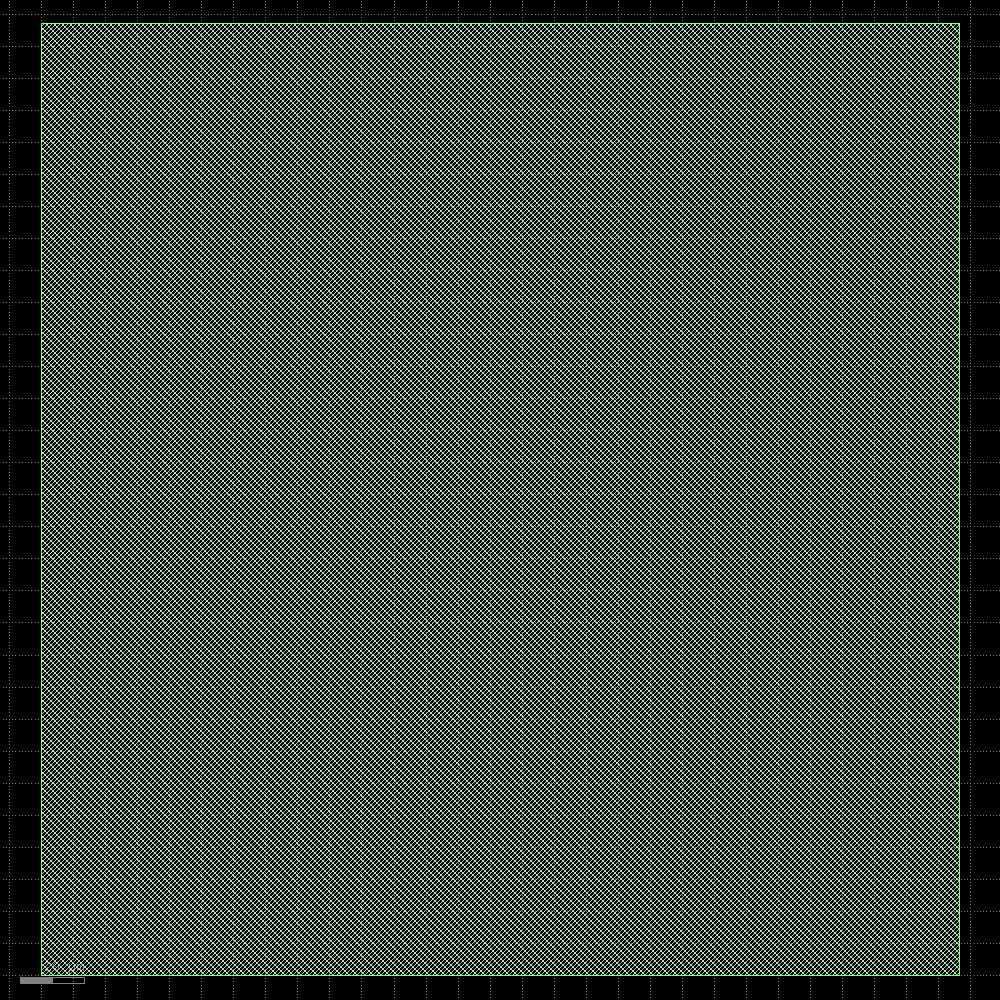

In [156]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [157]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[22:02:39] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=713052;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=523427;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:39] VERBOSE  Logging subprocess to                                                              ]8;id=252156;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=603154;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=211022;file:///content/openlane_run/68-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=657618;file:///content/openlane_run/68-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\68]8;;\]8;id=211022;file:///content/openlane_run/68-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                   

Reading OpenROAD database at '/content/openlane_run/67-openroad-floorplan/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 202 endcaps.

[INFO TAP-0005] Inserted 1081 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 4996, 'design__instance__area': Decimal('39275.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 133, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 4996, 'design__instance__area__stdcell': Decimal('39275.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.519719'), 'design__instance__utilization__stdcell': Decimal('0.519719')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:02:41] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=132229;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=747164;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:41] VERBOSE  Logging subprocess to ]8;id=193216;file:///tmp/openlane_klayout_tmp_oiw2dlz_/klayout-render.log\..]8;;\]8;id=244636;file:///tmp/openlane_klayout_tmp_oiw2dlz_/klayout-render.log\/tmp/openlane_klayout_tmp_oiw2dlz_/]8;;\]8;id=101734;file:///tmp/openlane_klayout_tmp_oiw2dlz_/klayout-render.log\klayout-render.log]8;;\…     ]8;id=945377;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=362328;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.53s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
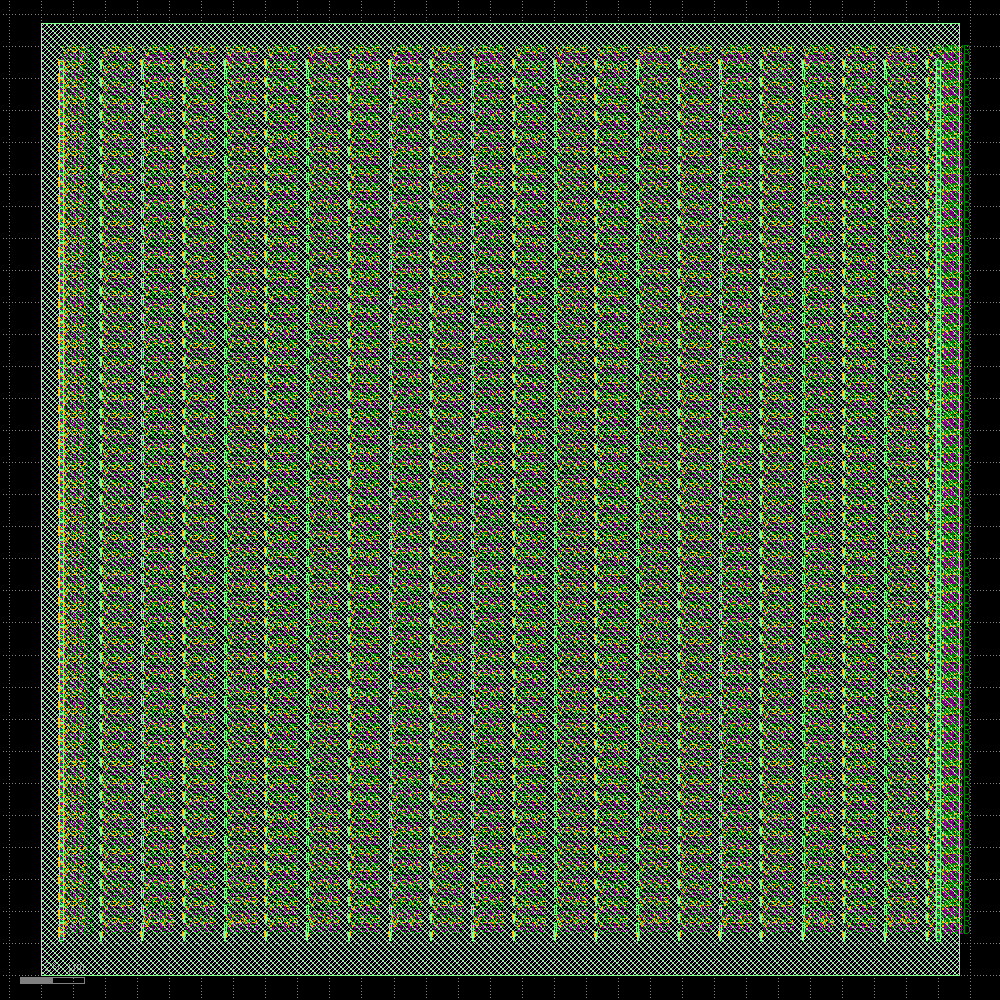

In [158]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [159]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[22:02:42] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=59650;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=45321;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:42] VERBOSE  Logging subprocess to                                                              ]8;id=867301;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=748496;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=744164;file:///content/openlane_run/69-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=634185;file:///content/openlane_run/69-openroad-ioplacement/openroad-ioplacement.log\69]8;;\]8;id=744164;file:///content/openlane_run/69-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/68-openroad-tapendcapinsertion/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           354

[INFO PPL-0002] Number of I/O             133

[INFO PPL-0003] Number of I/O w/sink      133

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 27352.42 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/69-openroad-ioplacement/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/69-openroad-ioplacement/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/69-openroad-ioplacement/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/69-openroad-ioplacement/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/69-openroad-ioplacement/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/69-openroad-ioplacement/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/69-openroad-ioplacement/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/69-openroad-ioplacement/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/69-openroad-ioplacement/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/69-openroad-ioplacement/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 4996, 'design__instance__area': Decimal('39275.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 133, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 4996, 'design__instance__area__stdcell': Decimal('39275.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.519719'), 'design__instance__utilization__stdcell': Decimal('0.519719'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:02:44] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=845189;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=422000;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:44] VERBOSE  Logging subprocess to ]8;id=503105;file:///tmp/openlane_klayout_tmp_nhamkya1/klayout-render.log\..]8;;\]8;id=48085;file:///tmp/openlane_klayout_tmp_nhamkya1/klayout-render.log\/tmp/openlane_klayout_tmp_nhamkya1/]8;;\]8;id=759389;file:///tmp/openlane_klayout_tmp_nhamkya1/klayout-render.log\klayout-render.log]8;;\…     ]8;id=603992;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=942699;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.63s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
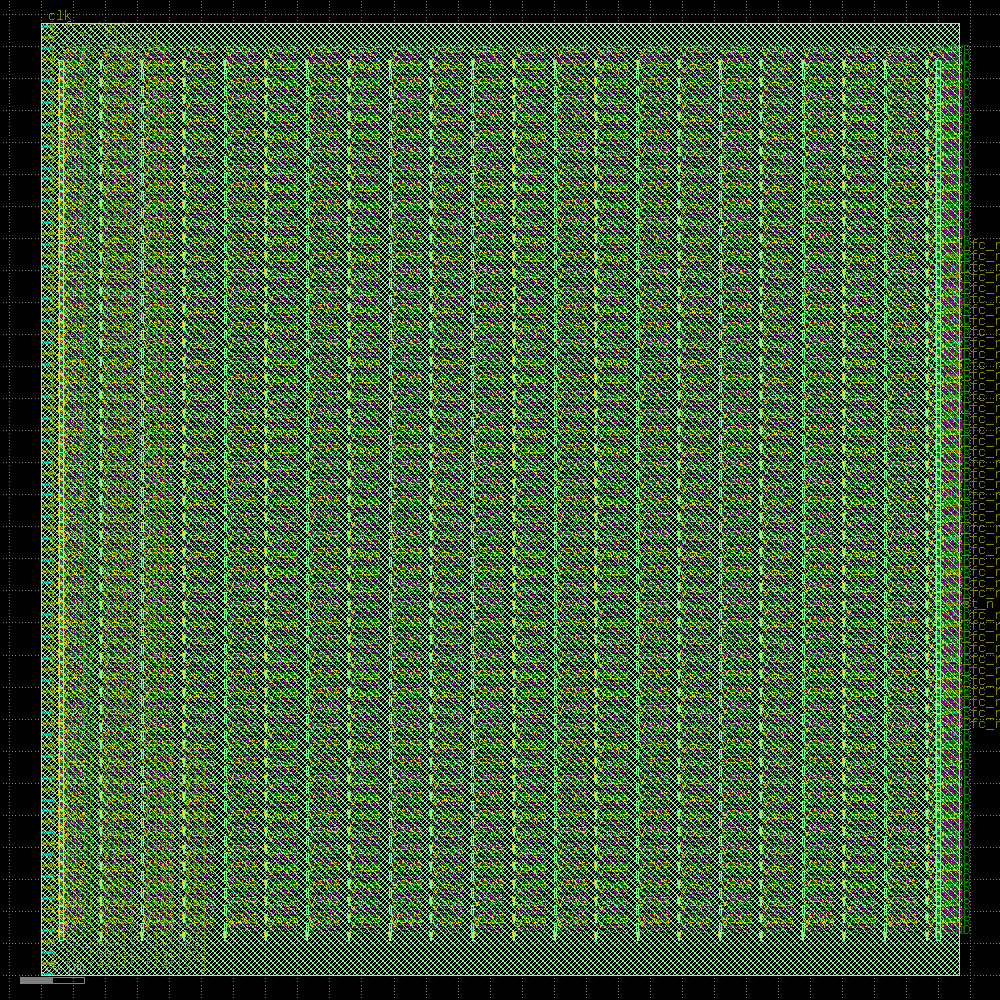

In [160]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [161]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out, # This should be the state after IOPlacement (which was after the new Floorplan)
    FP_PDN_VOFFSET=2,
    FP_PDN_HOFFSET=2,
    FP_PDN_VWIDTH=1.6,       # Correct for met5 min width
    FP_PDN_HWIDTH=1.6,       # Correct for met5 min width
    FP_PDN_VPITCH=25,        # Make pitch reasonably large, larger than the expected core dimension
    FP_PDN_HPITCH=25,        # Make pitch reasonably large
    FP_PDN_CORE_RING_VWIDTH=1.6,
    FP_PDN_CORE_RING_HWIDTH=1.6
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[22:02:45] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=756630;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=527497;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:45] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=868906;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=845371;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[22:02:45] VERBOSE  Logging subprocess to                                                              ]8;id=220818;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=526416;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=701072;file:///content/openlane_run/70-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=683753;file:///content/openlane_run/70-openroad-generatepdn/openroad-generatepdn.log\70]8;;\]8;id=701072;file:///content/openlane_run/70-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/69-openroad-ioplacement/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/70-openroad-generatepdn/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/70-openroad-generatepdn/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/70-openroad-generatepdn/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/70-openroad-generatepdn/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/70-openroad-generatepdn/test_fc_top.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/openlane_run/70-openroad-generatepdn/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/70-openroad-generatepdn/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/70-openroad-generatepdn/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/70-openroad-generatepdn/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/70-openroad-generatepdn/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 4996, 'design__instance__area': Decimal('39275.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 4996, 'design__instance__area__stdcell': Decimal('39275.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.519719'), 'design__instance__utilization__stdcell': Decimal('0.519719'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:02:47] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=987504;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=964053;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:47] VERBOSE  Logging subprocess to ]8;id=968863;file:///tmp/openlane_klayout_tmp_3rx8t4nq/klayout-render.log\..]8;;\]8;id=831968;file:///tmp/openlane_klayout_tmp_3rx8t4nq/klayout-render.log\/tmp/openlane_klayout_tmp_3rx8t4nq/]8;;\]8;id=117800;file:///tmp/openlane_klayout_tmp_3rx8t4nq/klayout-render.log\klayout-render.log]8;;\…     ]8;id=516868;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=116520;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.14s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
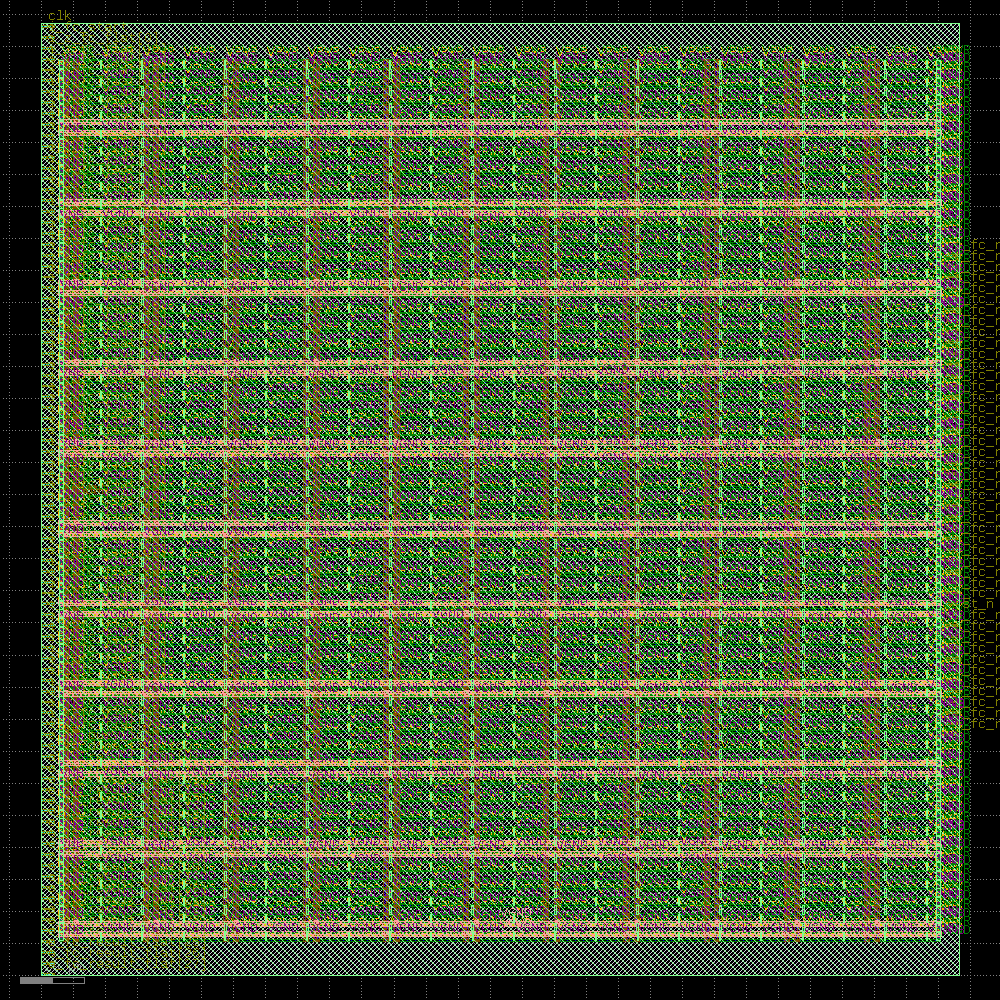

In [162]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [163]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[22:02:49] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=992193;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=744649;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:02:49] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=571645;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=458501;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 61.971900…                                                                     

[22:02:49] VERBOSE  Logging subprocess to                                                              ]8;id=568593;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=664142;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=366440;file:///content/openlane_run/71-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=784761;file:///content/openlane_run/71-openroad-globalplacement/openroad-globalplacement.log\71]8;;\]8;id=366440;file:///content/openlane_run/71-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/70-openroad-generatepdn/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 280.600 285.600 ) um

[INFO GPL-0006] NumInstances:              5198

[INFO GPL-0007] NumPlaceInstances:         3915

[INFO GPL-0008] NumFixedInstances:         1283

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                   3982

[INFO GPL-0011] NumPins:                  13262

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 286.440 297.160 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 280.600 285.600 ) um

[INFO GPL-0016] CoreArea:             75569.978 um^2

[INFO GPL-0017] NonPlaceInstsArea:     2110.774 um^2

[INFO GPL-0018] PlaceInstsArea:       37922.621 um^2

[INFO GPL-0019] Util:                    51.624 %

[INFO GPL-0020] StdInstsArea:         37922.621 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00027952 HPWL: 61670340

[InitialPlace]  Iter: 2 CG residual: 0.00004794 HPWL: 56788937

[InitialPlace]  Iter: 3 CG residual: 0.00019437 HPWL: 55403122

[InitialPlace]  Iter: 4 CG residual: 0.00039028 HPWL: 54550761

[InitialPlace]  Iter: 5 CG residual: 0.00001092 HPWL: 53732286

[InitialPlace]  Iter: 6 CG residual: 0.00000308 HPWL: 53423003

[INFO GPL-0031] FillerInit:NumGCells:      4723

[INFO GPL-0032] FillerInit:NumGNets:       3982

[INFO GPL-0033] FillerInit:NumGPins:      13262

[INFO GPL-0023] TargetDensity:            0.620

[INFO GPL-0024] AvrgPlaceInstArea:        9.686 um^2

[INFO GPL-0025] IdealBinArea:            15.630 um^2

[INFO GPL-0026] IdealBinCnt:               4834

[INFO GPL-0027] TotalBinArea:         75569.978 um^2

[INFO GPL-0028] BinCnt:        64     64

[INFO GPL-0029] BinSize: (  4.299  4.293 )

[INFO GPL-0030] NumBins: 4096

[NesterovSolve] Iter:    1 overflow: 0.968 HPWL: 32403543

[NesterovSolve] Iter:   10 overflow: 0.898 HPWL: 39491675

[NesterovSolve] Iter:   20 overflow: 0.863 HPWL: 44305434

[NesterovSolve] Iter:   30 overflow: 0.850 HPWL: 47802223

[NesterovSolve] Iter:   40 overflow: 0.847 HPWL: 48006718

[NesterovSolve] Iter:   50 overflow: 0.851 HPWL: 47283983

[NesterovSolve] Iter:   60 overflow: 0.855 HPWL: 47337506

[NesterovSolve] Iter:   70 overflow: 0.855 HPWL: 47791975

[NesterovSolve] Iter:   80 overflow: 0.855 HPWL: 48094113

[NesterovSolve] Iter:   90 overflow: 0.855 HPWL: 48028884

[NesterovSolve] Iter:  100 overflow: 0.856 HPWL: 47825622

[NesterovSolve] Iter:  110 overflow: 0.856 HPWL: 47767717

[NesterovSolve] Iter:  120 overflow: 0.855 HPWL: 47879826

[NesterovSolve] Iter:  130 overflow: 0.855 HPWL: 47952392

[NesterovSolve] Iter:  140 overflow: 0.855 HPWL: 47926514

[NesterovSolve] Iter:  150 overflow: 0.854 HPWL: 47921869

[NesterovSolve] Iter:  160 overflow: 0.853 HPWL: 48052687

[NesterovSolve] Iter:  170 overflow: 0.851 HPWL: 48366472

[NesterovSolve] Iter:  180 overflow: 0.848 HPWL: 48884612

[NesterovSolve] Iter:  190 overflow: 0.843 HPWL: 49699685

[NesterovSolve] Iter:  200 overflow: 0.836 HPWL: 50935426

[NesterovSolve] Iter:  210 overflow: 0.825 HPWL: 52672827

[NesterovSolve] Iter:  220 overflow: 0.811 HPWL: 54814844

[NesterovSolve] Iter:  230 overflow: 0.787 HPWL: 57227434

[INFO GPL-0100] worst slack 7.23e-08

[INFO GPL-0103] Weighted 397 nets.

[NesterovSolve] Iter:  240 overflow: 0.758 HPWL: 59607333

[NesterovSolve] Iter:  250 overflow: 0.722 HPWL: 62082197

[NesterovSolve] Iter:  260 overflow: 0.685 HPWL: 64333514

[NesterovSolve] Iter:  270 overflow: 0.645 HPWL: 66591315

[INFO GPL-0100] worst slack 7.23e-08

[INFO GPL-0103] Weighted 398 nets.

[NesterovSolve] Iter:  280 overflow: 0.601 HPWL: 68392661

[NesterovSolve] Snapshot saved at iter = 280

[NesterovSolve] Iter:  290 overflow: 0.557 HPWL: 69958345

[NesterovSolve] Iter:  300 overflow: 0.511 HPWL: 71666352

[INFO GPL-0100] worst slack 7.22e-08

[INFO GPL-0103] Weighted 398 nets.

[NesterovSolve] Iter:  310 overflow: 0.465 HPWL: 72969477

[NesterovSolve] Iter:  320 overflow: 0.422 HPWL: 73853367

[NesterovSolve] Iter:  330 overflow: 0.390 HPWL: 74268658

[NesterovSolve] Iter:  340 overflow: 0.350 HPWL: 74206245

[NesterovSolve] Iter:  350 overflow: 0.320 HPWL: 74397404

[NesterovSolve] Iter:  360 overflow: 0.296 HPWL: 74663663

[INFO GPL-0100] worst slack 7.23e-08

[INFO GPL-0103] Weighted 398 nets.

[NesterovSolve] Iter:  370 overflow: 0.271 HPWL: 74799809

[NesterovSolve] Iter:  380 overflow: 0.249 HPWL: 75016788

[NesterovSolve] Iter:  390 overflow: 0.224 HPWL: 75190439

[INFO GPL-0100] worst slack 7.23e-08

[INFO GPL-0103] Weighted 398 nets.

[NesterovSolve] Iter:  400 overflow: 0.203 HPWL: 75306323

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0.13333344459533691

[INFO GPL-0065] OverflowTileCnt2: 2

[INFO GPL-0066] 0.5%RC: 1.0078

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9858

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0039

[INFO GPL-0078] FinalRC lower than minRC (1e+30), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:       26.241 um^2

[INFO GPL-0046] TargetDensity:            0.620

[INFO GPL-0049] WhiteSpaceArea:       73459.203 um^2

[INFO GPL-0050] NesterovInstsArea:    37922.621 um^2

[INFO GPL-0051] TotalFillerArea:       7601.446 um^2

[INFO GPL-0052] TotalGCellsArea:      45524.066 um^2

[INFO GPL-0053] ExpectedGCellsArea:   45550.307 um^2

[INFO GPL-0054] NewTargetDensity:         0.620

[INFO GPL-0055] NewWhiteSpaceArea:    73459.203 um^2

[INFO GPL-0056] MovableArea:          45550.305 um^2

[INFO GPL-0057] NewNesterovInstArea:  37948.862 um^2

[INFO GPL-0058] NewTotalFillerArea:    7601.444 um^2

[INFO GPL-0059] NewTotalGCellsArea:   45550.305 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  410 overflow: 0.567 HPWL: 69789048

[NesterovSolve] Iter:  420 overflow: 0.532 HPWL: 70886982

[NesterovSolve] Iter:  430 overflow: 0.493 HPWL: 71881126

[NesterovSolve] Iter:  440 overflow: 0.456 HPWL: 72400826

[NesterovSolve] Iter:  450 overflow: 0.429 HPWL: 73075766

[NesterovSolve] Iter:  460 overflow: 0.400 HPWL: 73429643

[NesterovSolve] Iter:  470 overflow: 0.370 HPWL: 73496105

[NesterovSolve] Iter:  480 overflow: 0.339 HPWL: 73624102

[NesterovSolve] Iter:  490 overflow: 0.316 HPWL: 74082243

[NesterovSolve] Iter:  500 overflow: 0.288 HPWL: 74272112

[NesterovSolve] Iter:  510 overflow: 0.262 HPWL: 74534855

[NesterovSolve] Iter:  520 overflow: 0.241 HPWL: 74735965

[NesterovSolve] Iter:  530 overflow: 0.217 HPWL: 74952021

[INFO GPL-0075] Routability numCall: 2 inflationIterCnt: 2 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0.10000002384185791

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 1

[INFO GPL-0066] 0.5%RC: 1.0042

[INFO GPL-0067] 1.0%RC: 1.0021

[INFO GPL-0068] 2.0%RC: 1.0010

[INFO GPL-0069] 5.0%RC: 0.9831

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0031

[INFO GPL-0078] FinalRC lower than minRC (1.0039216), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:       30.266 um^2

[INFO GPL-0046] TargetDensity:            0.620

[INFO GPL-0049] WhiteSpaceArea:       73459.203 um^2

[INFO GPL-0050] NesterovInstsArea:    37948.862 um^2

[INFO GPL-0051] TotalFillerArea:       7601.444 um^2

[INFO GPL-0052] TotalGCellsArea:      45550.305 um^2

[INFO GPL-0053] ExpectedGCellsArea:   45580.572 um^2

[INFO GPL-0054] NewTargetDensity:         0.620

[INFO GPL-0055] NewWhiteSpaceArea:    73459.203 um^2

[INFO GPL-0056] MovableArea:          45580.571 um^2

[INFO GPL-0057] NewNesterovInstArea:  37979.128 um^2

[INFO GPL-0058] NewTotalFillerArea:    7601.443 um^2

[INFO GPL-0059] NewTotalGCellsArea:   45580.571 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  540 overflow: 0.589 HPWL: 68904648

[NesterovSolve] Iter:  550 overflow: 0.551 HPWL: 70254213

[NesterovSolve] Iter:  560 overflow: 0.518 HPWL: 71402262

[NesterovSolve] Iter:  570 overflow: 0.477 HPWL: 72086095

[NesterovSolve] Iter:  580 overflow: 0.443 HPWL: 72691884

[NesterovSolve] Iter:  590 overflow: 0.418 HPWL: 73261317

[NesterovSolve] Iter:  600 overflow: 0.392 HPWL: 73505106

[NesterovSolve] Iter:  610 overflow: 0.358 HPWL: 73512817

[NesterovSolve] Iter:  620 overflow: 0.330 HPWL: 73829328

[NesterovSolve] Iter:  630 overflow: 0.304 HPWL: 74266334

[NesterovSolve] Iter:  640 overflow: 0.279 HPWL: 74402726

[NesterovSolve] Iter:  650 overflow: 0.255 HPWL: 74652877

[NesterovSolve] Iter:  660 overflow: 0.230 HPWL: 74891151

[NesterovSolve] Iter:  670 overflow: 0.207 HPWL: 75081345

[INFO GPL-0075] Routability numCall: 3 inflationIterCnt: 3 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0.10000002384185791

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 1

[INFO GPL-0066] 0.5%RC: 1.0042

[INFO GPL-0067] 1.0%RC: 1.0021

[INFO GPL-0068] 2.0%RC: 1.0010

[INFO GPL-0069] 5.0%RC: 0.9776

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0031

[INFO GPL-0079] MinRC (1.003125) violation occurred, total count: 1.

[INFO GPL-0045] InflatedAreaDelta:       35.163 um^2

[INFO GPL-0046] TargetDensity:            0.620

[INFO GPL-0049] WhiteSpaceArea:       73459.203 um^2

[INFO GPL-0050] NesterovInstsArea:    37979.128 um^2

[INFO GPL-0051] TotalFillerArea:       7601.443 um^2

[INFO GPL-0052] TotalGCellsArea:      45580.571 um^2

[INFO GPL-0053] ExpectedGCellsArea:   45615.734 um^2

[INFO GPL-0054] NewTargetDensity:         0.621

[INFO GPL-0055] NewWhiteSpaceArea:    73459.203 um^2

[INFO GPL-0056] MovableArea:          45615.735 um^2

[INFO GPL-0057] NewNesterovInstArea:  38014.291 um^2

[INFO GPL-0058] NewTotalFillerArea:    7601.444 um^2

[INFO GPL-0059] NewTotalGCellsArea:   45615.735 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  680 overflow: 0.573 HPWL: 69569032

[NesterovSolve] Iter:  690 overflow: 0.538 HPWL: 70683530

[NesterovSolve] Iter:  700 overflow: 0.501 HPWL: 71796807

[NesterovSolve] Iter:  710 overflow: 0.462 HPWL: 72315877

[NesterovSolve] Iter:  720 overflow: 0.434 HPWL: 72942107

[NesterovSolve] Iter:  730 overflow: 0.407 HPWL: 73389001

[NesterovSolve] Iter:  740 overflow: 0.376 HPWL: 73604647

[NesterovSolve] Iter:  750 overflow: 0.343 HPWL: 73590780

[NesterovSolve] Iter:  760 overflow: 0.319 HPWL: 74061757

[NesterovSolve] Iter:  770 overflow: 0.293 HPWL: 74332833

[NesterovSolve] Iter:  780 overflow: 0.266 HPWL: 74514204

[NesterovSolve] Iter:  790 overflow: 0.242 HPWL: 74780221

[NesterovSolve] Iter:  800 overflow: 0.220 HPWL: 74985017

[INFO GPL-0075] Routability numCall: 4 inflationIterCnt: 4 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9757

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0078] FinalRC lower than minRC (1.003125), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.621

[INFO GPL-0049] WhiteSpaceArea:       73459.203 um^2

[INFO GPL-0050] NesterovInstsArea:    38014.291 um^2

[INFO GPL-0051] TotalFillerArea:       7601.444 um^2

[INFO GPL-0052] TotalGCellsArea:      45615.735 um^2

[INFO GPL-0053] ExpectedGCellsArea:   45615.735 um^2

[INFO GPL-0054] NewTargetDensity:         0.621

[INFO GPL-0055] NewWhiteSpaceArea:    73459.203 um^2

[INFO GPL-0056] MovableArea:          45615.735 um^2

[INFO GPL-0057] NewNesterovInstArea:  38014.291 um^2

[INFO GPL-0058] NewTotalFillerArea:    7601.444 um^2

[INFO GPL-0059] NewTotalGCellsArea:   45615.735 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  810 overflow: 0.593 HPWL: 68726698

[NesterovSolve] Iter:  820 overflow: 0.555 HPWL: 70150661

[NesterovSolve] Iter:  830 overflow: 0.522 HPWL: 71282869

[NesterovSolve] Iter:  840 overflow: 0.480 HPWL: 72038884

[NesterovSolve] Iter:  850 overflow: 0.448 HPWL: 72604294

[NesterovSolve] Iter:  860 overflow: 0.420 HPWL: 73226756

[NesterovSolve] Iter:  870 overflow: 0.394 HPWL: 73476783

[NesterovSolve] Iter:  880 overflow: 0.362 HPWL: 73523589

[NesterovSolve] Iter:  890 overflow: 0.332 HPWL: 73751478

[NesterovSolve] Iter:  900 overflow: 0.306 HPWL: 74234332

[NesterovSolve] Iter:  910 overflow: 0.281 HPWL: 74371763

[NesterovSolve] Iter:  920 overflow: 0.255 HPWL: 74584170

[NesterovSolve] Iter:  930 overflow: 0.231 HPWL: 74897945

[NesterovSolve] Iter:  940 overflow: 0.208 HPWL: 75098047

[INFO GPL-0075] Routability numCall: 5 inflationIterCnt: 0 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9757

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 1.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.621

[INFO GPL-0049] WhiteSpaceArea:       73459.203 um^2

[INFO GPL-0050] NesterovInstsArea:    38014.291 um^2

[INFO GPL-0051] TotalFillerArea:       7601.444 um^2

[INFO GPL-0052] TotalGCellsArea:      45615.735 um^2

[INFO GPL-0053] ExpectedGCellsArea:   45615.735 um^2

[INFO GPL-0054] NewTargetDensity:         0.621

[INFO GPL-0055] NewWhiteSpaceArea:    73459.203 um^2

[INFO GPL-0056] MovableArea:          45615.735 um^2

[INFO GPL-0057] NewNesterovInstArea:  38014.291 um^2

[INFO GPL-0058] NewTotalFillerArea:    7601.444 um^2

[INFO GPL-0059] NewTotalGCellsArea:   45615.735 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  950 overflow: 0.573 HPWL: 69569032

[NesterovSolve] Iter:  960 overflow: 0.538 HPWL: 70683530

[NesterovSolve] Iter:  970 overflow: 0.501 HPWL: 71796807

[NesterovSolve] Iter:  980 overflow: 0.462 HPWL: 72315877

[NesterovSolve] Iter:  990 overflow: 0.434 HPWL: 72942107

[NesterovSolve] Iter: 1000 overflow: 0.407 HPWL: 73389001

[NesterovSolve] Iter: 1010 overflow: 0.376 HPWL: 73604647

[NesterovSolve] Iter: 1020 overflow: 0.343 HPWL: 73590780

[NesterovSolve] Iter: 1030 overflow: 0.319 HPWL: 74061757

[NesterovSolve] Iter: 1040 overflow: 0.293 HPWL: 74332833

[NesterovSolve] Iter: 1050 overflow: 0.266 HPWL: 74514204

[NesterovSolve] Iter: 1060 overflow: 0.242 HPWL: 74780221

[NesterovSolve] Iter: 1070 overflow: 0.220 HPWL: 74985017

[INFO GPL-0075] Routability numCall: 6 inflationIterCnt: 1 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9757

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 2.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.621

[INFO GPL-0049] WhiteSpaceArea:       73459.203 um^2

[INFO GPL-0050] NesterovInstsArea:    38014.291 um^2

[INFO GPL-0051] TotalFillerArea:       7601.444 um^2

[INFO GPL-0052] TotalGCellsArea:      45615.735 um^2

[INFO GPL-0053] ExpectedGCellsArea:   45615.735 um^2

[INFO GPL-0054] NewTargetDensity:         0.621

[INFO GPL-0055] NewWhiteSpaceArea:    73459.203 um^2

[INFO GPL-0056] MovableArea:          45615.735 um^2

[INFO GPL-0057] NewNesterovInstArea:  38014.291 um^2

[INFO GPL-0058] NewTotalFillerArea:    7601.444 um^2

[INFO GPL-0059] NewTotalGCellsArea:   45615.735 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1080 overflow: 0.593 HPWL: 68726698

[NesterovSolve] Iter: 1090 overflow: 0.555 HPWL: 70150661

[NesterovSolve] Iter: 1100 overflow: 0.522 HPWL: 71282869

[NesterovSolve] Iter: 1110 overflow: 0.480 HPWL: 72038884

[NesterovSolve] Iter: 1120 overflow: 0.448 HPWL: 72604294

[NesterovSolve] Iter: 1130 overflow: 0.420 HPWL: 73226756

[NesterovSolve] Iter: 1140 overflow: 0.394 HPWL: 73476783

[NesterovSolve] Iter: 1150 overflow: 0.362 HPWL: 73523589

[NesterovSolve] Iter: 1160 overflow: 0.332 HPWL: 73751478

[NesterovSolve] Iter: 1170 overflow: 0.306 HPWL: 74234332

[NesterovSolve] Iter: 1180 overflow: 0.281 HPWL: 74371763

[NesterovSolve] Iter: 1190 overflow: 0.255 HPWL: 74584170

[NesterovSolve] Iter: 1200 overflow: 0.231 HPWL: 74897945

[NesterovSolve] Iter: 1210 overflow: 0.208 HPWL: 75098047

[INFO GPL-0075] Routability numCall: 7 inflationIterCnt: 2 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      41   43

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 1763

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9757

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 3.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.621

Revert Routability Procedure. Target density higher than max, or minRC max violations.

[INFO GPL-0080] minRcViolatedCnt: 3

[INFO GPL-0047] SavedMinRC: 1.0000

[INFO GPL-0048] SavedTargetDensity: 0.6210

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1220 overflow: 0.573 HPWL: 69569032

[NesterovSolve] Iter: 1230 overflow: 0.538 HPWL: 70683530

[NesterovSolve] Iter: 1240 overflow: 0.501 HPWL: 71796807

[NesterovSolve] Iter: 1250 overflow: 0.462 HPWL: 72315877

[NesterovSolve] Iter: 1260 overflow: 0.434 HPWL: 72942107

[NesterovSolve] Iter: 1270 overflow: 0.407 HPWL: 73389001

[NesterovSolve] Iter: 1280 overflow: 0.376 HPWL: 73604647

[NesterovSolve] Iter: 1290 overflow: 0.343 HPWL: 73590780

[NesterovSolve] Iter: 1300 overflow: 0.319 HPWL: 74061757

[NesterovSolve] Iter: 1310 overflow: 0.293 HPWL: 74332833

[NesterovSolve] Iter: 1320 overflow: 0.266 HPWL: 74514204

[NesterovSolve] Iter: 1330 overflow: 0.242 HPWL: 74780221

[NesterovSolve] Iter: 1340 overflow: 0.220 HPWL: 74985017

[NesterovSolve] Iter: 1350 overflow: 0.197 HPWL: 75248040

[NesterovSolve] Iter: 1360 overflow: 0.179 HPWL: 75442535

[NesterovSolve] Iter: 1370 overflow: 0.159 HPWL: 75610250

[NesterovSolve] Iter: 1380 overflow: 0.144 HPWL: 75817912

[INFO GPL-0100] worst slack 7.23e-08

[INFO GPL-0103] Weighted 397 nets.

[NesterovSolve] Iter: 1390 overflow: 0.127 HPWL: 76040887

[NesterovSolve] Iter: 1400 overflow: 0.111 HPWL: 76279935

[NesterovSolve] Finished with Overflow: 0.098287

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/71-openroad-globalplacement/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/71-openroad-globalplacement/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/71-openroad-globalplacement/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/71-openroad-globalplacement/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/71-openroad-globalplacement/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/71-openroad-globalplacement/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/71-openroad-globalplacement/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/71-openroad-globalplacement/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/71-openroad-globalplacement/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/71-openroad-globalplacement/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 4996, 'design__instance__area': Decimal('39275.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 4996, 'design__instance__area__stdcell': Decimal('39275.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.519719'), 'design__instance__utilization__stdcell': Decimal('0.519719'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:03:14] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=977792;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=724709;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:14] VERBOSE  Logging subprocess to ]8;id=600858;file:///tmp/openlane_klayout_tmp_j_v1himm/klayout-render.log\..]8;;\]8;id=493002;file:///tmp/openlane_klayout_tmp_j_v1himm/klayout-render.log\/tmp/openlane_klayout_tmp_j_v1himm/]8;;\]8;id=746427;file:///tmp/openlane_klayout_tmp_j_v1himm/klayout-render.log\klayout-render.log]8;;\…     ]8;id=329655;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=346679;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 24.99s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
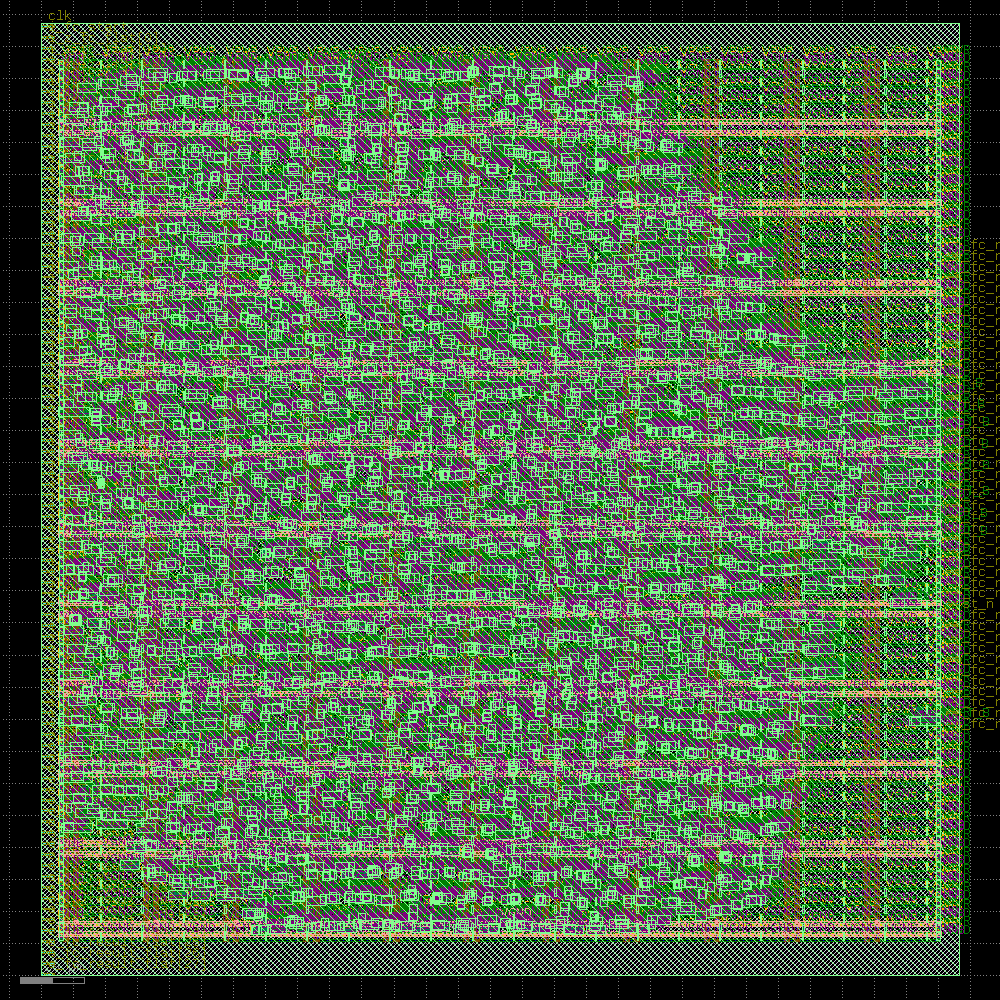

In [164]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [165]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[22:03:16] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=981060;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=454906;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:16] VERBOSE  Logging subprocess to                                                              ]8;id=592966;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=967123;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=993667;file:///content/openlane_run/72-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=251825;file:///content/openlane_run/72-openroad-detailedplacement/openroad-detailedplacement.log\72]8;;\]8;id=993667;file:///content/openlane_run/72-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                     

Reading OpenROAD database at '/content/openlane_run/71-openroad-globalplacement/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement       8523.0 u

average displacement        1.6 u

max displacement            8.7 u

original HPWL           76404.4 u

legalized HPWL          85303.8 u

delta HPWL                   12 %

[INFO DPL-0020] Mirrored 1357 instances

[INFO DPL-0021] HPWL before           85303.8 u

[INFO DPL-0022] HPWL after            82685.0 u

[INFO DPL-0023] HPWL delta               -3.1 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/72-openroad-detailedplacement/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/72-openroad-detailedplacement/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/72-openroad-detailedplacement/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/72-openroad-detailedplacement/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/72-openroad-detailedplacement/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/72-openroad-detailedplacement/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/72-openroad-detailedplacement/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/72-openroad-detailedplacement/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/72-openroad-detailedplacement/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/72-openroad-detailedplacement/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 4996, 'design__instance__area': Decimal('39275.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 4996, 'design__instance__area__stdcell': Decimal('39275.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.519719'), 'design__instance__utilization__stdcell': Decimal('0.519719'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('8523.04'), 'design__instance__displacement__mean': Decimal('1.639'), 'design__instance__displacement__max': Decimal('8.713'), 'route__wirelength__estimated': Decimal('85303.8'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:03:18] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=417945;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=812403;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:18] VERBOSE  Logging subprocess to ]8;id=724433;file:///tmp/openlane_klayout_tmp_z70nkhxn/klayout-render.log\..]8;;\]8;id=375376;file:///tmp/openlane_klayout_tmp_z70nkhxn/klayout-render.log\/tmp/openlane_klayout_tmp_z70nkhxn/]8;;\]8;id=727123;file:///tmp/openlane_klayout_tmp_z70nkhxn/klayout-render.log\klayout-render.log]8;;\…     ]8;id=868533;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=776911;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.54s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
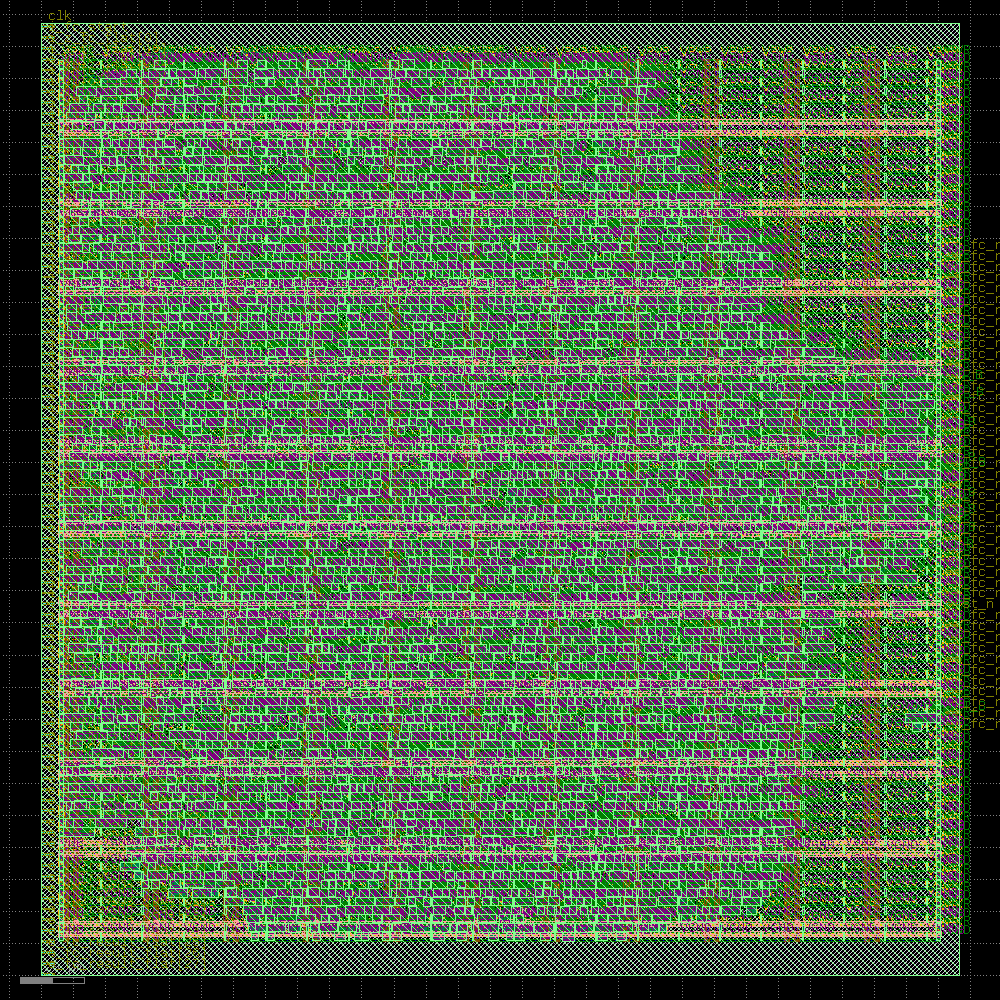

In [166]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [167]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[22:03:19] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=674568;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=299904;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:19] VERBOSE  Logging subprocess to ]8;id=148832;file:///content/openlane_run/73-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=362706;file:///content/openlane_run/73-openroad-cts/openroad-cts.log\73]8;;\]8;id=148832;file:///content/openlane_run/73-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…               ]8;id=155054;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=365546;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/72-openroad-detailedplacement/test_fc_top.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 65 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 65.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(7165, 44820), (269825, 197140)].

[INFO CTS-0024]  Normalized sink region: [(0.526838, 3.29559), (19.8401, 14.4956)].

[INFO CTS-0025]     Width:  19.3132.

[INFO CTS-0026]     Height: 11.2000.

Level 1

Direction: Horizontal

Sinks per sub-region: 33

Sub-region size: 9.6566 X 11.2000

[INFO CTS-0034]     Segment length (rounded): 4.

Level 2

Direction: Vertical

Sinks per sub-region: 17

Sub-region size: 9.6566 X 5.6000

[INFO CTS-0034]     Segment length (rounded): 2.

Level 3

Direction: Horizontal

Sinks per sub-region: 9

Sub-region size: 4.8283 X 5.6000

[INFO CTS-0034]     Segment length (rounded): 2.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 65.

[INFO CTS-0018]     Created 9 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 9 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 5:2, 6:1, 7:1, 9:1, 10:1, 11:1, 12:1..

[INFO CTS-0017]     Max level of the clock tree: 3.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 72

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 465.32 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 7

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/73-openroad-cts/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/73-openroad-cts/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/73-openroad-cts/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/73-openroad-cts/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/73-openroad-cts/test_fc_top.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        143.2 u

average displacement        0.0 u

max displacement            9.2 u

original HPWL           83667.1 u

legalized HPWL          86424.9 u

delta HPWL                    3 %

[INFO DPL-0020] Mirrored 1365 instances

[INFO DPL-0021] HPWL before           86424.9 u

[INFO DPL-0022] HPWL after            83783.1 u

[INFO DPL-0023] HPWL delta               -3.1 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/73-openroad-cts/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/73-openroad-cts/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/73-openroad-cts/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/73-openroad-cts/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/73-openroad-cts/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/73-openroad-cts/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/73-openroad-cts/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/73-openroad-cts/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/73-openroad-cts/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/73-openroad-cts/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 33696, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('143.168'), 'design__instance__displacement__mean': Decimal('0.027'), 'design__instance__displacement__max': Decimal('9.2'), 'route__wirelength__estimated': Decimal('86424.9'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:03:34] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=782756;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=780246;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:34] VERBOSE  Logging subprocess to ]8;id=857339;file:///tmp/openlane_klayout_tmp_qtga6rum/klayout-render.log\..]8;;\]8;id=953593;file:///tmp/openlane_klayout_tmp_qtga6rum/klayout-render.log\/tmp/openlane_klayout_tmp_qtga6rum/]8;;\]8;id=155720;file:///tmp/openlane_klayout_tmp_qtga6rum/klayout-render.log\klayout-render.log]8;;\…     ]8;id=946562;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=594239;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 14.95s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
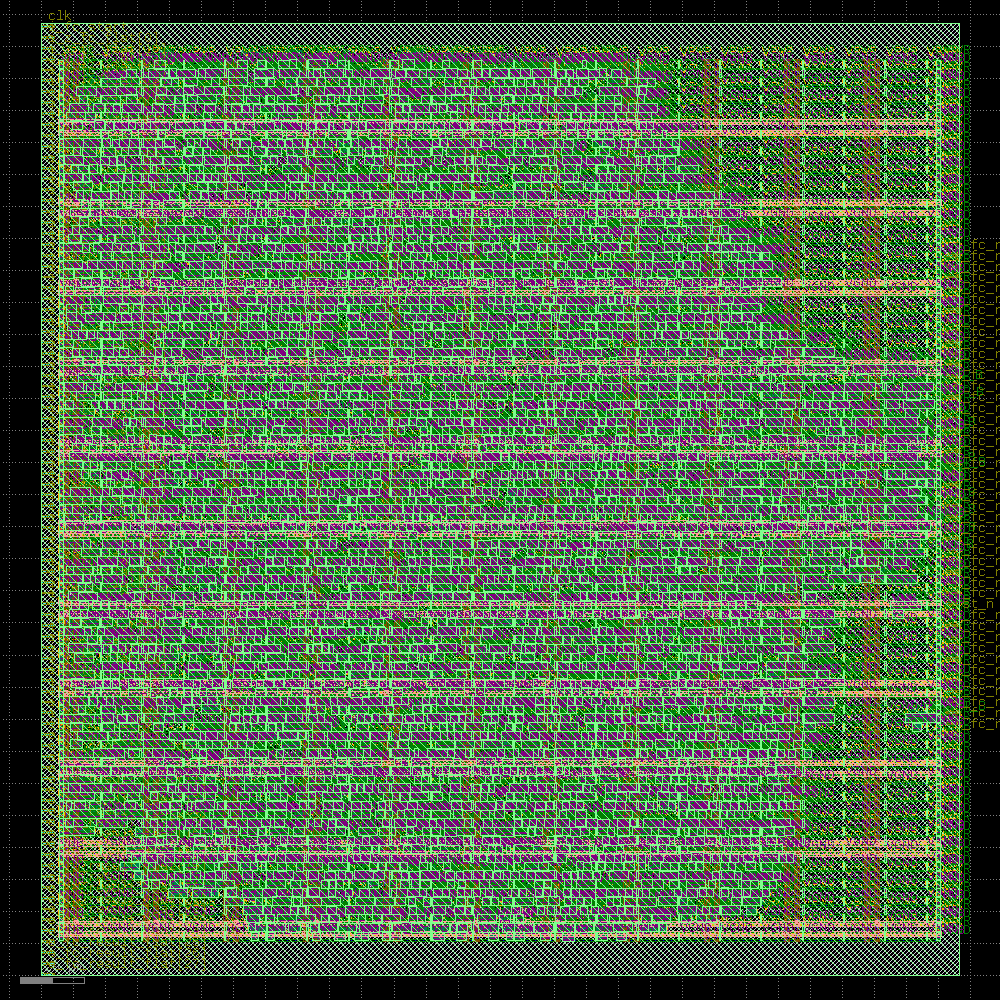

In [168]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [169]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[22:03:35] VERBOSE  Running 'OpenROAD.GlobalRouting'…                                                  ]8;id=469495;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=96859;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:35] VERBOSE  Logging subprocess to                                                              ]8;id=605431;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=432581;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=631282;file:///content/openlane_run/74-openroad-globalrouting/openroad-globalrouting.log\openlane_run/]8;;\]8;id=505476;file:///content/openlane_run/74-openroad-globalrouting/openroad-globalrouting.log\74]8;;\]8;id=631282;file:///content/openlane_run/74-openroad-globalrouting/openroad-globalrouting.log\-openroad-globalrouting/openroad-globalrouting.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/73-openroad-cts/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 10 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 69

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 4995

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal      35261         17165          51.32%

met2       Vertical        26776         17229          35.66%

met3       Horizontal      17610         11543          34.45%

met4       Vertical        10805          5374          50.26%

met5       Horizontal       3522          1400          60.25%

---------------------------------------------------------------

[INFO GRT-0101] Running extra iterations to remove overflow.

[INFO GRT-0197] Via related to pin nodes: 19198

[INFO GRT-0198] Via related Steiner nodes: 183

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 23233

[INFO GRT-0112] Final usage 3D: 82536

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1             17165          6405           37.31%             0 /  0 /  0

met2             17229          5893           34.20%             0 /  0 /  0

met3             11543           457            3.96%             0 /  0 /  0

met4              5374            82            1.53%             0 /  0 /  0

met5              1400             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total            52711         12837           24.35%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 141401 um

[INFO GRT-0014] Routed nets: 3991

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/74-openroad-globalrouting/test_fc_top.odb'…

Writing layout to '/content/openlane_run/74-openroad-globalrouting/test_fc_top.def'…

{'nl': Path('/content/openlane_run/73-openroad-cts/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/73-openroad-cts/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/74-openroad-globalrouting/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/74-openroad-globalrouting/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/73-openroad-cts/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('143.168'), 'design__instance__displacement__mean': Decimal('0.027'), 'design__instance__displacement__max': Decimal('9.2'), 'route__wirelength__estimated': Decimal('86424.9'), 'design__violations': 0, 'antenna__violating__nets': 8, 'antenna__violating__pins': 8}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [170]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[22:03:37] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=372553;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=493447;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:03:37] INFO     Running TritonRoute with 2 threads…                                            ]8;id=644980;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=389503;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[22:03:37] VERBOSE  Logging subprocess to                                                              ]8;id=726126;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=332801;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=525887;file:///content/openlane_run/75-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=662572;file:///content/openlane_run/75-openroad-detailedrouting/openroad-detailedrouting.log\75]8;;\]8;id=525887;file:///content/openlane_run/75-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/74-openroad-globalrouting/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=53537;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=458077;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=996811;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=160140;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=74533;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=147067;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=923428;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=277766;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=382374;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=605543;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=513420;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=814374;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=583606;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=15392;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=503381;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=830871;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=401148;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=528612;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[22:03:38] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=859488;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=397489;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   test_fc_top

Die area:                 ( 0 0 ) ( 286440 297160 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     5214

Number of terminals:      135

Number of snets:          2

Number of nets:           3991

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 196.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 116857.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 16288.

[INFO DRT-0033] via shape region query size = 5610.

[INFO DRT-0033] met2 shape region query size = 3366.

[INFO DRT-0033] via2 shape region query size = 4488.

[INFO DRT-0033] met3 shape region query size = 3499.

[INFO DRT-0033] via3 shape region query size = 4488.

[INFO DRT-0033] met4 shape region query size = 1408.

[INFO DRT-0033] via4 shape region query size = 242.

[INFO DRT-0033] met5 shape region query size = 286.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 788 pins.

[INFO DRT-0079]   Complete 100 unique inst patterns.

[INFO DRT-0081]   Complete 190 unique inst patterns.

[INFO DRT-0084]   Complete 2560 groups.

#scanned instances     = 5214

#unique  instances     = 196

#stdCellGenAp          = 5600

#stdCellValidPlanarAp  = 44

#stdCellValidViaAp     = 4392

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 13154

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:01:22, elapsed time = 00:00:51, memory = 140.96 (MB), peak = 249.95 (MB)

Number of guides:     24376

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 41 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 43 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 9158.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 6740.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 3101.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 169.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 12.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 12271 vertical wires in 1 frboxes and 6909 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 1126 vertical wires in 1 frboxes and 1957 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:02, elapsed time = 00:00:02, memory = 211.96 (MB), peak = 249.95 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 211.96 (MB), peak = 249.95 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:04, memory = 222.32 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:07, memory = 245.28 (MB).

Completing 30% with 144 violations.

elapsed time = 00:00:13, memory = 266.55 (MB).

Completing 40% with 144 violations.

elapsed time = 00:00:19, memory = 279.57 (MB).

Completing 50% with 144 violations.

elapsed time = 00:00:23, memory = 273.12 (MB).

Completing 60% with 384 violations.

elapsed time = 00:00:29, memory = 274.41 (MB).

Completing 70% with 384 violations.

elapsed time = 00:00:33, memory = 276.41 (MB).

Completing 80% with 595 violations.

elapsed time = 00:00:38, memory = 284.91 (MB).

Completing 90% with 595 violations.

elapsed time = 00:00:42, memory = 284.91 (MB).

Completing 100% with 814 violations.

elapsed time = 00:00:51, memory = 285.75 (MB).

[INFO DRT-0199]   Number of violations = 1130.

Viol/Layer         li1   met1   met2   met3

Metal Spacing       24    201     42      6

Min Hole             0      2      0      0

Recheck              0    214    101      1

Short                0    494     45      0

[INFO DRT-0267] cpu time = 00:01:23, elapsed time = 00:00:52, memory = 591.37 (MB), peak = 591.37 (MB)

Total wire length = 92779 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 46727 um.

Total wire length on LAYER met2 = 40701 um.

Total wire length on LAYER met3 = 4798 um.

Total wire length on LAYER met4 = 551 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 25305.

Up-via summary (total 25305):

------------------------

FR_MASTERSLICE        0

li1    12845

met1    12228

met2      211

met3       21

met4        0

------------------------

25305

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 1130 violations.

elapsed time = 00:00:05, memory = 591.37 (MB).

Completing 20% with 1130 violations.

elapsed time = 00:00:07, memory = 591.37 (MB).

Completing 30% with 1130 violations.

elapsed time = 00:00:07, memory = 606.89 (MB).

Completing 40% with 1012 violations.

elapsed time = 00:00:13, memory = 591.43 (MB).

Completing 50% with 1012 violations.

elapsed time = 00:00:21, memory = 591.43 (MB).

Completing 60% with 783 violations.

elapsed time = 00:00:25, memory = 591.43 (MB).

Completing 70% with 783 violations.

elapsed time = 00:00:28, memory = 591.43 (MB).

Completing 80% with 783 violations.

elapsed time = 00:00:31, memory = 591.43 (MB).

Completing 90% with 635 violations.

elapsed time = 00:00:40, memory = 591.43 (MB).

Completing 100% with 367 violations.

elapsed time = 00:00:47, memory = 591.43 (MB).

[INFO DRT-0199]   Number of violations = 367.

Viol/Layer        met1   met2

Metal Spacing       72     25

Min Hole             2      0

Recheck              1      0

Short              257     10

[INFO DRT-0267] cpu time = 00:01:15, elapsed time = 00:00:48, memory = 591.96 (MB), peak = 607.93 (MB)

Total wire length = 92096 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 46436 um.

Total wire length on LAYER met2 = 40354 um.

Total wire length on LAYER met3 = 4740 um.

Total wire length on LAYER met4 = 564 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 25078.

Up-via summary (total 25078):

------------------------

FR_MASTERSLICE        0

li1    12834

met1    12019

met2      203

met3       22

met4        0

------------------------

25078

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 367 violations.

elapsed time = 00:00:00, memory = 591.96 (MB).

Completing 20% with 367 violations.

elapsed time = 00:00:05, memory = 591.96 (MB).

Completing 30% with 367 violations.

elapsed time = 00:00:06, memory = 591.96 (MB).

Completing 40% with 333 violations.

elapsed time = 00:00:12, memory = 591.96 (MB).

Completing 50% with 333 violations.

elapsed time = 00:00:19, memory = 591.96 (MB).

Completing 60% with 329 violations.

elapsed time = 00:00:23, memory = 591.96 (MB).

Completing 70% with 329 violations.

elapsed time = 00:00:30, memory = 591.96 (MB).

Completing 80% with 329 violations.

elapsed time = 00:00:32, memory = 598.92 (MB).

Completing 90% with 335 violations.

elapsed time = 00:00:38, memory = 613.61 (MB).

Completing 100% with 318 violations.

elapsed time = 00:00:44, memory = 613.61 (MB).

[INFO DRT-0199]   Number of violations = 324.

Viol/Layer        met1   met2

Metal Spacing       68     23

Recheck              5      1

Short              211     16

[INFO DRT-0267] cpu time = 00:01:13, elapsed time = 00:00:45, memory = 614.39 (MB), peak = 614.39 (MB)

Total wire length = 91994 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 46385 um.

Total wire length on LAYER met2 = 40301 um.

Total wire length on LAYER met3 = 4734 um.

Total wire length on LAYER met4 = 573 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 25068.

Up-via summary (total 25068):

------------------------

FR_MASTERSLICE        0

li1    12834

met1    12015

met2      196

met3       23

met4        0

------------------------

25068

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 324 violations.

elapsed time = 00:00:01, memory = 614.39 (MB).

Completing 20% with 324 violations.

elapsed time = 00:00:03, memory = 614.39 (MB).

Completing 30% with 237 violations.

elapsed time = 00:00:06, memory = 614.39 (MB).

Completing 40% with 237 violations.

elapsed time = 00:00:07, memory = 614.39 (MB).

Completing 50% with 237 violations.

elapsed time = 00:00:09, memory = 614.39 (MB).

Completing 60% with 138 violations.

elapsed time = 00:00:12, memory = 614.39 (MB).

Completing 70% with 138 violations.

elapsed time = 00:00:13, memory = 614.39 (MB).

Completing 80% with 72 violations.

elapsed time = 00:00:16, memory = 614.39 (MB).

Completing 90% with 72 violations.

elapsed time = 00:00:16, memory = 614.39 (MB).

Completing 100% with 2 violations.

elapsed time = 00:00:19, memory = 614.39 (MB).

[INFO DRT-0199]   Number of violations = 2.

Viol/Layer        met1

Short                2

[INFO DRT-0267] cpu time = 00:00:30, elapsed time = 00:00:19, memory = 614.39 (MB), peak = 614.39 (MB)

Total wire length = 91962 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 45493 um.

Total wire length on LAYER met2 = 40303 um.

Total wire length on LAYER met3 = 5527 um.

Total wire length on LAYER met4 = 637 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 25282.

Up-via summary (total 25282):

------------------------

FR_MASTERSLICE        0

li1    12834

met1    12108

met2      311

met3       29

met4        0

------------------------

25282

[INFO DRT-0195] Start 4th optimization iteration.

Completing 10% with 2 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 20% with 2 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 30% with 2 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 40% with 2 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 50% with 2 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 60% with 0 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 70% with 0 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 80% with 0 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 90% with 0 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

Completing 100% with 0 violations.

elapsed time = 00:00:00, memory = 614.39 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:01, elapsed time = 00:00:01, memory = 614.39 (MB), peak = 614.39 (MB)

Total wire length = 91961 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 45492 um.

Total wire length on LAYER met2 = 40303 um.

Total wire length on LAYER met3 = 5527 um.

Total wire length on LAYER met4 = 637 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 25282.

Up-via summary (total 25282):

------------------------

FR_MASTERSLICE        0

li1    12834

met1    12108

met2      311

met3       29

met4        0

------------------------

25282

[INFO DRT-0198] Complete detail routing.

Total wire length = 91961 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 45492 um.

Total wire length on LAYER met2 = 40303 um.

Total wire length on LAYER met3 = 5527 um.

Total wire length on LAYER met4 = 637 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 25282.

Up-via summary (total 25282):

------------------------

FR_MASTERSLICE        0

li1    12834

met1    12108

met2      311

met3       29

met4        0

------------------------

25282

[INFO DRT-0267] cpu time = 00:04:25, elapsed time = 00:02:46, memory = 614.39 (MB), peak = 614.39 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/75-openroad-detailedrouting/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/75-openroad-detailedrouting/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/75-openroad-detailedrouting/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/75-openroad-detailedrouting/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/75-openroad-detailedrouting/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/75-openroad-detailedrouting/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/75-openroad-detailedrouting/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/75-openroad-detailedrouting/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/75-openroad-detailedrouting/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/75-openroad-detailedrouting/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 10, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('143.168'), 'design__instance__displacement__mean': Decimal('0.027'), 'design__instance__displacement__max': Decimal('9.2'), 'route__wirelength__estimated': Decimal('86424.9'), 'design__violations': 0, 'antenna__violating__nets': 8, 'antenna__violating__pins': 8, 'route__net': 3991, 'route__net__special': 2, 'route__drc_errors__iter:1': 1130, 'route__wirelength__iter:1': 92779, 'route__drc_errors__iter:2': 367, 'route__wirelength__iter:2': 92096, 'route__drc_errors__iter:3': 324, 'route__wirelength__iter:3': 91994, 'route__drc_errors__iter:4': 2, 'route__wirelength__iter:4': 91962, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 91961, 'route__drc_errors': 0, 'route__wirelength': 91961, 'route__vias': 25282, 'route__vias__singlecut': 25282, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:07:21] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=456533;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=4084;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:07:21] VERBOSE  Logging subprocess to ]8;id=767608;file:///tmp/openlane_klayout_tmp_kzk3_mva/klayout-render.log\..]8;;\]8;id=83269;file:///tmp/openlane_klayout_tmp_kzk3_mva/klayout-render.log\/tmp/openlane_klayout_tmp_kzk3_mva/]8;;\]8;id=334720;file:///tmp/openlane_klayout_tmp_kzk3_mva/klayout-render.log\klayout-render.log]8;;\…     ]8;id=381684;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=372628;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 223.11s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
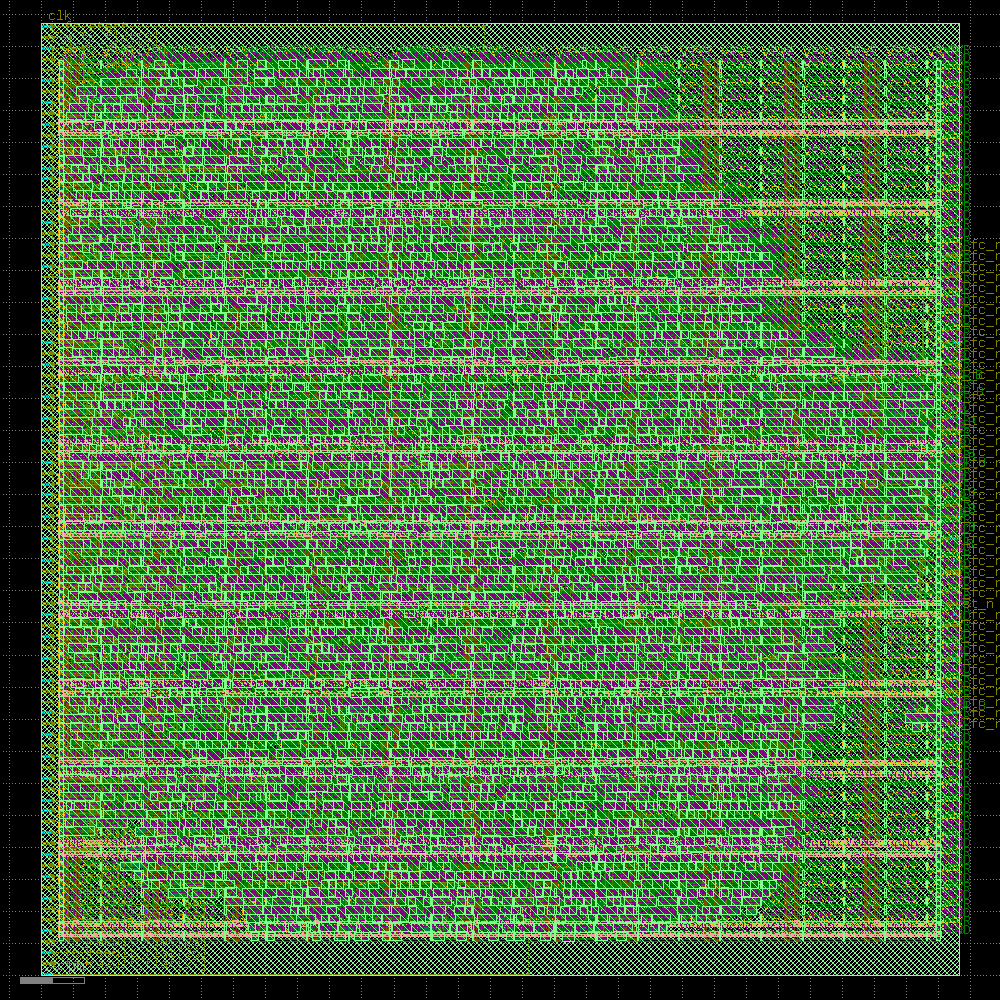

In [171]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [172]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[22:07:23] VERBOSE  Running 'OpenROAD.FillInsertion'…                                                  ]8;id=722578;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=673154;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:07:23] VERBOSE  Logging subprocess to                                                              ]8;id=634539;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=735593;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=897569;file:///content/openlane_run/76-openroad-fillinsertion/openroad-fillinsertion.log\openlane_run/]8;;\]8;id=647091;file:///content/openlane_run/76-openroad-fillinsertion/openroad-fillinsertion.log\76]8;;\]8;id=897569;file:///content/openlane_run/76-openroad-fillinsertion/openroad-fillinsertion.log\-openroad-fillinsertion/openroad-fillinsertion.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/75-openroad-detailedrouting/test_fc_top.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 20

[INFO] Setting input delay to: 20

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 5098 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'…

Writing netlist to '/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'…

Writing powered netlist to '/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'…

Writing layout to '/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'…

Writing timing constraints to '/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'…

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('143.168'), 'design__instance__displacement__mean': Decimal('0.027'), 'design__instance__displacement__max': Decimal('9.2'), 'route__wirelength__estimated': Decimal('86424.9'), 'design__violations': 0, 'antenna__violating__nets': 8, 'antenna__violating__pins': 8, 'route__net': 3991, 'route__net__special': 2, 'route__drc_errors__iter:1': 1130, 'route__wirelength__iter:1': 92779, 'route__drc_errors__iter:2': 367, 'route__wirelength__iter:2': 92096, 'route__drc_errors__iter:3': 324, 'route__wirelength__iter:3': 91994, 'route__drc_errors__iter:4': 2, 'route__wirelength__iter:4': 91962, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 91961, 'route__drc_errors': 0, 'route__wirelength': 91961, 'route__vias': 25282, 'route__vias__singlecut': 25282, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:07:25] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=758230;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=251660;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:07:25] VERBOSE  Logging subprocess to ]8;id=642605;file:///tmp/openlane_klayout_tmp_1tizx597/klayout-render.log\..]8;;\]8;id=733580;file:///tmp/openlane_klayout_tmp_1tizx597/klayout-render.log\/tmp/openlane_klayout_tmp_1tizx597/]8;;\]8;id=97323;file:///tmp/openlane_klayout_tmp_1tizx597/klayout-render.log\klayout-render.log]8;;\…     ]8;id=926093;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=445106;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.04s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
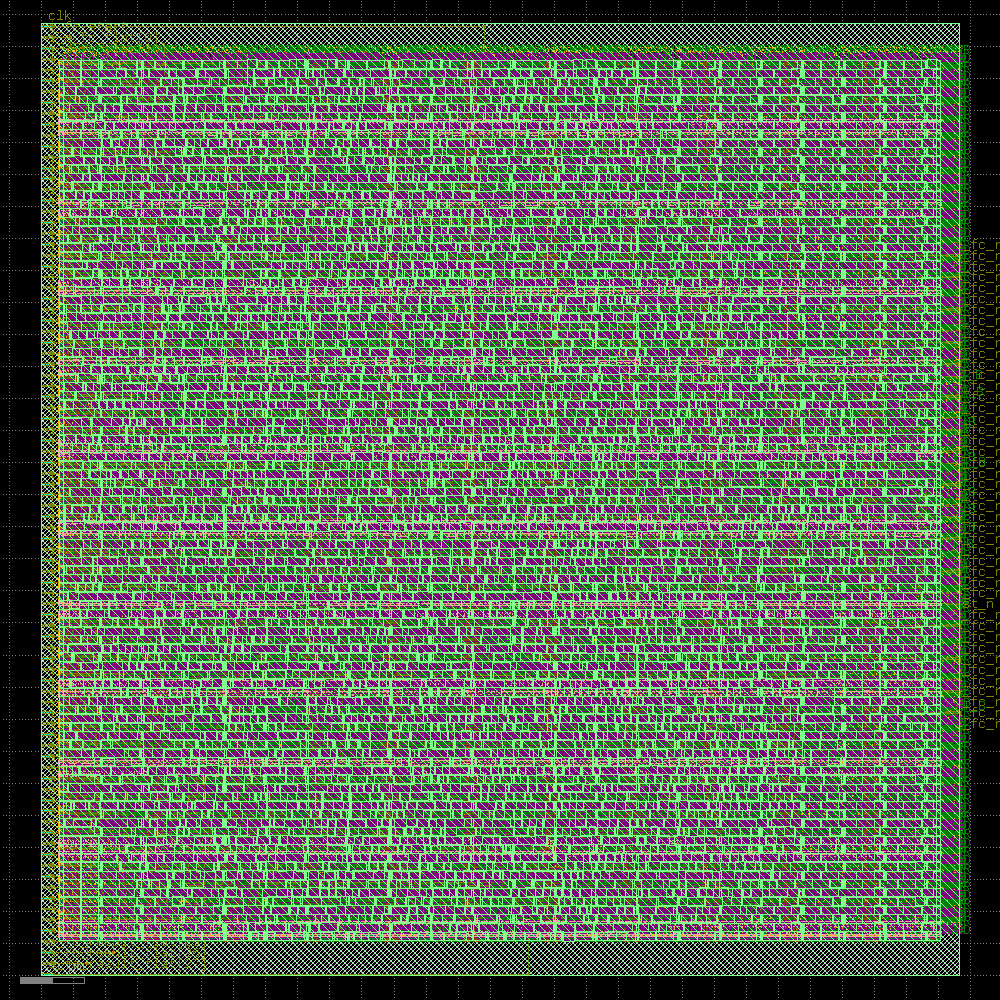

In [173]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [174]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

[22:07:27] VERBOSE  Running 'OpenROAD.RCX'…                                                            ]8;id=354757;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=616806;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:07:27] INFO     Running RCX for corners matching nom_*                                         ]8;id=31660;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=350368;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/77-openroad-rcx/nom/rcx.log)…                                           

[22:07:27] INFO     Running RCX for corners matching min_*                                         ]8;id=13257;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=650548;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/77-openroad-rcx/min/rcx.log)…                                           

[22:07:27] VERBOSE  Logging subprocess to ]8;id=707105;file:///content/openlane_run/77-openroad-rcx/nom/rcx.log\openlane_run/]8;;\]8;id=615885;file:///content/openlane_run/77-openroad-rcx/nom/rcx.log\77]8;;\]8;id=707105;file:///content/openlane_run/77-openroad-rcx/nom/rcx.log\-openroad-rcx/nom/rcx.log]8;;\…                    ]8;id=742026;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=983209;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[22:07:27] VERBOSE  Logging subprocess to ]8;id=831836;file:///content/openlane_run/77-openroad-rcx/min/rcx.log\openlane_run/]8;;\]8;id=585649;file:///content/openlane_run/77-openroad-rcx/min/rcx.log\77]8;;\]8;id=831836;file:///content/openlane_run/77-openroad-rcx/min/rcx.log\-openroad-rcx/min/rcx.log]8;;\…                    ]8;id=387740;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=987377;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[22:07:30] INFO     Finished RCX for corners matching min_*.                                       ]8;id=103737;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=451911;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[22:07:30] INFO     Running RCX for corners matching max_*                                         ]8;id=913745;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=988471;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/77-openroad-rcx/max/rcx.log)…                                           

[22:07:30] VERBOSE  Logging subprocess to ]8;id=456217;file:///content/openlane_run/77-openroad-rcx/max/rcx.log\openlane_run/]8;;\]8;id=132087;file:///content/openlane_run/77-openroad-rcx/max/rcx.log\77]8;;\]8;id=456217;file:///content/openlane_run/77-openroad-rcx/max/rcx.log\-openroad-rcx/max/rcx.log]8;;\…                    ]8;id=195555;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=652492;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[22:07:30] INFO     Finished RCX for corners matching nom_*.                                       ]8;id=556735;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=229943;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[22:07:32] INFO     Finished RCX for corners matching max_*.                                       ]8;id=674447;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=687000;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': None, 'spef': {'nom_*': Path('/content/openlane_run/77-openroad-rcx/nom/test_fc_top.nom.spef'), 'min_*': Path('/content/openlane_run/77-openroad-rcx/min/test_fc_top.min.spef'), 'max_*': Path('/content/openlane_run/77-openroad-rcx/max/test_fc_top.max.spef')}, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('143.168'), 'design__instance__displacement__mean': Decimal('0.027'), 'design__instance__displacement__max': Decimal('9.2'), 'route__wirelength__estimated': Decimal('86424.9'), 'design__violations': 0, 'antenna__violating__nets': 8, 'antenna__violating__pins': 8, 'route__net': 3991, 'route__net__special': 2, 'route__drc_errors__iter:1': 1130, 'route__wirelength__iter:1': 92779, 'route__drc_errors__iter:2': 367, 'route__wirelength__iter:2': 92096, 'route__drc_errors__iter:3': 324, 'route__wirelength__iter:3': 91994, 'route__drc_errors__iter:4': 2, 'route__wirelength__iter:4': 91962, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 91961, 'route__drc_errors': 0, 'route__wirelength': 91961, 'route__vias': 25282, 'route__vias__singlecut': 25282, 'route__vias__multicut': 0}}

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [175]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[22:07:32] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=438717;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=991653;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:07:32] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=615777;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=957206;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:07:32] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=585888;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=734646;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:07:32] VERBOSE  Logging subprocess to                                                              ]8;id=140019;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=537921;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=485354;file:///content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=105597;file:///content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\78]8;;\]8;id=485354;file:///content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\-openroad-stapostpnr/nom_ss_100C_1v60/sta.log]8;;\…                                  

[22:07:32] VERBOSE  Logging subprocess to                                                              ]8;id=316099;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=715097;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=86026;file:///content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=280245;file:///content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\78]8;;\]8;id=86026;file:///content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\-openroad-stapostpnr/nom_tt_025C_1v80/sta.log]8;;\…                                  

[22:07:43] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=618128;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=658852;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:07:43] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=572815;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=407969;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:07:43] VERBOSE  Logging subprocess to                                                              ]8;id=516799;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=7595;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=580545;file:///content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=4726;file:///content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\78]8;;\]8;id=580545;file:///content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[22:07:43] VERBOSE  Logging subprocess to                                                              ]8;id=571951;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=322580;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=405295;file:///content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=370162;file:///content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\78]8;;\]8;id=405295;file:///content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[22:07:44] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=822334;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=212944;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:07:44] VERBOSE  Logging subprocess to                                                              ]8;id=61964;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=518533;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=403627;file:///content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=995762;file:///content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\78]8;;\]8;id=403627;file:///content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log]8;;\…                                  

[22:07:44] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=208759;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=508159;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:07:44] VERBOSE  Logging subprocess to                                                              ]8;id=290467;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=981258;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=634382;file:///content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=606417;file:///content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/sta.log\78]8;;\]8;id=634382;file:///content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/sta.log\-openroad-stapostpnr/min_tt_025C_1v80/sta.log]8;;\…                                  

[22:07:56] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=370459;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=151560;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:07:56] VERBOSE  Logging subprocess to                                                              ]8;id=961123;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=145745;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=681332;file:///content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=988820;file:///content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\78]8;;\]8;id=681332;file:///content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[22:07:57] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=755648;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=572147;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:07:57] VERBOSE  Logging subprocess to                                                              ]8;id=674259;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=821635;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=858057;file:///content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=911827;file:///content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\78]8;;\]8;id=858057;file:///content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[22:07:58] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=283969;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=153492;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:07:58] VERBOSE  Logging subprocess to                                                              ]8;id=172701;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=855558;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=533208;file:///content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=69528;file:///content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/sta.log\78]8;;\]8;id=533208;file:///content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/sta.log\-openroad-stapostpnr/min_ss_100C_1v60/sta.log]8;;\…                                  

[22:07:58] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=545490;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=3077;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:07:58] VERBOSE  Logging subprocess to                                                              ]8;id=270306;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=88530;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=27072;file:///content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=207427;file:///content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\78]8;;\]8;id=27072;file:///content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\-openroad-stapostpnr/min_ff_n40C_1v95/sta.log]8;;\…                                  

[22:08:09] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=922973;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=109409;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:08:09] VERBOSE  Logging subprocess to                                                              ]8;id=780523;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=683067;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=899855;file:///content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=886729;file:///content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\78]8;;\]8;id=899855;file:///content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[22:08:10] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=959115;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=518509;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:08:10] VERBOSE  Logging subprocess to                                                              ]8;id=672089;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=902126;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=203291;file:///content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=691985;file:///content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/sta.log\78]8;;\]8;id=203291;file:///content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/sta.log\-openroad-stapostpnr/max_tt_025C_1v80/sta.log]8;;\…                                  

[22:08:11] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=687262;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=980958;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:08:11] VERBOSE  Logging subprocess to                                                              ]8;id=840138;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=582946;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=49550;file:///content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=717021;file:///content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\78]8;;\]8;id=49550;file:///content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[22:08:12] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=44881;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=327368;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:08:12] VERBOSE  Logging subprocess to                                                              ]8;id=149269;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=908020;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=551519;file:///content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=826994;file:///content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/sta.log\78]8;;\]8;id=551519;file:///content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/sta.log\-openroad-stapostpnr/max_ss_100C_1v60/sta.log]8;;\…                                  

[22:08:22] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=514354;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=368539;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:08:22] VERBOSE  Logging subprocess to                                                              ]8;id=907256;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=540999;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=378235;file:///content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=484253;file:///content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\78]8;;\]8;id=378235;file:///content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[22:08:23] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=499687;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=617642;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[22:08:23] VERBOSE  Logging subprocess to                                                              ]8;id=615907;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=664036;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=332134;file:///content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=933088;file:///content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\78]8;;\]8;id=332134;file:///content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\-openroad-stapostpnr/max_ff_n40C_1v95/sta.log]8;;\…                                  

[22:08:23] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=554700;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=922661;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:08:23] VERBOSE  Logging subprocess to                                                              ]8;id=135731;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=231334;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=153751;file:///content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=374986;file:///content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\78]8;;\]8;id=153751;file:///content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[22:08:31] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=368312;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=420410;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[22:08:31] VERBOSE  Logging subprocess to                                                              ]8;id=828214;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=833708;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=981876;file:///content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=826466;file:///content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\78]8;;\]8;id=981876;file:///content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.15… │ 0.15… │ 0.0… │ 0     │ 0    │ 60.3… │ 94.… │ 0.00… │ 0    │ 0     │ 4    │ 868   │
│ nom_tt_025C_1v80     │ 0.40… │ 0.40… │ 0.0… │ 0     │ 0    │ 70.7… │ 97.… │ 0.00… │ 0    │ 0     │ 2    │ 194   │
│ nom_ss_100C_1v60     │ 1.05… │ 1.05… │ 0.0… │ 0     │ 0    │ 60.4… │ 94.… │ 0.00… │ 0    │ 0     │ 4    │ 755   │
│ nom_ff_n40C_1v95     │ 0.15… │ 0.15… │ 0.0… │ 0     │ 0    │ 74.3… │ 98.… │ 0.00… │ 0    │ 0     │ 2    │ 135   │
│ min_tt_025C_1v80     │ 0.39… │ 0.39… │ 0.0… │ 0     │ 0    │ 70.8… │ 97.… │ 0.00… │ 0    │ 0     │ 2    │ 161   │
│ min_ss_100C_1v60     │ 1.05… │ 1.05… │ 0.0… │ 0     │ 0    │ 60.5… │ 94.… │ 0.00… │ 0    │ 0     │ 4    │ 691   │
│ min_ff_n40C_1v95     │ 0.15… │ 0.15… │ 0.0… │ 0     │ 0    │ 74.4… │ 98.… │ 0.00… │ 0    │ 0     │ 2    │ 135   │
│ max_tt_025C_1v80     │ 0.40… │ 0.40… │ 0.0… │ 0     │ 0    │ 70.7… │ 96.… │ 0.00… │ 0    │ 0     │ 2    │ 235   │
│ max_ss_100C_1v60     │ 1.05… │ 1.05… │ 0.0… │ 0     │ 0    │ 60.3… │ 94.… │ 0.00… │ 0    │ 0     │ 4    │ 868   │
│ max_ff_n40C_1v95     │ 0.15… │ 0.15… │ 0.0… │ 0     │ 0    │ 74.2… │ 97.… │ 0.00… │ 0    │ 0     │ 2    │ 147   │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.1508   │ 0.1508   │ 0.0000   │ 0        │ 0         │ 60.3610  │ 94.6106   │ 0.0000   │ 0         │ 0        │ 4         │ 868      │
│ nom_tt_025C_1v80     │ 0.4009   │ 0.4009   │ 0.0000   │ 0        │ 0         │ 70.7815  │ 97.1015   │ 0.0000   │ 0         │ 0        │ 2         │ 194      │
│ nom_ss_100C_1v60     │ 1.0524   │ 1.0524   │ 0.0000   │ 0        │ 0         │ 60.4645  │ 94.8018   │ 0.0000   │ 0         │ 0        │ 4         │ 755      │
│ nom_ff_n40C_1v95     │ 0.1518   │ 0.1518   │ 0.0000   │ 0        │ 0         │ 74.3465  │ 98.0333   │ 0.0000   │ 0         │ 0        │ 2         │ 135      │
│ min_tt_025C_1v80     │ 0.3986   │ 0.3986   │ 0.0000   │ 0        │ 0         │ 70.8378  │ 97.2068   │ 0.0000   │ 0         │ 0        │ 2         │ 161      │
│ min_ss_100C_1v60     │ 1.0504   │ 1.0504   │ 0.0000   │ 0        │ 0         │ 60.5609  │ 94.9873   │ 0.0000   │ 0         │ 0        │ 4         │ 691      │
│ min_ff_n40C_1v95     │ 0.1508   │ 0.1508   │ 0.0000   │ 0        │ 0         │ 74.4107  │ 98.1099   │ 0.0000   │ 0         │ 0        │ 2         │ 135      │
│ max_tt_025C_1v80     │ 0.4040   │ 0.4040   │ 0.0000   │ 0        │ 0         │ 70.7167  │ 96.9913   │ 0.0000   │ 0         │ 0        │ 2         │ 235      │
│ max_ss_100C_1v60     │ 1.0544   │ 1.0544   │ 0.0000   │ 0        │ 0         │ 60.3610  │ 94.6106   │ 0.0000   │ 0         │ 0        │ 4         │ 868      │
│ max_ff_n40C_1v95     │ 0.1530   │ 0.1530   │ 0.0000   │ 0        │ 0         │ 74.2735  │ 97.9669   │ 0.0000   │ 0         │ 0        │ 2         │ 147      │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/77-openroad-rcx/nom/test_fc_top.nom.spef'), 'min_*': Path('/content/openlane_run/77-openroad-rcx/min/test_fc_top.min.spef'), 'max_*': Path('/content/openlane_run/77-openroad-rcx/max/test_fc_top.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__coun

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [176]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[22:08:32] VERBOSE  Running 'KLayout.StreamOut'…                                                       ]8;id=284163;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=724754;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:08:32] VERBOSE  Logging subprocess to ]8;id=716113;file:///content/openlane_run/79-klayout-streamout/klayout-streamout.log\openlane_run/]8;;\]8;id=442327;file:///content/openlane_run/79-klayout-streamout/klayout-streamout.log\79]8;;\]8;id=716113;file:///content/openlane_run/79-klayout-streamout/klayout-streamout.log\-klayout-streamout/klayout-streamout.log]8;;\…     ]8;id=31846;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=210706;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Error processing line 1 of /usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.pth:

Traceback (most recent call last):

File "<frozen site>", line 201, in addpackage

File "<string>", line 1, in <module>

File "/usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.py", line 2, in <module>

import importlib.abc

File "/usr/lib/python3.11/importlib/abc.py", line 19, in <module>

from .resources.abc import ResourceReader, Traversable, TraversableResources

File "/usr/lib/python3.11/importlib/resources/__init__.py", line 3, in <module>

from ._common import (

File "/usr/lib/python3.11/importlib/resources/_common.py", line 2, in <module>

import pathlib

File "/usr/local/lib/python3.11/dist-packages/pathlib.py", line 10, in <module>

from collections import Sequence

ImportError: cannot import name 'Sequence' from 'collections' (/usr/lib/python3.11/collections/__init__.py)

Remainder of file ignored

Error processing line 1 of /usr/local/lib/python3.11/dist-packages/_rapids_dask_dependency.pth:

Traceback (most recent call last):

File "<frozen site>", line 201, in addpackage

File "<string>", line 1, in <module>

File "/usr/local/lib/python3.11/dist-packages/rapids_dask_dependency/__init__.py", line 3, in <module>

from .dask_loader import DaskFinder

File "/usr/local/lib/python3.11/dist-packages/rapids_dask_dependency/dask_loader.py", line 4, in <module>

import importlib.abc

File "/usr/lib/python3.11/importlib/abc.py", line 19, in <module>

from .resources.abc import ResourceReader, Traversable, TraversableResources

File "/usr/lib/python3.11/importlib/resources/__init__.py", line 3, in <module>

from ._common import (

File "/usr/lib/python3.11/importlib/resources/_common.py", line 2, in <module>

import pathlib

File "/usr/local/lib/python3.11/dist-packages/pathlib.py", line 10, in <module>

from collections import Sequence

ImportError: cannot import name 'Sequence' from 'collections' (/usr/lib/python3.11/collections/__init__.py)

Remainder of file ignored

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'test_fc_top'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/79-klayout-streamout/test_fc_top.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/77-openroad-rcx/nom/test_fc_top.nom.spef'), 'min_*': Path('/content/openlane_run/77-openroad-rcx/min/test_fc_top.min.spef'), 'max_*': Path('/content/openlane_run/77-openroad-rcx/max/test_fc_top.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[22:08:34] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=186814;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=562406;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:08:34] VERBOSE  Logging subprocess to ]8;id=12431;file:///tmp/openlane_klayout_tmp_1st2an4h/klayout-render.log\..]8;;\]8;id=757404;file:///tmp/openlane_klayout_tmp_1st2an4h/klayout-render.log\/tmp/openlane_klayout_tmp_1st2an4h/]8;;\]8;id=402927;file:///tmp/openlane_klayout_tmp_1st2an4h/klayout-render.log\klayout-render.log]8;;\…     ]8;id=900641;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=894380;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.64s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
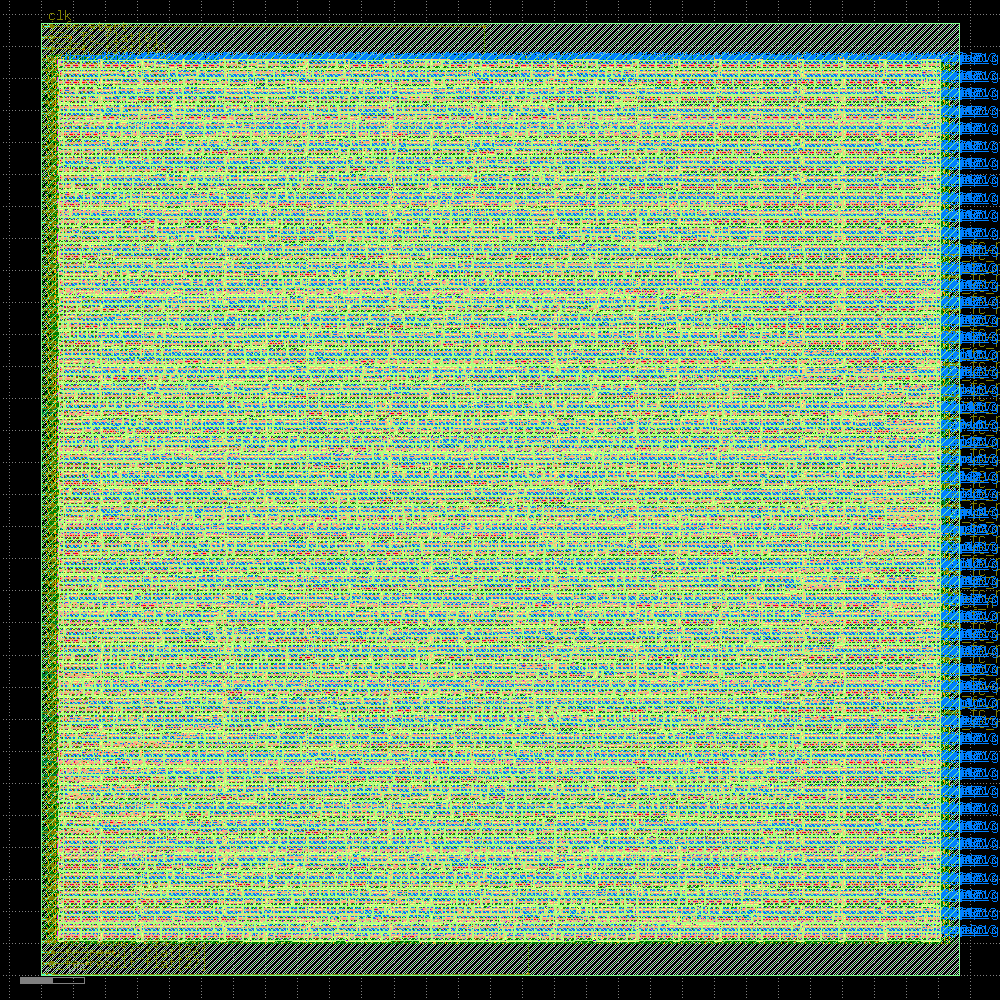

In [177]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [178]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[22:08:36] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=700385;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=247269;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:08:36] VERBOSE  Logging subprocess to ]8;id=470620;file:///content/openlane_run/80-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=822389;file:///content/openlane_run/80-magic-drc/magic-drc.log\80]8;;\]8;id=470620;file:///content/openlane_run/80-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                     ]8;id=940585;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=184096;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M3M4_PR".

Reading "VIA_M2M3_PR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_via2_3_1600_480_1_5_320_320".

Reading "VIA_via3_4_1600_480_1_4_400_400".

Reading "VIA_via4_5_1600_480_1_4_400_400".

Reading "VIA_via5_6_1600_1600_1_1_1600_1600".

Reading "sky130_fd_sc_hd__clkbuf_4".

Reading "sky130_fd_sc_hd__clkinv_2".

Reading "sky130_fd_sc_hd__inv_4".

Reading "sky130_fd_sc_hd__clkbuf_8".

Reading "sky130_fd_sc_hd__clkinv_4".

Reading "sky130_fd_sc_hd__inv_6".

Reading "sky130_fd_sc_hd__clkbuf_16".

Reading "sky130_fd_sc_hd__buf_2".

Reading "sky130_fd_sc_hd__dfrtp_2".

Reading "sky130_fd_sc_hd__o41a_2".

Reading "sky130_fd_sc_hd__a311o_2".

Reading "sky130_fd_sc_hd__nand3b_2".

Reading "sky130_fd_sc_hd__a2bb2oi_2".

Reading "sky130_fd_sc_hd__a2111o_2".

Reading "sky130_fd_sc_hd__nor3b_2".

Reading "sky130_fd_sc_hd__o22ai_2".

Reading "sky130_fd_sc_hd__o21bai_2".

Reading "sky130_fd_sc_hd__a22oi_2".

Reading "sky130_fd_sc_hd__o2111a_2".

Reading "sky130_fd_sc_hd__and4bb_2".

Reading "sky130_fd_sc_hd__or4_2".

Reading "sky130_fd_sc_hd__nand4_2".

Reading "sky130_fd_sc_hd__o31a_2".

Reading "sky130_fd_sc_hd__a211oi_2".

Reading "sky130_fd_sc_hd__a2bb2o_2".

Reading "sky130_fd_sc_hd__a32oi_2".

Reading "sky130_fd_sc_hd__o311a_2".

Reading "sky130_fd_sc_hd__a221o_2".

Reading "sky130_fd_sc_hd__a32o_2".

Reading "sky130_fd_sc_hd__o31ai_2".

Reading "sky130_fd_sc_hd__o211ai_2".

Reading "sky130_fd_sc_hd__a31oi_2".

Reading "sky130_fd_sc_hd__nand3_2".

Reading "sky130_fd_sc_hd__o211a_2".

Reading "sky130_fd_sc_hd__a41o_2".

Reading "sky130_fd_sc_hd__a22o_2".

Reading "sky130_fd_sc_hd__or4b_2".

Reading "sky130_fd_sc_hd__or3b_2".

Reading "sky130_fd_sc_hd__a21bo_2".

Reading "sky130_fd_sc_hd__a31o_2".

Reading "sky130_fd_sc_hd__a21boi_2".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__and3b_2".

Reading "sky130_fd_sc_hd__nor3_2".

Reading "sky130_fd_sc_hd__a311oi_2".

Reading "sky130_fd_sc_hd__a211o_2".

Reading "sky130_fd_sc_hd__o32a_2".

Reading "sky130_fd_sc_hd__and4_2".

Reading "sky130_fd_sc_hd__nand2b_2".

Reading "sky130_fd_sc_hd__and3_2".

Reading "sky130_fd_sc_hd__o21ai_2".

Reading "sky130_fd_sc_hd__or3_2".

Reading "sky130_fd_sc_hd__o21a_2".

Reading "sky130_fd_sc_hd__a21oi_2".

Reading "sky130_fd_sc_hd__o22a_2".

Reading "sky130_fd_sc_hd__and2b_2".

Reading "sky130_fd_sc_hd__o21ba_2".

Reading "sky130_fd_sc_hd__o2bb2a_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__nor2_2".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__mux2_1".

Reading "sky130_fd_sc_hd__or2_2".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_fd_sc_hd__fill_2".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_fd_sc_hd__fill_1".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_3".

Reading "test_fc_top".

5000 uses

10000 uses

15000 uses

20000 uses

25000 uses

30000 uses

35000 uses

[INFO] Loading test_fc_top

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/80-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors (/content/openlane_run/80-magic-drc/views/test_fc_top.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/77-openroad-rcx/nom/test_fc_top.nom.spef'), 'min_*': Path('/content/openlane_run/77-openroad-rcx/min/test_fc_top.min.spef'), 'max_*': Path('/content/openlane_run/77-openroad-rcx/max/test_fc_top.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'), 'floorplan__design__io': 133, 'design__io__hpwl': 27352420, 'design

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [179]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[22:09:04] VERBOSE  Running 'Magic.SpiceExtraction'…                                                   ]8;id=310275;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=633773;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:09:04] VERBOSE  Logging subprocess to                                                              ]8;id=115335;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=803755;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=751162;file:///content/openlane_run/81-magic-spiceextraction/magic-spiceextraction.log\openlane_run/]8;;\]8;id=653380;file:///content/openlane_run/81-magic-spiceextraction/magic-spiceextraction.log\81]8;;\]8;id=751162;file:///content/openlane_run/81-magic-spiceextraction/magic-spiceextraction.log\-magic-spiceextraction/magic-spiceextraction.log]8;;\…                               

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef.

This action cannot be undone.

LEF read, Line 78 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 79 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 112 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 114 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 115 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 121 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 122 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 123 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 156 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 164 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 165 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 167 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 168 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 169 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 206 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 207 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 209 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 210 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 211 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 248 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 249 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 251 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 252 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 253 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 290 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 291 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read: Processed 797 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 56535 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 278 lines.

> def read /content/openlane_run/76-openroad-fillinsertion/test_fc_top.def -noblockage -labels

Reading DEF data from file /content/openlane_run/76-openroad-fillinsertion/test_fc_top.def.

This action cannot be undone.

Processed 4 vias total.

Processed 10312 subcell instances total.

Processed 135 pins total.

Processed 2 special nets total.

Processed 3991 nets total.

DEF read: Processed 70209 lines.

Moving label "_0103_" from metal2 to via1 in cell test_fc_top.

Moving label "_0157_" from metal1 to via1 in cell test_fc_top.

Moving label "_0226_" from metal1 to via1 in cell test_fc_top.

Moving label "_0231_" from metal1 to viali in cell test_fc_top.

Moving label "_0305_" from metal2 to via2 in cell test_fc_top.

Moving label "_0506_" from metal1 to via1 in cell test_fc_top.

Moving label "_0617_" from metal1 to via1 in cell test_fc_top.

Moving label "_0642_" from metal2 to via1 in cell test_fc_top.

Moving label "_0660_" from metal1 to via1 in cell test_fc_top.

Moving label "_0714_" from metal2 to via2 in cell test_fc_top.

Moving label "_0718_" from metal1 to via1 in cell test_fc_top.

Moving label "_0867_" from metal2 to via1 in cell test_fc_top.

Moving label "_0893_" from metal1 to viali in cell test_fc_top.

Moving label "_0945_" from metal2 to via2 in cell test_fc_top.

Moving label "_1019_" from metal1 to viali in cell test_fc_top.

Moving label "_1135_" from metal2 to via1 in cell test_fc_top.

Moving label "_1247_" from metal1 to via1 in cell test_fc_top.

Moving label "_1605_" from metal1 to via1 in cell test_fc_top.

Moving label "_1610_" from metal2 to via2 in cell test_fc_top.

Moving label "_1721_" from metal2 to via2 in cell test_fc_top.

Moving label "_1819_" from metal1 to via1 in cell test_fc_top.

Moving label "_2027_" from metal2 to via2 in cell test_fc_top.

Moving label "_2041_" from metal1 to viali in cell test_fc_top.

Moving label "_2167_" from metal1 to via1 in cell test_fc_top.

Moving label "_2223_" from metal1 to via1 in cell test_fc_top.

Moving label "_2316_" from metal1 to via1 in cell test_fc_top.

Moving label "_2390_" from metal1 to via1 in cell test_fc_top.

Moving label "_2500_" from metal1 to viali in cell test_fc_top.

Moving label "_2531_" from metal1 to viali in cell test_fc_top.

Moving label "_2532_" from metal1 to viali in cell test_fc_top.

Moving label "_2535_" from metal1 to via1 in cell test_fc_top.

Moving label "_2721_" from metal1 to via1 in cell test_fc_top.

Moving label "_2779_" from metal1 to via1 in cell test_fc_top.

Moving label "_2807_" from metal1 to via1 in cell test_fc_top.

Moving label "_2822_" from metal1 to via1 in cell test_fc_top.

Moving label "_2895_" from metal1 to via1 in cell test_fc_top.

Moving label "_3039_" from metal2 to via2 in cell test_fc_top.

Moving label "_3067_" from metal1 to via1 in cell test_fc_top.

Moving label "_3117_" from metal2 to via2 in cell test_fc_top.

Moving label "_3169_" from metal1 to via1 in cell test_fc_top.

Moving label "_3257_" from metal1 to via1 in cell test_fc_top.

Moving label "_3305_" from metal1 to via1 in cell test_fc_top.

Moving label "_3408_" from metal1 to viali in cell test_fc_top.

Moving label "_3436_" from metal1 to via1 in cell test_fc_top.

Moving label "_3536_" from metal1 to viali in cell test_fc_top.

Moving label "_3591_" from metal1 to viali in cell test_fc_top.

Moving label "_3768_" from metal1 to via1 in cell test_fc_top.

Moving label "_3834_" from metal1 to via1 in cell test_fc_top.

Moving label "i_z_fc_flat[16]" from metal2 to via2 in cell test_fc_top.

Moving label "o_fc_result_flat[53]" from metal2 to via2 in cell test_fc_top.

Moving label "rst_n" from metal2 to via1 in cell test_fc_top.

Processing test_fc_top

Extracting sky130_ef_sc_hd__decap_12 into sky130_ef_sc_hd__decap_12.ext:

Extracting sky130_fd_sc_hd__decap_3 into sky130_fd_sc_hd__decap_3.ext:

Extracting sky130_fd_sc_hd__fill_1 into sky130_fd_sc_hd__fill_1.ext:

Extracting sky130_fd_sc_hd__tapvpwrvgnd_1 into sky130_fd_sc_hd__tapvpwrvgnd_1.ext:

Extracting sky130_fd_sc_hd__decap_4 into sky130_fd_sc_hd__decap_4.ext:

Extracting sky130_fd_sc_hd__decap_6 into sky130_fd_sc_hd__decap_6.ext:

Extracting sky130_fd_sc_hd__or2_2 into sky130_fd_sc_hd__or2_2.ext:

Extracting sky130_fd_sc_hd__nand2_2 into sky130_fd_sc_hd__nand2_2.ext:

Extracting sky130_fd_sc_hd__a21bo_2 into sky130_fd_sc_hd__a21bo_2.ext:

Extracting sky130_fd_sc_hd__xor2_2 into sky130_fd_sc_hd__xor2_2.ext:

Extracting sky130_fd_sc_hd__fill_2 into sky130_fd_sc_hd__fill_2.ext:

Extracting sky130_fd_sc_hd__decap_8 into sky130_fd_sc_hd__decap_8.ext:

Extracting sky130_fd_sc_hd__and2_2 into sky130_fd_sc_hd__and2_2.ext:

Extracting sky130_fd_sc_hd__nor2_2 into sky130_fd_sc_hd__nor2_2.ext:

Extracting sky130_fd_sc_hd__xnor2_2 into sky130_fd_sc_hd__xnor2_2.ext:

Extracting sky130_fd_sc_hd__a21o_2 into sky130_fd_sc_hd__a21o_2.ext:

Extracting sky130_fd_sc_hd__o21a_2 into sky130_fd_sc_hd__o21a_2.ext:

Extracting sky130_fd_sc_hd__o21ba_2 into sky130_fd_sc_hd__o21ba_2.ext:

Extracting sky130_fd_sc_hd__and2b_2 into sky130_fd_sc_hd__and2b_2.ext:

Extracting sky130_fd_sc_hd__nor3_2 into sky130_fd_sc_hd__nor3_2.ext:

Extracting sky130_fd_sc_hd__nand2b_2 into sky130_fd_sc_hd__nand2b_2.ext:

Extracting sky130_fd_sc_hd__o21bai_2 into sky130_fd_sc_hd__o21bai_2.ext:

Extracting sky130_fd_sc_hd__a21oi_2 into sky130_fd_sc_hd__a21oi_2.ext:

Extracting sky130_fd_sc_hd__o21ai_2 into sky130_fd_sc_hd__o21ai_2.ext:

Extracting sky130_fd_sc_hd__nand3_2 into sky130_fd_sc_hd__nand3_2.ext:

Extracting sky130_fd_sc_hd__o2bb2a_2 into sky130_fd_sc_hd__o2bb2a_2.ext:

Extracting sky130_fd_sc_hd__and3b_2 into sky130_fd_sc_hd__and3b_2.ext:

Extracting sky130_fd_sc_hd__a31o_2 into sky130_fd_sc_hd__a31o_2.ext:

Extracting sky130_fd_sc_hd__or3_2 into sky130_fd_sc_hd__or3_2.ext:

Extracting sky130_fd_sc_hd__and3_2 into sky130_fd_sc_hd__and3_2.ext:

Extracting sky130_fd_sc_hd__inv_2 into sky130_fd_sc_hd__inv_2.ext:

Extracting sky130_fd_sc_hd__a21boi_2 into sky130_fd_sc_hd__a21boi_2.ext:

Extracting sky130_fd_sc_hd__mux2_1 into sky130_fd_sc_hd__mux2_1.ext:

Extracting sky130_fd_sc_hd__a22o_2 into sky130_fd_sc_hd__a22o_2.ext:

Extracting sky130_fd_sc_hd__o22a_2 into sky130_fd_sc_hd__o22a_2.ext:

Extracting sky130_fd_sc_hd__o32a_2 into sky130_fd_sc_hd__o32a_2.ext:

Extracting sky130_fd_sc_hd__o211a_2 into sky130_fd_sc_hd__o211a_2.ext:

Extracting sky130_fd_sc_hd__dfrtp_2 into sky130_fd_sc_hd__dfrtp_2.ext:

Extracting sky130_fd_sc_hd__a22oi_2 into sky130_fd_sc_hd__a22oi_2.ext:

Extracting sky130_fd_sc_hd__a41o_2 into sky130_fd_sc_hd__a41o_2.ext:

Extracting sky130_fd_sc_hd__and4bb_2 into sky130_fd_sc_hd__and4bb_2.ext:

Extracting sky130_fd_sc_hd__or3b_2 into sky130_fd_sc_hd__or3b_2.ext:

Extracting sky130_fd_sc_hd__and4_2 into sky130_fd_sc_hd__and4_2.ext:

Extracting sky130_fd_sc_hd__o2111a_2 into sky130_fd_sc_hd__o2111a_2.ext:

Extracting sky130_fd_sc_hd__a211o_2 into sky130_fd_sc_hd__a211o_2.ext:

Extracting sky130_fd_sc_hd__buf_2 into sky130_fd_sc_hd__buf_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_16 into sky130_fd_sc_hd__clkbuf_16.ext:

Extracting sky130_fd_sc_hd__clkbuf_8 into sky130_fd_sc_hd__clkbuf_8.ext:

Extracting sky130_fd_sc_hd__clkinv_4 into sky130_fd_sc_hd__clkinv_4.ext:

Extracting sky130_fd_sc_hd__inv_6 into sky130_fd_sc_hd__inv_6.ext:

Extracting sky130_fd_sc_hd__o31a_2 into sky130_fd_sc_hd__o31a_2.ext:

Extracting sky130_fd_sc_hd__nor3b_2 into sky130_fd_sc_hd__nor3b_2.ext:

Extracting sky130_fd_sc_hd__a32o_2 into sky130_fd_sc_hd__a32o_2.ext:

Extracting sky130_fd_sc_hd__o211ai_2 into sky130_fd_sc_hd__o211ai_2.ext:

Extracting sky130_fd_sc_hd__clkinv_2 into sky130_fd_sc_hd__clkinv_2.ext:

Extracting sky130_fd_sc_hd__a2bb2o_2 into sky130_fd_sc_hd__a2bb2o_2.ext:

Extracting sky130_fd_sc_hd__inv_4 into sky130_fd_sc_hd__inv_4.ext:

Extracting sky130_fd_sc_hd__o31ai_2 into sky130_fd_sc_hd__o31ai_2.ext:

Extracting sky130_fd_sc_hd__or4_2 into sky130_fd_sc_hd__or4_2.ext:

Extracting sky130_fd_sc_hd__a31oi_2 into sky130_fd_sc_hd__a31oi_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_4 into sky130_fd_sc_hd__clkbuf_4.ext:

Extracting sky130_fd_sc_hd__a211oi_2 into sky130_fd_sc_hd__a211oi_2.ext:

Extracting sky130_fd_sc_hd__a311o_2 into sky130_fd_sc_hd__a311o_2.ext:

Extracting sky130_fd_sc_hd__o41a_2 into sky130_fd_sc_hd__o41a_2.ext:

Extracting sky130_fd_sc_hd__a311oi_2 into sky130_fd_sc_hd__a311oi_2.ext:

Extracting sky130_fd_sc_hd__o22ai_2 into sky130_fd_sc_hd__o22ai_2.ext:

Extracting sky130_fd_sc_hd__o311a_2 into sky130_fd_sc_hd__o311a_2.ext:

Extracting sky130_fd_sc_hd__or4b_2 into sky130_fd_sc_hd__or4b_2.ext:

Extracting sky130_fd_sc_hd__a2bb2oi_2 into sky130_fd_sc_hd__a2bb2oi_2.ext:

Extracting sky130_fd_sc_hd__a2111o_2 into sky130_fd_sc_hd__a2111o_2.ext:

Extracting sky130_fd_sc_hd__nand3b_2 into sky130_fd_sc_hd__nand3b_2.ext:

Extracting sky130_fd_sc_hd__a221o_2 into sky130_fd_sc_hd__a221o_2.ext:

Extracting sky130_fd_sc_hd__nand4_2 into sky130_fd_sc_hd__nand4_2.ext:

Extracting sky130_fd_sc_hd__a32oi_2 into sky130_fd_sc_hd__a32oi_2.ext:

Extracting test_fc_top into test_fc_top.ext:

exttospice finished.

Using technology "sky130A", version 1.0.466-0-gbdc9412

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/77-openroad-rcx/nom/test_fc_top.nom.spef'), 'min_*': Path('/content/openlane_run/77-openroad-rcx/min/test_fc_top.min.spef'), 'max_*': Path('/content/openlane_run/77-openroad-rcx/max/test_fc_top.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/81-magic-spiceextraction/test_fc_top.spice'), 'mag': None, 'gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'),

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [180]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[22:09:13] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=101858;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=435076;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[22:09:13] VERBOSE  Logging subprocess to ]8;id=344137;file:///content/openlane_run/82-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=242711;file:///content/openlane_run/82-netgen-lvs/netgen-lvs.log\82]8;;\]8;id=344137;file:///content/openlane_run/82-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                   ]8;id=917981;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=814489;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin Y in instance clkload0 of sky130_fd_sc_hd__inv_6 in cell test_fc_top

Note:  Implicit pin Y in instance clkload1 of sky130_fd_sc_hd__clkinv_4 in cell test_fc_top

Note:  Implicit pin X in instance clkload2 of sky130_fd_sc_hd__clkbuf_8 in cell test_fc_top

Note:  Implicit pin Y in instance clkload3 of sky130_fd_sc_hd__inv_6 in cell test_fc_top

Note:  Implicit pin Y in instance clkload4 of sky130_fd_sc_hd__inv_4 in cell test_fc_top

Note:  Implicit pin Y in instance clkload5 of sky130_fd_sc_hd__clkinv_2 in cell test_fc_top

Note:  Implicit pin X in instance clkload6 of sky130_fd_sc_hd__clkbuf_4 in cell test_fc_top

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin end_a == end_b

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

No property perim found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/openlane_run/82-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/82-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2o_2'

Circuit sky130_fd_sc_hd__a2bb2o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2o_2'

Circuit sky130_fd_sc_hd__a2bb2o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a2bb2o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__or2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__and3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 30 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  15

Class: sky130_fd_pr__pfet_01v8_hvt instances:  15

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o32a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21bai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__or3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o21ba_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__and2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a32o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__and3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21boi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__and4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o211a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__or4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a211o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__mux2_1'

Circuit sky130_fd_sc_hd__mux2_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__mux2_1'

Circuit sky130_fd_sc_hd__mux2_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__mux2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nand4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211ai_2'

Circuit sky130_fd_sc_hd__o211ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211ai_2'

Circuit sky130_fd_sc_hd__o211ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o211ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a22o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a221o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a22oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o311a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__and4bb_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21bo_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_6'

Circuit sky130_fd_sc_hd__inv_6 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_6'

Circuit sky130_fd_sc_hd__inv_6 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311oi_2'

Circuit sky130_fd_sc_hd__a311oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311oi_2'

Circuit sky130_fd_sc_hd__a311oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a311oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a211oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a41o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__or4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_4'

Circuit sky130_fd_sc_hd__inv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_4'

Circuit sky130_fd_sc_hd__inv_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31ai_2'

Circuit sky130_fd_sc_hd__o31ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31ai_2'

Circuit sky130_fd_sc_hd__o31ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o31ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3b_2'

Circuit sky130_fd_sc_hd__nand3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3b_2'

Circuit sky130_fd_sc_hd__nand3b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nand3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 5 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o41a_2'

Circuit sky130_fd_sc_hd__o41a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o41a_2'

Circuit sky130_fd_sc_hd__o41a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o41a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a31oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__buf_2'

Circuit sky130_fd_sc_hd__buf_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__buf_2'

Circuit sky130_fd_sc_hd__buf_2 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__buf_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a2111o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311o_2'

Circuit sky130_fd_sc_hd__a311o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311o_2'

Circuit sky130_fd_sc_hd__a311o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a311o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32oi_2'

Circuit sky130_fd_sc_hd__a32oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32oi_2'

Circuit sky130_fd_sc_hd__a32oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a32oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o22ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3b_2'

Circuit sky130_fd_sc_hd__nor3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3b_2'

Circuit sky130_fd_sc_hd__nor3b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nor3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2oi_2'

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2oi_2'

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'test_fc_top'

Circuit test_fc_top contains 10312 device instances.

Class: sky130_fd_sc_hd__a41o_2 instances:   2

Class: sky130_fd_sc_hd__a31o_2 instances:  35

Class: sky130_fd_sc_hd__a21o_2 instances: 156

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__o31ai_2 instances:   3

Class: sky130_fd_sc_hd__or4_2 instances:   8

Class: sky130_fd_sc_hd__a31oi_2 instances:   2

Class: sky130_fd_sc_hd__buf_2 instances:   1

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   3

Class: sky130_fd_sc_hd__and3b_2 instances:  15

Class: sky130_fd_sc_hd__xor2_2 instances: 255

Class: sky130_ef_sc_hd__decap_12 instances: 1192

Class: sky130_fd_sc_hd__dfrtp_2 instances:  65

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances: 103

Class: sky130_fd_sc_hd__inv_4 instances:   1

Class: sky130_fd_sc_hd__inv_6 instances:   2

Class: sky130_fd_sc_hd__clkbuf_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_8 instances:   1

Class: sky130_fd_sc_hd__or3_2 instances:  64

Class: sky130_fd_sc_hd__nand3_2 instances:  45

Class: sky130_fd_sc_hd__o21ba_2 instances:  33

Class: sky130_fd_sc_hd__and2b_2 instances: 127

Class: sky130_fd_sc_hd__a21boi_2 instances:  15

Class: sky130_fd_sc_hd__a21bo_2 instances:  22

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances: 102

Class: sky130_fd_sc_hd__a2111o_2 instances:   2

Class: sky130_fd_sc_hd__decap_3 instances: 686

Class: sky130_fd_sc_hd__decap_4 instances: 629

Class: sky130_fd_sc_hd__decap_6 instances: 558

Class: sky130_fd_sc_hd__decap_8 instances: 539

Class: sky130_fd_sc_hd__or2_2 instances: 360

Class: sky130_fd_sc_hd__nand2_2 instances: 494

Class: sky130_fd_sc_hd__nand3b_2 instances:   1

Class: sky130_fd_sc_hd__mux2_1 instances:  35

Class: sky130_fd_sc_hd__a211oi_2 instances:   6

Class: sky130_fd_sc_hd__and2_2 instances: 239

Class: sky130_fd_sc_hd__or4b_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:  19

Class: sky130_fd_sc_hd__o22a_2 instances:  47

Class: sky130_fd_sc_hd__xnor2_2 instances: 562

Class: sky130_fd_sc_hd__nor3b_2 instances:   2

Class: sky130_fd_sc_hd__o21bai_2 instances:   6

Class: sky130_fd_sc_hd__o211a_2 instances:  10

Class: sky130_fd_sc_hd__nand2b_2 instances:  73

Class: sky130_fd_sc_hd__a311oi_2 instances:   1

Class: sky130_fd_sc_hd__a221o_2 instances:   2

Class: sky130_fd_sc_hd__a211o_2 instances:  22

Class: sky130_fd_sc_hd__o2111a_2 instances:   2

Class: sky130_fd_sc_hd__or3b_2 instances:  15

Class: sky130_fd_sc_hd__nor3_2 instances:  45

Class: sky130_fd_sc_hd__a32o_2 instances:   4

Class: sky130_fd_sc_hd__o41a_2 instances:   2

Class: sky130_fd_sc_hd__a22o_2 instances:   5

Class: sky130_fd_sc_hd__o31a_2 instances:   9

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  15

Class: sky130_fd_sc_hd__o21a_2 instances:  87

Class: sky130_fd_sc_hd__o311a_2 instances:   6

Class: sky130_fd_sc_hd__o22ai_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   2

Class: sky130_fd_sc_hd__o21ai_2 instances: 101

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 1081

Class: sky130_fd_sc_hd__a21oi_2 instances: 158

Class: sky130_fd_sc_hd__a311o_2 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances: 1149

Class: sky130_fd_sc_hd__fill_2 instances: 547

Class: sky130_fd_sc_hd__o211ai_2 instances:   9

Class: sky130_fd_sc_hd__and4bb_2 instances:   3

Class: sky130_fd_sc_hd__nor2_2 instances: 495

Circuit contains 4000 nets.

Contents of circuit 2:  Circuit: 'test_fc_top'

Circuit test_fc_top contains 10312 device instances.

Class: sky130_fd_sc_hd__a41o_2 instances:   2

Class: sky130_fd_sc_hd__a31o_2 instances:  35

Class: sky130_fd_sc_hd__a21o_2 instances: 156

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__o31ai_2 instances:   3

Class: sky130_fd_sc_hd__or4_2 instances:   8

Class: sky130_fd_sc_hd__a31oi_2 instances:   2

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__buf_2 instances:   1

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   3

Class: sky130_fd_sc_hd__and3b_2 instances:  15

Class: sky130_fd_sc_hd__xor2_2 instances: 255

Class: sky130_ef_sc_hd__decap_12 instances: 1192

Class: sky130_fd_sc_hd__dfrtp_2 instances:  65

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances: 103

Class: sky130_fd_sc_hd__inv_4 instances:   1

Class: sky130_fd_sc_hd__inv_6 instances:   2

Class: sky130_fd_sc_hd__clkbuf_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_8 instances:   1

Class: sky130_fd_sc_hd__or3_2 instances:  64

Class: sky130_fd_sc_hd__nand3_2 instances:  45

Class: sky130_fd_sc_hd__o21ba_2 instances:  33

Class: sky130_fd_sc_hd__and2b_2 instances: 127

Class: sky130_fd_sc_hd__a21boi_2 instances:  15

Class: sky130_fd_sc_hd__a21bo_2 instances:  22

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances: 102

Class: sky130_fd_sc_hd__a2111o_2 instances:   2

Class: sky130_fd_sc_hd__decap_3 instances: 686

Class: sky130_fd_sc_hd__decap_4 instances: 629

Class: sky130_fd_sc_hd__decap_6 instances: 558

Class: sky130_fd_sc_hd__decap_8 instances: 539

Class: sky130_fd_sc_hd__or2_2 instances: 360

Class: sky130_fd_sc_hd__nand2_2 instances: 494

Class: sky130_fd_sc_hd__nand3b_2 instances:   1

Class: sky130_fd_sc_hd__mux2_1 instances:  35

Class: sky130_fd_sc_hd__and2_2 instances: 239

Class: sky130_fd_sc_hd__a211oi_2 instances:   6

Class: sky130_fd_sc_hd__or4b_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:  19

Class: sky130_fd_sc_hd__o22a_2 instances:  47

Class: sky130_fd_sc_hd__xnor2_2 instances: 562

Class: sky130_fd_sc_hd__nor3b_2 instances:   2

Class: sky130_fd_sc_hd__o21bai_2 instances:   6

Class: sky130_fd_sc_hd__o211a_2 instances:  10

Class: sky130_fd_sc_hd__nand2b_2 instances:  73

Class: sky130_fd_sc_hd__a311oi_2 instances:   1

Class: sky130_fd_sc_hd__a221o_2 instances:   2

Class: sky130_fd_sc_hd__a211o_2 instances:  22

Class: sky130_fd_sc_hd__o2111a_2 instances:   2

Class: sky130_fd_sc_hd__or3b_2 instances:  15

Class: sky130_fd_sc_hd__nor3_2 instances:  45

Class: sky130_fd_sc_hd__a32o_2 instances:   4

Class: sky130_fd_sc_hd__o41a_2 instances:   2

Class: sky130_fd_sc_hd__a22o_2 instances:   5

Class: sky130_fd_sc_hd__o31a_2 instances:   9

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  15

Class: sky130_fd_sc_hd__o21a_2 instances:  87

Class: sky130_fd_sc_hd__o311a_2 instances:   6

Class: sky130_fd_sc_hd__o22ai_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   2

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 1081

Class: sky130_fd_sc_hd__o21ai_2 instances: 101

Class: sky130_fd_sc_hd__a21oi_2 instances: 158

Class: sky130_fd_sc_hd__a311o_2 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances: 1149

Class: sky130_fd_sc_hd__fill_2 instances: 547

Class: sky130_fd_sc_hd__o211ai_2 instances:   9

Class: sky130_fd_sc_hd__and4bb_2 instances:   3

Class: sky130_fd_sc_hd__nor2_2 instances: 495

Circuit contains 4000 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'test_fc_top'

Circuit test_fc_top contains 3939 device instances.

Class: sky130_fd_sc_hd__a41o_2 instances:   2

Class: sky130_fd_sc_hd__a31o_2 instances:  35

Class: sky130_fd_sc_hd__a21o_2 instances: 156

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__o31ai_2 instances:   3

Class: sky130_fd_sc_hd__or4_2 instances:   8

Class: sky130_fd_sc_hd__a31oi_2 instances:   2

Class: sky130_fd_sc_hd__buf_2 instances:   1

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   3

Class: sky130_fd_sc_hd__and3b_2 instances:  15

Class: sky130_fd_sc_hd__xor2_2 instances: 255

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances:  65

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances: 103

Class: sky130_fd_sc_hd__inv_4 instances:   1

Class: sky130_fd_sc_hd__inv_6 instances:   2

Class: sky130_fd_sc_hd__clkbuf_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_8 instances:   1

Class: sky130_fd_sc_hd__or3_2 instances:  64

Class: sky130_fd_sc_hd__nand3_2 instances:  45

Class: sky130_fd_sc_hd__o21ba_2 instances:  33

Class: sky130_fd_sc_hd__and2b_2 instances: 127

Class: sky130_fd_sc_hd__a21boi_2 instances:  15

Class: sky130_fd_sc_hd__a21bo_2 instances:  22

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances: 102

Class: sky130_fd_sc_hd__a2111o_2 instances:   2

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances: 360

Class: sky130_fd_sc_hd__nand2_2 instances: 494

Class: sky130_fd_sc_hd__nand3b_2 instances:   1

Class: sky130_fd_sc_hd__mux2_1 instances:  35

Class: sky130_fd_sc_hd__a211oi_2 instances:   6

Class: sky130_fd_sc_hd__and2_2 instances: 239

Class: sky130_fd_sc_hd__or4b_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:  19

Class: sky130_fd_sc_hd__o22a_2 instances:  47

Class: sky130_fd_sc_hd__xnor2_2 instances: 562

Class: sky130_fd_sc_hd__nor3b_2 instances:   2

Class: sky130_fd_sc_hd__o21bai_2 instances:   6

Class: sky130_fd_sc_hd__o211a_2 instances:  10

Class: sky130_fd_sc_hd__nand2b_2 instances:  73

Class: sky130_fd_sc_hd__a311oi_2 instances:   1

Class: sky130_fd_sc_hd__a221o_2 instances:   2

Class: sky130_fd_sc_hd__a211o_2 instances:  22

Class: sky130_fd_sc_hd__o2111a_2 instances:   2

Class: sky130_fd_sc_hd__or3b_2 instances:  15

Class: sky130_fd_sc_hd__nor3_2 instances:  45

Class: sky130_fd_sc_hd__a32o_2 instances:   4

Class: sky130_fd_sc_hd__o41a_2 instances:   2

Class: sky130_fd_sc_hd__a22o_2 instances:   5

Class: sky130_fd_sc_hd__o31a_2 instances:   9

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  15

Class: sky130_fd_sc_hd__o21a_2 instances:  87

Class: sky130_fd_sc_hd__o311a_2 instances:   6

Class: sky130_fd_sc_hd__o22ai_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   2

Class: sky130_fd_sc_hd__o21ai_2 instances: 101

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__a21oi_2 instances: 158

Class: sky130_fd_sc_hd__a311o_2 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_2 instances:   9

Class: sky130_fd_sc_hd__and4bb_2 instances:   3

Class: sky130_fd_sc_hd__nor2_2 instances: 495

Circuit contains 4000 nets.

Contents of circuit 2:  Circuit: 'test_fc_top'

Circuit test_fc_top contains 3939 device instances.

Class: sky130_fd_sc_hd__a41o_2 instances:   2

Class: sky130_fd_sc_hd__a31o_2 instances:  35

Class: sky130_fd_sc_hd__a21o_2 instances: 156

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__o31ai_2 instances:   3

Class: sky130_fd_sc_hd__or4_2 instances:   8

Class: sky130_fd_sc_hd__a31oi_2 instances:   2

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__buf_2 instances:   1

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   3

Class: sky130_fd_sc_hd__and3b_2 instances:  15

Class: sky130_fd_sc_hd__xor2_2 instances: 255

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances:  65

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances: 103

Class: sky130_fd_sc_hd__inv_4 instances:   1

Class: sky130_fd_sc_hd__inv_6 instances:   2

Class: sky130_fd_sc_hd__clkbuf_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_8 instances:   1

Class: sky130_fd_sc_hd__or3_2 instances:  64

Class: sky130_fd_sc_hd__nand3_2 instances:  45

Class: sky130_fd_sc_hd__o21ba_2 instances:  33

Class: sky130_fd_sc_hd__and2b_2 instances: 127

Class: sky130_fd_sc_hd__a21boi_2 instances:  15

Class: sky130_fd_sc_hd__a21bo_2 instances:  22

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances: 102

Class: sky130_fd_sc_hd__a2111o_2 instances:   2

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances: 360

Class: sky130_fd_sc_hd__nand2_2 instances: 494

Class: sky130_fd_sc_hd__nand3b_2 instances:   1

Class: sky130_fd_sc_hd__mux2_1 instances:  35

Class: sky130_fd_sc_hd__and2_2 instances: 239

Class: sky130_fd_sc_hd__a211oi_2 instances:   6

Class: sky130_fd_sc_hd__or4b_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:  19

Class: sky130_fd_sc_hd__o22a_2 instances:  47

Class: sky130_fd_sc_hd__xnor2_2 instances: 562

Class: sky130_fd_sc_hd__nor3b_2 instances:   2

Class: sky130_fd_sc_hd__o21bai_2 instances:   6

Class: sky130_fd_sc_hd__o211a_2 instances:  10

Class: sky130_fd_sc_hd__nand2b_2 instances:  73

Class: sky130_fd_sc_hd__a311oi_2 instances:   1

Class: sky130_fd_sc_hd__a221o_2 instances:   2

Class: sky130_fd_sc_hd__a211o_2 instances:  22

Class: sky130_fd_sc_hd__o2111a_2 instances:   2

Class: sky130_fd_sc_hd__or3b_2 instances:  15

Class: sky130_fd_sc_hd__nor3_2 instances:  45

Class: sky130_fd_sc_hd__a32o_2 instances:   4

Class: sky130_fd_sc_hd__o41a_2 instances:   2

Class: sky130_fd_sc_hd__a22o_2 instances:   5

Class: sky130_fd_sc_hd__o31a_2 instances:   9

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  15

Class: sky130_fd_sc_hd__o21a_2 instances:  87

Class: sky130_fd_sc_hd__o311a_2 instances:   6

Class: sky130_fd_sc_hd__o22ai_2 instances:   2

Class: sky130_fd_sc_hd__a22oi_2 instances:   2

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances: 101

Class: sky130_fd_sc_hd__a21oi_2 instances: 158

Class: sky130_fd_sc_hd__a311o_2 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_2 instances:   9

Class: sky130_fd_sc_hd__and4bb_2 instances:   3

Class: sky130_fd_sc_hd__nor2_2 instances: 495

Circuit contains 4000 nets.

Circuit 1 contains 3939 devices, Circuit 2 contains 3939 devices.

Circuit 1 contains 4000 nets,    Circuit 2 contains 4000 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/82-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.nl.v'), 'pnl': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.odb'), 'sdc': Path('/content/openlane_run/76-openroad-fillinsertion/test_fc_top.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/77-openroad-rcx/nom/test_fc_top.nom.spef'), 'min_*': Path('/content/openlane_run/77-openroad-rcx/min/test_fc_top.min.spef'), 'max_*': Path('/content/openlane_run/77-openroad-rcx/max/test_fc_top.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/nom_tt_025C_1v80/test_fc_top__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ss_100C_1v60/test_fc_top__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/nom_ff_n40C_1v95/test_fc_top__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/min_tt_025C_1v80/test_fc_top__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/min_ss_100C_1v60/test_fc_top__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/min_ff_n40C_1v95/test_fc_top__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/78-openroad-stapostpnr/max_tt_025C_1v80/test_fc_top__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/78-openroad-stapostpnr/max_ss_100C_1v60/test_fc_top__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/78-openroad-stapostpnr/max_ff_n40C_1v95/test_fc_top__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/81-magic-spiceextraction/test_fc_top.spice'), 'mag': None, 'gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/79-klayout-streamout/test_fc_top.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 5012, 'design__instance__area': Decimal('39559.2'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 286.44 297.16', 'design__core__bbox': '5.52 10.88 280.6 285.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 135, 'design__die__area': Decimal('85118.5'), 'design__core__area': 75570, 'design__instance__count__stdcell': 5012, 'design__instance__area__stdcell': Decimal('39559.2'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523478'), 'design__instance__utilization__stdcell': Decimal('0.523478'),